# Part A: GAN

__What Is A GAN? A General Overview__ <br>
A GAN, or Generative Adversarial Network, is a deep learning architecture that is typically used for aritificial image generation. In a GAN, two neural networks, the Discriminator and Generator, compete with each other, to train each other. <br><br>

__Generator__ <br>
The Generator is the network that creates the artificial images. These images are generated using random values from a normal distribution. The main objective of the Generator is to produce images that are able indistinguishable from the real images, such that it is able to fool the Discriminator. In other words, it aims to maximize classification loss. <br><br>

__Discriminator__ <br>
The Discriminator is the network that classifies if an image is real or fake. Its main objective is to be able to accurately distinguish between real images and fake images created by the Generator. It other words, it mains to minimize classification loss. <br><br>

__What Are The Applications Of GANs?__ <br>
There are many useful applications of GANs in the real world. It can be used for various generative tasks, such as image synthesis, style transfer, and text generation. However, GANs face the isue of being difficult to train, due to having to find the balance between the Discriminator and Generator networks.

In [1]:
from keras.datasets import cifar10
from keras.datasets.cifar10 import load_data
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras 
import math
from scipy.linalg import sqrtm
import numpy as np
from numpy import expand_dims, zeros, ones, vstack, cov, trace, iscomplexobj, asarray, floor, expand_dims, log, mean, std, exp
from numpy.random import randn, randint, shuffle
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D, Input, LeakyReLU, Reshape, Conv2DTranspose
from keras.utils import plot_model
import tensorflow as tf
from keras.preprocessing import image
from keras.utils import load_img, img_to_array , image_utils, to_categorical
from sklearn.model_selection import train_test_split
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, SGD
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
import keras.callbacks
from keras.callbacks import Callback, LearningRateScheduler, ReduceLROnPlateau
from keras import initializers
import keras_tuner as kt
import visualkeras
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from skimage.transform import resize
import cv2
import wandb

In [2]:
from wandb.keras import WandbCallback

wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ryanueda34 (dele). Use `wandb login --relogin` to force relogin


True

## Exploratory Data Analysis

Before performing any data preprocessing, we will first do some exploratory data analysis on the CIFAR10 dataset. <br><br>
This is to help us gain a better understanding of the structure of the data, identify potential underlying problems, and visualize these results to obtain a more in-depth view on the dataset.

X Train -  rows: 50000  columns: 32
X Test -  rows: 10000  columns: 32

Y Train -  rows: 50000
Y Test -  rows: 10000


Text(0, 0.5, 'Number Of Samples')

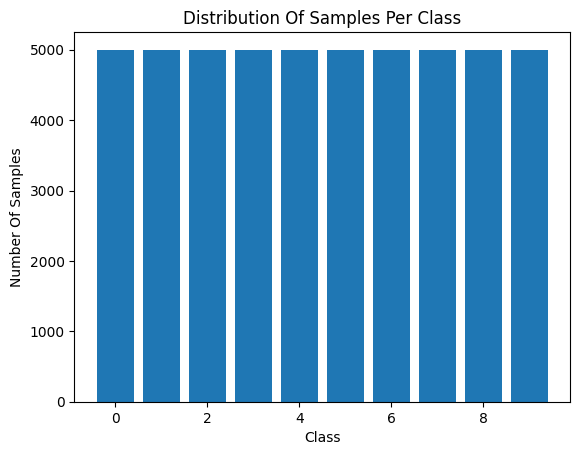

In [2]:
## load dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print("X Train -  rows:", X_train.shape[0]," columns:", X_train.shape[1])
print("X Test -  rows:", X_test.shape[0]," columns:", X_test.shape[1])

print("\nY Train -  rows:", y_train.shape[0])
print("Y Test -  rows:", y_test.shape[0])

## check distribution of image samples per class
counts = np.array(np.unique(y_train, return_counts=True))
plt.bar(counts[0], counts[1])
plt.title('Distribution Of Samples Per Class')
plt.xlabel('Class')
plt.ylabel('Number Of Samples')

Firstly, we plot the counts of samples in each class. This is to check for any form of class imbalance. As shown in the bar chart above, there is an equal number of samples per class, at 50000 images each.

Next, we plot a 2X5 grid of sample images, one from each class, to see what an image from each respective class looks like.

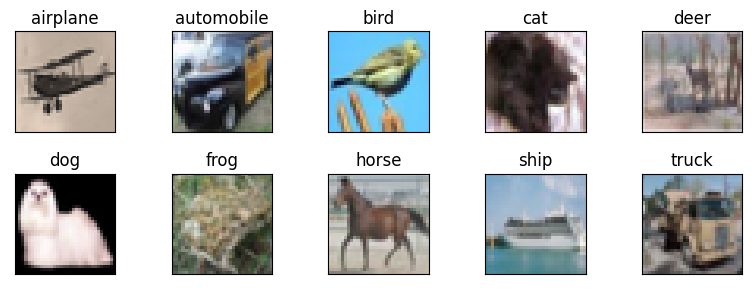

In [4]:
num_classes = len(np.unique(y_train))
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = plt.subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(y_train[:]==i)[0]
    features_idx = X_train[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    img = features_idx[img_num,::]
    ax.set_title(class_names[i])
    plt.imshow(img)
    
plt.tight_layout()

## Color Intensity Analysis

Moving on, we now subset a unique set of indices to extract sample images from, and display them. This set of images will then be used for color intensity analysis. <br><br>

By removing specific color channels, the image will only have two other channels of informatiopn to rely on, which is able to provide us with insights into the role and significance of each color of each class. <br><br>

For example, if upon removing the red channelm results in a significant decrease in visibility and recognizance of the image, it means that the red channel is a prominent part of the image. By repeating this process for every color channel, we are able to better understand how the data is constructed in a more atomic level, specifically RGB color channel distribution.

<Figure size 2500x1000 with 0 Axes>

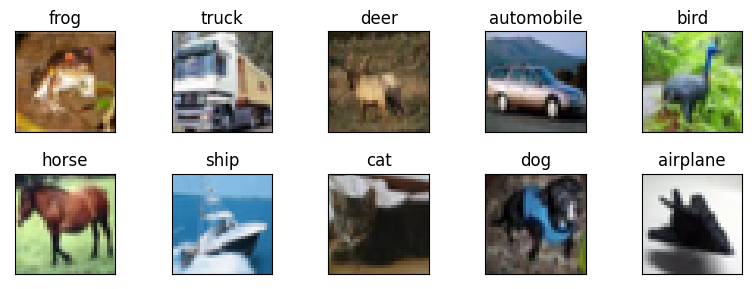

In [5]:
def show_unique_images(images, labels, class_names=class_names):
    unique_labels = []
    unique_indices = []
    
    fig = plt.figure(figsize=(25,10))
    
    n = 0
    for i in range(len(labels)):
        if labels[i] not in unique_labels:
            image = images[i].reshape(3,32,32).transpose(1,2,0)
            unique_labels.append(labels[i])
            unique_indices.append(i)
    
    return unique_indices


def show_images(images, labels, indices, class_names=class_names):
    fig = plt.figure(figsize=(25,10))
    n = 0
    for i in indices:
        image = images[i].reshape(3,32,32).transpose(1,2,0)
        plt.subplot(2,5,n+1)
        n += 1
        plt.imshow(image)
        plt.title(class_names[labels[i]])
    plt.show()
    
    return None

unique_indices = show_unique_images(X_train, y_train)
names = ['frog', 'truck', 'deer', 'automobile', 'bird', 'horse', 'ship', 'cat', 'dog', 'airplane']
def display(unique_indices):
    
    fig = plt.figure(figsize=(8,3))
    for i in range(len(unique_indices)):
        ax = plt.subplot(2, 5, 1 + i, xticks=[], yticks=[])
        ax.set_title(names[i])
        plt.imshow(X_train[unique_indices[i]])

    plt.tight_layout()
    
display(unique_indices)

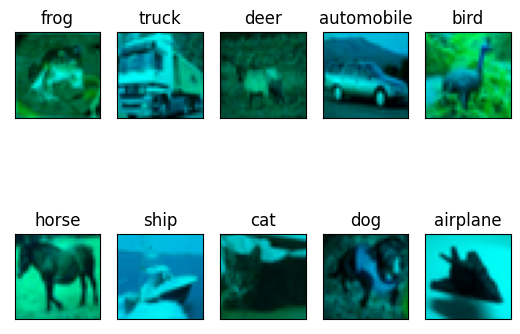

In [6]:
## remove red from images
no_red = []
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
for i in range(len(unique_indices)):
    image = X_train[unique_indices[i]]
    image[..., 0] = 0
    no_red.append(image)
    ax = plt.subplot(2, 5, 1 + i, xticks=[], yticks=[])
    ax.set_title(names[i])
    plt.imshow(no_red[i])

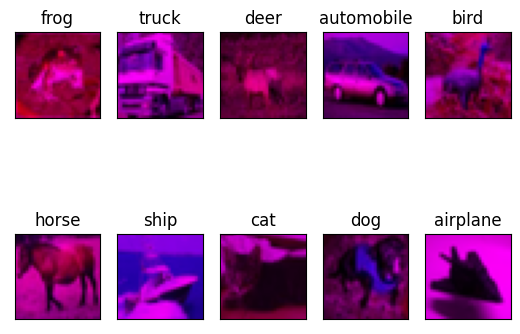

In [7]:
## remove green from images
no_green = []
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
for i in range(len(unique_indices)):
    image = X_train[unique_indices[i]]
    image[..., 1] = 0
    no_green.append(image)
    ax = plt.subplot(2, 5, 1 + i, xticks=[], yticks=[])
    ax.set_title(names[i])
    plt.imshow(no_green[i])

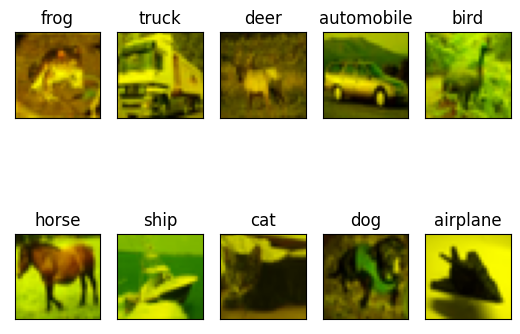

In [8]:
## remove blue from images
no_blue = []
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
for i in range(len(unique_indices)):
    image = X_train[unique_indices[i]]
    image[..., 2] = 0
    no_blue.append(image)
    ax = plt.subplot(2, 5, 1 + i, xticks=[], yticks=[])
    ax.set_title(names[i])
    plt.imshow(no_blue[i])

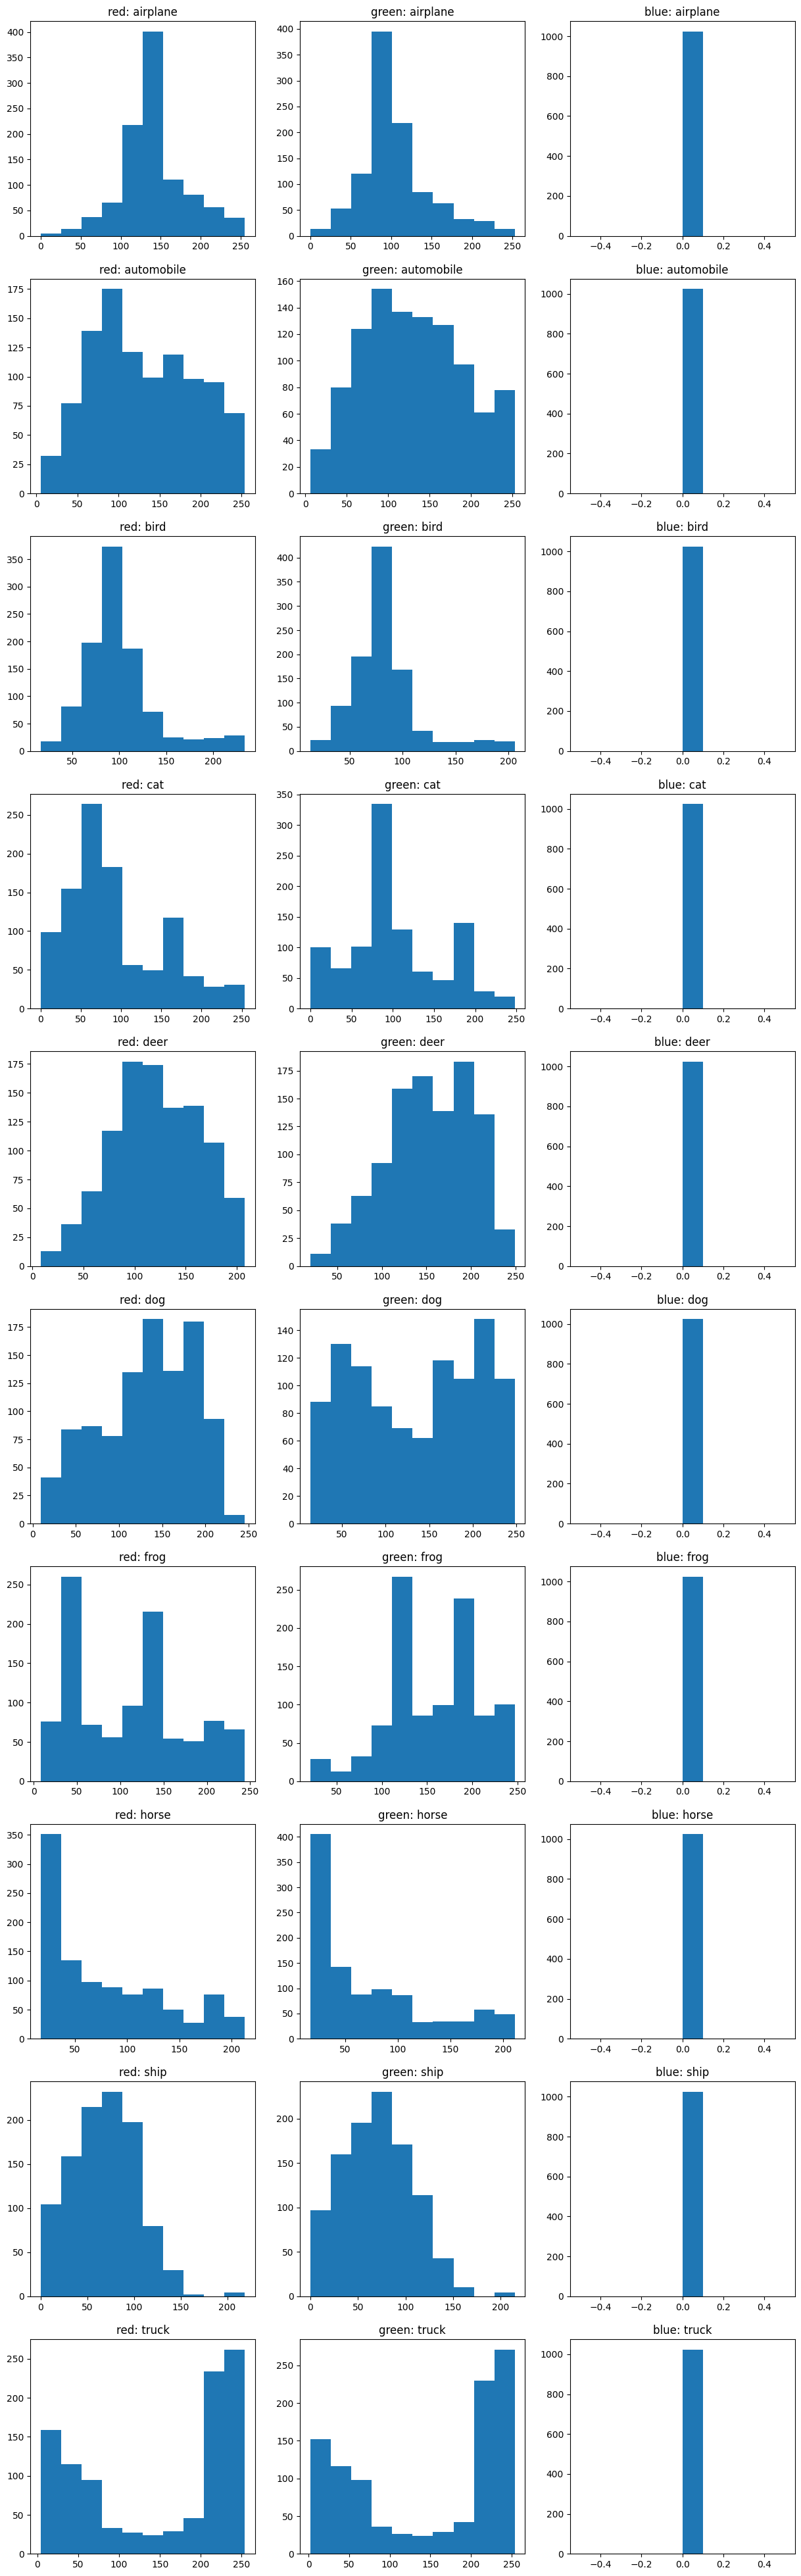

In [9]:
redArr, greenArr, blueArr = [], [], []
for red in range(len(unique_indices)):
    red_channel = X_train[unique_indices][red][..., 0]
    red_channel = red_channel[..., np.newaxis]
    redArr.append(red_channel)
    
    green_channel = X_train[unique_indices][red][..., 1]
    green_channel = green_channel[..., np.newaxis]
    greenArr.append(green_channel)
    
    blue_channel = X_train[unique_indices][red][..., 2]
    blue_channel = blue_channel[..., np.newaxis]
    blueArr.append(blue_channel)
    
redArr = np.array(redArr)
greenArr = np.array(greenArr)
blueArr = np.array(blueArr)    

fig = plt.figure(figsize=(15,50))
n = 0
for i in range(len(unique_indices)):
    plt.subplot(10,3,n+1)
    plt.hist(redArr[i].reshape(-1))
    plt.title("red: " + class_names[i])
    n += 1

    plt.subplot(10,3,n+1)
    plt.hist(greenArr[i].reshape(-1))
    plt.title("green: " + class_names[i])
    n += 1

    plt.subplot(10,3,n+1)
    plt.hist(blueArr[i].reshape(-1))
    plt.title("blue: " + class_names[i])
    n += 1
plt.show()

## Average Image Of Each Class

In the next part of our exploratory data analysis, we will obtain the average image for each class in the dataset. <br><br>

The average image is able to provide a concise visual summary of the overall appearance of images within the dataset. The average image is calcylated by computing the mean of all images in a particular class, outputting a single image representing the general appearance of said class. <br><br>

This allows us to observe the common and prominent features that exist within each class. For example, certain classes could possess similar shapes, colors or textures. It also serves as a good comparison, to understand how each individual image may differ from its standard average image.

C:\Users\rutsm\AppData\Local\Temp\ipykernel_1556\1012319071.py:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  arr = np.zeros((h, w, d), np.float)
C:\Users\rutsm\AppData\Local\Temp\ipykernel_1556\1012319071.py:17: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  imarr = classImages[i].astype(np.float)


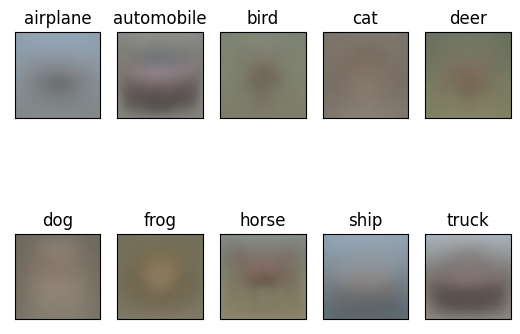

In [10]:
import numpy as np
from PIL import Image

classImgArray = []
for imgClass in range(len(names)):
    classImages = X_train[y_train.flatten() == imgClass]
    
    ## X_train data
    N = classImages.shape[0]
    h, w, d = classImages.shape[1:]

    ## create a numpy array of floats to store the average (assume RGB images)
    arr = np.zeros((h, w, d), np.float)

    ## build up average pixel intensities, casting each image as an array of floats
    for i in range(N):
        imarr = classImages[i].astype(np.float)
        arr = arr + imarr / N

    ## round values in array and cast as 8-bit integer
    arr = np.array(np.round(arr), dtype=np.uint8)
    classImgArray.append(arr)
    
    
for imgClass in range(len(class_names)):
    ax = plt.subplot(2, 5, 1 + imgClass, xticks=[], yticks=[])
    ax.set_title(class_names[imgClass])
    plt.imshow(classImgArray[imgClass])

As shown in the average images plotted above, we can see that automobiles and trucks have an extremely similar average image, showing a rough outline of a vehicle. Airplanes and ships have a very similar blueish background, likely attributed to them usually being in the sky and sea, both of which are blue. <br><br>

Furthermore, the horse class seems to be very well defined, with the color of the horse as well as its outline being easily identifiable. This means that there is little variance among the images within the horse class. <br><br>

However, the rest of the classes produce largely vague and incomprehensible average images, with ambiguous shapes and backgrounds. This is likely due to the fact that there is a high variance in the look of images in these classes, and hence are harder to identify.

# Deep Convolutional Generative Adversarial Network (DCGAN)

## Model Architecture

Now that we have completed our Exploratory Data Analysis, we can move on to the network architecture. For our first experiment, we will be using a Deep Convolutional Generative Adversarial Network, or DCGAN. <br><br>

Typically, as per ML/DL modelling framework, we are to preprocess the data before fitting the data into the model. For this project, we will first create the models first, then create the functions to preprocess our data. <br><br>

We will first start by building the discriminator network. <br>
We first define an input shape of (32, 32, 3), then followed by 4 Conv2D layers that decrease in neuron size in each subsequent layer, by a factor of 2. Each layer is fitted with a LeakyReLU activation function as well. These layers serve to downsample the image. <br><br>

After the 4 layers, we then pass the output into a Flatten layer, before it is passed into a single Dense layer with a single neuron and a sigmoid activation function. This represents our output, which is a binary variable, hence the sigmoid activation. A dropout layer is also added before the Dense layer to attempt to prevent overfitting. <br><br>

Finally, the model is compiled with an Adam optimizer, with binary crossentropy as its loss function and accuracy as its metric.

## Discriminator

### Spectral Normalization <br>

__What Is Spectral Normalization?__ <br><br>

Spectral Normalization is a weight normalization technique that stabilizes the training of the discriminator. It mitigates the exploding gradient problem, and reduces the chance of mode collapse by controlling ther Lipschitz constant.

In [11]:
## define discriminator
def define_discriminator(in_shape=(32,32,3)):
    model = Sequential()

    model.add(Conv2D(128, (3,3), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))

    model.add(SpectralNormalization(Conv2D(128, (3,3), strides=(2,2), padding='same')))
    model.add(LeakyReLU(alpha=0.2))

    model.add(SpectralNormalization(Conv2D(256, (3,3), strides=(2,2), padding='same')))
    model.add(LeakyReLU(alpha=0.2))

    model.add(SpectralNormalization(Conv2D(256, (3,3), strides=(2,2), padding='same')))
    model.add(LeakyReLU(alpha=0.2))

    model.add(SpectralNormalization(Conv2D(512, (3,3), strides=(2,2), padding='same')))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))

    opt = Adam(lr=0.0002, beta_1=0.5)

    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    model.summary()
    return model

Next, we move on the create the generator network. <br><br>

In the generator,  we start with a Dense layer that takes in the latent dimensions, which will be defined later. The latent dimensions refer to noise obtained through a random normal distribution, which will be used to generate our images. <br><br>

Another 3 Conv2DTranspose laters are then added with 256 neurons per later, before being passed into our Conv2D output layer, fitted with a tanh activation function. Additionally, each layer is also fitted with a LeakyReLU activation function.

## Generator

In [12]:
## define generator
def define_generator(latent_dim):
    model = Sequential()
    # foundation for 4x4 image
    n_nodes = 512 * 4 * 4
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((4, 4, 512)))
    # upsample to 8x8
    model.add(Conv2DTranspose(512, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 16x16
    model.add(Conv2DTranspose(512, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 32x32
    model.add(Conv2DTranspose(512, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 64x64
#     model.add(Conv2DTranspose(512, (4,4), strides=(2,2), padding='same'))
#     model.add(LeakyReLU(alpha=0.2))
    # output layer
    model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
    model.summary()
    return model

After the Discriminator and Generator Networks have been created, we can combine them into a single GAN model.

## GAN

In [13]:
## define GAN
def define_gan(g_model, d_model):

    d_model.trainable = False

    model = Sequential()

    model.add(g_model)

    model.add(d_model)

    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

## Data Preprocessing

## DiffAugment + Real/Fake Samples

In this code cell, we will define a series of functions that are used in DiffAugment, as well as the functions to load the real and fake samples. These functions include standard data preprocessing techniques, such as datatype conversion and feature scaling. <br><br>

__What is DiffAugment?__ <br>
DiffAugment is a data augmentation technique for improving the robustness of deep learning models. <br><br>
By applying a series of random combinations of transformations to the training data, we are able to create a more diverse set of training images, to help capture variance in the data. <br><br>

DiffAugment works by selecting combinations of data augmentation operations at random, such as color augmenting, brightness, saturation, flipping, and even cutouts. By increasing the diversity of training samples, it is able to reduce overfitting and provide better generalization. <br><br>

$$
x' = \begin{cases}
x & \text{with probability } \frac{1}{2} \\
\text{fliplr}(x) & \text{with probability } \frac{1}{2}
\end{cases}
$$
<br>

Rotation:
$$
x' = \text{rotate}(x, \theta)
$$
<br>

Crop:
$$
x' = \text{crop}(x, (h, w))
$$
<br>

Scaling:
$$
x' = \text{resize}(x, (sh, sw))
$$
<br>

Brightness & Contrast:
$$
x' = \alpha x + \beta
$$
<br>

In [4]:
def rand_brightness(x):
    magnitude = tf.random.uniform([tf.shape(x)[0], 1, 1, 1]) - 0.5
    x = x + magnitude
    return x


def rand_saturation(x):
    magnitude = tf.random.uniform([tf.shape(x)[0], 1, 1, 1]) * 2
    x_mean = tf.reduce_mean(x, axis=3, keepdims=True)
    x = (x - x_mean) * magnitude + x_mean
    return x


def rand_contrast(x):
    magnitude = tf.random.uniform([tf.shape(x)[0], 1, 1, 1]) + 0.5
    x_mean = tf.reduce_mean(x, axis=[1, 2, 3], keepdims=True)
    x = (x - x_mean) * magnitude + x_mean
    return x


def rand_translation(x, ratio=0.125):
    batch_size = tf.shape(x)[0]
    image_size = tf.shape(x)[1:3]
    shift = tf.cast(tf.cast(image_size, tf.float32) * ratio + 0.5, tf.int32)
    translation_x = tf.random.uniform([batch_size, 1], -shift[0], shift[0] + 1, dtype=tf.int32)
    translation_y = tf.random.uniform([batch_size, 1], -shift[1], shift[1] + 1, dtype=tf.int32)
    grid_x = tf.clip_by_value(tf.expand_dims(tf.range(image_size[0], dtype=tf.int32), 0) + translation_x + 1, 0, image_size[0] + 1)
    grid_y = tf.clip_by_value(tf.expand_dims(tf.range(image_size[1], dtype=tf.int32), 0) + translation_y + 1, 0, image_size[1] + 1)
    x = tf.gather_nd(tf.pad(x, [[0, 0], [1, 1], [0, 0], [0, 0]]), tf.expand_dims(grid_x, -1), batch_dims=1)
    x = tf.transpose(tf.gather_nd(tf.pad(tf.transpose(x, [0, 2, 1, 3]), [[0, 0], [1, 1], [0, 0], [0, 0]]), tf.expand_dims(grid_y, -1), batch_dims=1), [0, 2, 1, 3])
    return x


def rand_cutout(x, ratio=0.5):
    batch_size = tf.shape(x)[0]
    image_size = tf.shape(x)[1:3]
    cutout_size = tf.cast(tf.cast(image_size, tf.float32) * ratio + 0.5, tf.int32)
    offset_x = tf.random.uniform([tf.shape(x)[0], 1, 1], maxval=image_size[0] + (1 - cutout_size[0] % 2), dtype=tf.int32)
    offset_y = tf.random.uniform([tf.shape(x)[0], 1, 1], maxval=image_size[1] + (1 - cutout_size[1] % 2), dtype=tf.int32)
    grid_batch, grid_x, grid_y = tf.meshgrid(tf.range(batch_size, dtype=tf.int32), tf.range(cutout_size[0], dtype=tf.int32), tf.range(cutout_size[1], dtype=tf.int32), indexing='ij')
    cutout_grid = tf.stack([grid_batch, grid_x + offset_x - cutout_size[0] // 2, grid_y + offset_y - cutout_size[1] // 2], axis=-1)
    mask_shape = tf.stack([batch_size, image_size[0], image_size[1]])
    cutout_grid = tf.maximum(cutout_grid, 0)
    cutout_grid = tf.minimum(cutout_grid, tf.reshape(mask_shape - 1, [1, 1, 1, 3]))
    mask = tf.maximum(1 - tf.scatter_nd(cutout_grid, tf.ones([batch_size, cutout_size[0], cutout_size[1]], dtype=tf.float32), mask_shape), 0)
    x = x * tf.expand_dims(mask, axis=3)
    return x

AUGMENT_FNS = {
    'color': [rand_brightness, rand_saturation, rand_contrast],
    'translation': [rand_translation],
    'cutout': [rand_cutout],
}
AUG_OPT = [rand_brightness, rand_saturation, rand_contrast]
           
def DiffAugment(X, policy='color,translation,cutout', channels_first=False):
    if policy:
        if channels_first:
            X = tf.transpose(X, [0, 2, 3, 1])
        for p in policy.split(','):
            for f in AUGMENT_FNS[p]:
                X = f(X)
        if channels_first:
            X = tf.transpose(X, [0, 3, 1, 2])
    return X


def load_real_samples():

    (trainX, _), (_, _) = load_data()
    X = []
#     for image in range(len(trainX)):
#         img_resized = cv2.resize(trainX[image], (32, 32), interpolation=cv2.INTER_LINEAR)
#         X.append(img_resized)

    ## convert dtype to float
    X = np.array(trainX).astype('float32')
    ## scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5
    X = DiffAugment(X)
    print('X', X.shape)
    return X


def generate_real_samples(dataset, n_samples):
    ## choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    ## retrieve selected images
    X = dataset[ix]
    ## generate 'real' class labels (1)
    y = ones((n_samples, 1))
    return X, y

## generate latent points
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

## fake exmaples with labels
def generate_fake_samples(g_model, latent_dim, n_samples):
    ## generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    ## predict outputs
    X = g_model.predict(x_input)
    ## create 'fake' class labels (0)
    y = zeros((n_samples, 1))
    return X, y

## Metrics

In order to evaluate the performance of our model, we will define a number of metrics and helper functions. <br><br>

The metrics we will be using are accuracy, discriminator loss, generator loss and Fréchet-Inception Distance (FID). Other than these metrics, we also define helper function to help in the assessment of our model, such as plot saving functions and summarization functions.<br><br>

__What is Fréchet Inception Distance__ <br>
The FID score is computed by comparing the activations of the Inception network (a pre-trained deep convolutional neural network) for real and generated data. The activations are used to estimate the mean and covariance of the feature distributions for the real and generated data. The Fréchet distance, which measures the difference between two Gaussian distributions, is then calculated based on these estimates. <br><br>

The FID score is intended to provide a single scalar measure of the quality of the generated data, taking into account the distribution of features in the data. A lower FID score indicates that the distribution of generated data is closer to the distribution of real data, which is generally considered to be a good indicator of the quality of the generative model. <br><br>

__Why not Inception Score?__ <br>
Although Inception Score is a very well-known and commonly used metric for evaluating GANs, it requires an immense amount of data to function properly. Typically, it requires thousands and even up to tens of thousands of samples to be evaluated thoroughly. As this is extremely computationally expensive and due to the time and memory constraints of this assignment, IS will not be used as an evaluation metric. <br><br>

Despite the existence of multiple forms of metrics to help evaluate the performance of our model, it is important to note that they are only gauges, and may not be very accurate. This is because although they are statistically correct, what is arithmatically considered 'good' may differ drastically from human subjectivity. Hence, it is reccomended to take these results with a grain of salt. <br><br>

In the end, the objective is to generate images that are indistinguishable from the original real images, that us humans are able to appreciate, which is the most important metric.

In [16]:
## scaling for metrics
def scale_images(images, new_shape):
    images_list = list()
    for image in images:
        ## resize with nearest neighbor interpolation
        new_image = resize(image, new_shape, 0)
        ## store
        images_list.append(new_image)
    return asarray(images_list)

## calculate frechet inception distance
def calculate_fid(model, images1, images2):
    ## calculate activations
    act1 = model.predict(images1)
    act2 = model.predict(images2)
    ## calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
    ## calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    ## calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    ## check and correct imaginary numbers from sqrt
    if iscomplexobj(covmean):
        covmean = covmean.real
    ## calculate score
    fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid


def calculate_inception_score(images, n_split=5, eps=1E-16):
    ## load inception v3 model
    model = InceptionV3()
    ## enumerate splits of images/predictions
    scores = list()
    n_part = floor(images.shape[0] / n_split)
    for i in range(n_split):
        ## retrieve images
        ix_start, ix_end = int(i * n_part), int((i+1) * n_part)
        subset = images[ix_start:ix_end]
        ## convert from uint8 to float32
        subset = subset.astype('float32')
        ## scale images to the required size
        subset = scale_images(subset, (299,299,3))
        ## pre-process images, scale to [-1,1]
        subset = preprocess_input(subset)
        ## predict p(y|x)
        p_yx = model.predict(subset)
        ## calculate p(y)
        p_y = expand_dims(p_yx.mean(axis=0), 0)
        ## calculate KL divergence using log probabilities
        kl_d = p_yx * (log(p_yx + eps) - log(p_y + eps))
        ## sum over classes
        sum_kl_d = kl_d.sum(axis=1)
        ## average over images
        avg_kl_d = mean(sum_kl_d)
        ## undo the log
        is_score = exp(avg_kl_d)
        ## store
        scores.append(is_score)
        ## average across images
        is_avg, is_std = mean(scores), std(scores)
    return is_avg, is_std, avg_kl_d


## train the model
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=200, n_batch=256):
    d_loss1_history, d_loss2_history, g_loss_history, fid_array = [], [], [], []
    is_avg_array, is_std_array, kl_d_array = [], [], []
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # update discriminator model weights
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # summarize loss on this batch
            print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
                (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
            d_loss1_history.append(d_loss1)
            d_loss2_history.append(d_loss2)
            g_loss_history.append(g_loss)
            wandb.log({'d_loss1': d_loss1,
                       'd_loss2': d_loss2,
                       'g_loss': g_loss})
            
        ## evaluate every 5 epochs
        if (i+1) % 5 == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)
            ## inception model
            model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))
            images1 = X_real.astype('float32')
            images2 = X_fake.astype('float32')
            images1 = scale_images(images1, (299, 299, 3))
            images2 = scale_images(images2, (299, 299, 3))
            images1 = preprocess_input(images1)
            images2 = preprocess_input(images2)
            fid = calculate_fid(model, images1, images2)
            fid_array.append(fid)
            print('fid: ' + str(fid))
            
            is_avg, is_std, avg_kl_d = calculate_inception_score(X_fake)
            is_avg_array.append(is_avg)
            is_std_array.append(is_std)
            kl_d_array.append(avg_kl_d)
            print('score', is_avg, is_std)
            
    return d_loss1_history, d_loss2_history, g_loss_history, acc_real_array, acc_fake_array, fid_array, is_avg_array, is_std_array, kl_d_array 

## Train The GAN

Now that we have created our networks, performed preprocessing and defined our metrics, we can finally fit the data into the model to train. We print a 10X10 grid of images every 5 epochs to observe its performance in real time.

In [17]:
# Wandb Log
config = {
    'learning_rate': 0.0002,
    'epochs': 200,
    'batch_size': 256,
}

run = wandb.init(project='dcgan', entity='ryanueda34', config=config)
wandb.run.name = 'Test'
config = wandb.config

## size of the latent space
latent_dim = 100
## discriminator
d_model = define_discriminator()
## generator
g_model = define_generator(latent_dim)
## gan
gan_model = define_gan(g_model, d_model)
## load image data
dataset = load_real_samples()
## train model
d1_loss_history, d2_loss_history, g_loss_history, acc_real_array, acc_fake_array, fid_array, is_avg_array, is_std_array, kl_d_array = train(g_model, d_model, gan_model, dataset, latent_dim)

wandb: Currently logged in as: ryanueda34. Use `wandb login --relogin` to force relogin


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 128)       3584      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       147584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 256)         295168    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 256)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 256)         5

C:\Users\rutsm\anaconda3\envs\dele_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


X (50000, 32, 32, 3)
4/4 [==============================] - 2s 11ms/step
>1, 1/195, d1=0.695, d2=0.697 g=0.691
4/4 [==============================] - 0s 14ms/step
>1, 2/195, d1=0.611, d2=0.706 g=0.682
4/4 [==============================] - 0s 14ms/step
>1, 3/195, d1=0.468, d2=0.789 g=0.628
4/4 [==============================] - 0s 14ms/step
>1, 4/195, d1=0.281, d2=1.168 g=0.547
4/4 [==============================] - 0s 14ms/step
>1, 5/195, d1=0.221, d2=1.192 g=0.638
4/4 [==============================] - 0s 14ms/step
>1, 6/195, d1=0.273, d2=0.806 g=0.855
4/4 [==============================] - 0s 14ms/step
>1, 7/195, d1=0.278, d2=0.522 g=1.347
4/4 [==============================] - 0s 15ms/step
>1, 8/195, d1=0.195, d2=0.298 g=2.308
4/4 [==============================] - 0s 14ms/step
>1, 9/195, d1=0.257, d2=0.326 g=2.196
4/4 [==============================] - 0s 14ms/step
>1, 10/195, d1=0.197, d2=0.579 g=1.149
4/4 [==============================] - 0s 15ms/step
>1, 11/195, d1=0.155, d2=0

4/4 [==============================] - 0s 14ms/step
>1, 91/195, d1=0.492, d2=0.420 g=2.810
4/4 [==============================] - 0s 16ms/step
>1, 92/195, d1=0.387, d2=0.559 g=2.626
4/4 [==============================] - 0s 15ms/step
>1, 93/195, d1=0.377, d2=0.401 g=2.717
4/4 [==============================] - 0s 15ms/step
>1, 94/195, d1=0.423, d2=0.379 g=2.614
4/4 [==============================] - 0s 14ms/step
>1, 95/195, d1=0.389, d2=0.358 g=2.669
4/4 [==============================] - 0s 14ms/step
>1, 96/195, d1=0.282, d2=0.569 g=2.721
4/4 [==============================] - 0s 14ms/step
>1, 97/195, d1=0.348, d2=2.102 g=2.581
4/4 [==============================] - 0s 14ms/step
>1, 98/195, d1=0.681, d2=1.045 g=2.997
4/4 [==============================] - 0s 14ms/step
>1, 99/195, d1=1.106, d2=0.453 g=1.548
4/4 [==============================] - 0s 14ms/step
>1, 100/195, d1=0.946, d2=0.339 g=2.330
4/4 [==============================] - 0s 15ms/step
>1, 101/195, d1=0.699, d2=0.224 g=3.1

4/4 [==============================] - 0s 18ms/step
>2, 75/195, d1=0.611, d2=0.605 g=1.539
4/4 [==============================] - 0s 16ms/step
>2, 76/195, d1=0.702, d2=0.726 g=1.494
4/4 [==============================] - 0s 16ms/step
>2, 77/195, d1=0.790, d2=0.567 g=1.534
4/4 [==============================] - 0s 16ms/step
>2, 78/195, d1=0.830, d2=0.468 g=1.478
4/4 [==============================] - 0s 15ms/step
>2, 79/195, d1=0.768, d2=0.449 g=1.510
4/4 [==============================] - 0s 16ms/step
>2, 80/195, d1=0.721, d2=0.423 g=1.485
4/4 [==============================] - 0s 17ms/step
>2, 81/195, d1=0.709, d2=0.525 g=1.370
4/4 [==============================] - 0s 15ms/step
>2, 82/195, d1=0.604, d2=0.547 g=1.519
4/4 [==============================] - 0s 16ms/step
>2, 83/195, d1=0.751, d2=0.569 g=1.367
4/4 [==============================] - 0s 15ms/step
>2, 84/195, d1=0.784, d2=0.561 g=1.384
4/4 [==============================] - 0s 16ms/step
>2, 85/195, d1=0.706, d2=0.632 g=1.248

4/4 [==============================] - 0s 14ms/step
>3, 59/195, d1=0.588, d2=0.557 g=1.166
4/4 [==============================] - 0s 14ms/step
>3, 60/195, d1=0.569, d2=0.561 g=1.125
4/4 [==============================] - 0s 14ms/step
>3, 61/195, d1=0.514, d2=0.623 g=1.191
4/4 [==============================] - 0s 14ms/step
>3, 62/195, d1=0.635, d2=0.620 g=1.097
4/4 [==============================] - 0s 14ms/step
>3, 63/195, d1=0.694, d2=0.716 g=1.066
4/4 [==============================] - 0s 14ms/step
>3, 64/195, d1=0.740, d2=0.673 g=1.076
4/4 [==============================] - 0s 14ms/step
>3, 65/195, d1=0.681, d2=0.703 g=1.008
4/4 [==============================] - 0s 14ms/step
>3, 66/195, d1=0.658, d2=0.689 g=1.025
4/4 [==============================] - 0s 14ms/step
>3, 67/195, d1=0.692, d2=0.584 g=1.146
4/4 [==============================] - 0s 14ms/step
>3, 68/195, d1=0.706, d2=0.565 g=1.235
4/4 [==============================] - 0s 14ms/step
>3, 69/195, d1=0.622, d2=0.595 g=1.241

4/4 [==============================] - 0s 14ms/step
>4, 43/195, d1=0.651, d2=0.627 g=1.302
4/4 [==============================] - 0s 14ms/step
>4, 44/195, d1=0.614, d2=0.594 g=1.478
4/4 [==============================] - 0s 14ms/step
>4, 45/195, d1=0.621, d2=0.511 g=1.395
4/4 [==============================] - 0s 14ms/step
>4, 46/195, d1=0.560, d2=0.624 g=1.333
4/4 [==============================] - 0s 14ms/step
>4, 47/195, d1=0.668, d2=0.617 g=1.230
4/4 [==============================] - 0s 14ms/step
>4, 48/195, d1=0.606, d2=0.597 g=1.089
4/4 [==============================] - 0s 15ms/step
>4, 49/195, d1=0.502, d2=0.623 g=1.101
4/4 [==============================] - 0s 14ms/step
>4, 50/195, d1=0.577, d2=0.609 g=1.154
4/4 [==============================] - 0s 15ms/step
>4, 51/195, d1=0.528, d2=0.586 g=1.239
4/4 [==============================] - 0s 14ms/step
>4, 52/195, d1=0.523, d2=0.469 g=1.340
4/4 [==============================] - 0s 14ms/step
>4, 53/195, d1=0.459, d2=0.462 g=1.427

4/4 [==============================] - 0s 14ms/step
>4, 133/195, d1=0.563, d2=0.511 g=1.253
4/4 [==============================] - 0s 14ms/step
>4, 134/195, d1=0.564, d2=0.518 g=1.267
4/4 [==============================] - 0s 14ms/step
>4, 135/195, d1=0.535, d2=0.577 g=1.329
4/4 [==============================] - 0s 14ms/step
>4, 136/195, d1=0.593, d2=0.583 g=1.306
4/4 [==============================] - 0s 14ms/step
>4, 137/195, d1=0.625, d2=0.572 g=1.323
4/4 [==============================] - 0s 14ms/step
>4, 138/195, d1=0.694, d2=0.604 g=1.256
4/4 [==============================] - 0s 14ms/step
>4, 139/195, d1=0.635, d2=0.597 g=1.228
4/4 [==============================] - 0s 14ms/step
>4, 140/195, d1=0.654, d2=0.552 g=1.201
4/4 [==============================] - 0s 14ms/step
>4, 141/195, d1=0.617, d2=0.634 g=1.117
4/4 [==============================] - 0s 14ms/step
>4, 142/195, d1=0.613, d2=0.609 g=1.160
4/4 [==============================] - 0s 14ms/step
>4, 143/195, d1=0.552, d2=0.

4/4 [==============================] - 0s 14ms/step
>5, 117/195, d1=0.630, d2=0.525 g=1.426
4/4 [==============================] - 0s 15ms/step
>5, 118/195, d1=0.506, d2=0.503 g=1.465
4/4 [==============================] - 0s 14ms/step
>5, 119/195, d1=0.531, d2=0.452 g=1.499
4/4 [==============================] - 0s 14ms/step
>5, 120/195, d1=0.542, d2=0.450 g=1.434
4/4 [==============================] - 0s 14ms/step
>5, 121/195, d1=0.539, d2=0.524 g=1.306
4/4 [==============================] - 0s 14ms/step
>5, 122/195, d1=0.496, d2=0.611 g=1.240
4/4 [==============================] - 0s 14ms/step
>5, 123/195, d1=0.558, d2=0.652 g=1.154
4/4 [==============================] - 0s 14ms/step
>5, 124/195, d1=0.502, d2=0.639 g=1.211
4/4 [==============================] - 0s 14ms/step
>5, 125/195, d1=0.562, d2=0.645 g=1.216
4/4 [==============================] - 0s 14ms/step
>5, 126/195, d1=0.648, d2=0.673 g=1.211
4/4 [==============================] - 0s 14ms/step
>5, 127/195, d1=0.600, d2=0.

4/4 [==============================] - 0s 14ms/step
>6, 4/195, d1=0.652, d2=0.641 g=1.318
4/4 [==============================] - 0s 14ms/step
>6, 5/195, d1=0.642, d2=0.527 g=1.435
4/4 [==============================] - 0s 14ms/step
>6, 6/195, d1=0.600, d2=0.590 g=1.332
4/4 [==============================] - 0s 14ms/step
>6, 7/195, d1=0.604, d2=0.598 g=1.263
4/4 [==============================] - 0s 14ms/step
>6, 8/195, d1=0.574, d2=0.581 g=1.340
4/4 [==============================] - 0s 14ms/step
>6, 9/195, d1=0.537, d2=0.556 g=1.390
4/4 [==============================] - 0s 14ms/step
>6, 10/195, d1=0.524, d2=0.544 g=1.492
4/4 [==============================] - 0s 14ms/step
>6, 11/195, d1=0.546, d2=0.538 g=1.628
4/4 [==============================] - 0s 14ms/step
>6, 12/195, d1=0.700, d2=0.625 g=1.696
4/4 [==============================] - 0s 14ms/step
>6, 13/195, d1=0.736, d2=0.446 g=1.527
4/4 [==============================] - 0s 14ms/step
>6, 14/195, d1=0.637, d2=0.549 g=1.489
4/4 [

4/4 [==============================] - 0s 14ms/step
>6, 183/195, d1=0.627, d2=0.536 g=1.140
4/4 [==============================] - 0s 14ms/step
>6, 184/195, d1=0.550, d2=0.686 g=1.058
4/4 [==============================] - 0s 14ms/step
>6, 185/195, d1=0.524, d2=0.682 g=1.053
4/4 [==============================] - 0s 14ms/step
>6, 186/195, d1=0.535, d2=0.609 g=1.113
4/4 [==============================] - 0s 14ms/step
>6, 187/195, d1=0.576, d2=0.544 g=1.174
4/4 [==============================] - 0s 14ms/step
>6, 188/195, d1=0.541, d2=0.541 g=1.257
4/4 [==============================] - 0s 14ms/step
>6, 189/195, d1=0.558, d2=0.492 g=1.342
4/4 [==============================] - 0s 14ms/step
>6, 190/195, d1=0.561, d2=0.511 g=1.319
4/4 [==============================] - 0s 14ms/step
>6, 191/195, d1=0.546, d2=0.581 g=1.298
4/4 [==============================] - 0s 15ms/step
>6, 192/195, d1=0.512, d2=0.562 g=1.309
4/4 [==============================] - 0s 14ms/step
>6, 193/195, d1=0.606, d2=0.

4/4 [==============================] - 0s 14ms/step
>7, 78/195, d1=0.619, d2=0.577 g=1.216
4/4 [==============================] - 0s 14ms/step
>7, 79/195, d1=0.556, d2=0.517 g=1.285
4/4 [==============================] - 0s 14ms/step
>7, 80/195, d1=0.466, d2=0.497 g=1.369
4/4 [==============================] - 0s 14ms/step
>7, 81/195, d1=0.471, d2=0.514 g=1.327
4/4 [==============================] - 0s 14ms/step
>7, 82/195, d1=0.423, d2=0.611 g=1.226
4/4 [==============================] - 0s 14ms/step
>7, 83/195, d1=0.479, d2=0.719 g=1.271
4/4 [==============================] - 0s 14ms/step
>7, 84/195, d1=0.600, d2=0.668 g=1.318
4/4 [==============================] - 0s 14ms/step
>7, 85/195, d1=0.832, d2=0.577 g=1.264
4/4 [==============================] - 0s 14ms/step
>7, 86/195, d1=0.845, d2=0.539 g=1.235
4/4 [==============================] - 0s 14ms/step
>7, 87/195, d1=0.745, d2=0.616 g=1.342
4/4 [==============================] - 0s 14ms/step
>7, 88/195, d1=0.746, d2=0.390 g=1.414

4/4 [==============================] - 0s 14ms/step
>8, 62/195, d1=0.732, d2=0.516 g=1.191
4/4 [==============================] - 0s 14ms/step
>8, 63/195, d1=0.703, d2=0.636 g=1.139
4/4 [==============================] - 0s 14ms/step
>8, 64/195, d1=0.689, d2=0.590 g=1.149
4/4 [==============================] - 0s 14ms/step
>8, 65/195, d1=0.692, d2=0.509 g=1.205
4/4 [==============================] - 0s 14ms/step
>8, 66/195, d1=0.692, d2=0.538 g=1.122
4/4 [==============================] - 0s 14ms/step
>8, 67/195, d1=0.609, d2=0.604 g=1.108
4/4 [==============================] - 0s 14ms/step
>8, 68/195, d1=0.627, d2=0.606 g=1.054
4/4 [==============================] - 0s 14ms/step
>8, 69/195, d1=0.624, d2=0.673 g=1.040
4/4 [==============================] - 0s 14ms/step
>8, 70/195, d1=0.633, d2=0.594 g=1.036
4/4 [==============================] - 0s 14ms/step
>8, 71/195, d1=0.597, d2=0.594 g=1.112
4/4 [==============================] - 0s 14ms/step
>8, 72/195, d1=0.660, d2=0.536 g=1.165

4/4 [==============================] - 0s 14ms/step
>9, 46/195, d1=0.630, d2=0.655 g=1.086
4/4 [==============================] - 0s 14ms/step
>9, 47/195, d1=0.618, d2=0.556 g=1.309
4/4 [==============================] - 0s 14ms/step
>9, 48/195, d1=0.685, d2=0.418 g=1.526
4/4 [==============================] - 0s 14ms/step
>9, 49/195, d1=0.560, d2=0.493 g=1.438
4/4 [==============================] - 0s 14ms/step
>9, 50/195, d1=0.528, d2=0.501 g=1.210
4/4 [==============================] - 0s 14ms/step
>9, 51/195, d1=0.511, d2=0.632 g=1.113
4/4 [==============================] - 0s 14ms/step
>9, 52/195, d1=0.449, d2=0.761 g=1.054
4/4 [==============================] - 0s 14ms/step
>9, 53/195, d1=0.501, d2=0.669 g=1.133
4/4 [==============================] - 0s 14ms/step
>9, 54/195, d1=0.526, d2=0.623 g=1.158
4/4 [==============================] - 0s 14ms/step
>9, 55/195, d1=0.640, d2=0.624 g=1.133
4/4 [==============================] - 0s 14ms/step
>9, 56/195, d1=0.510, d2=0.572 g=1.196

4/4 [==============================] - 0s 14ms/step
>9, 136/195, d1=0.626, d2=0.605 g=1.244
4/4 [==============================] - 0s 14ms/step
>9, 137/195, d1=0.671, d2=0.508 g=1.204
4/4 [==============================] - 0s 14ms/step
>9, 138/195, d1=0.719, d2=0.556 g=1.178
4/4 [==============================] - 0s 14ms/step
>9, 139/195, d1=0.640, d2=0.569 g=1.106
4/4 [==============================] - 0s 14ms/step
>9, 140/195, d1=0.664, d2=0.723 g=1.171
4/4 [==============================] - 0s 14ms/step
>9, 141/195, d1=0.733, d2=0.481 g=1.215
4/4 [==============================] - 0s 14ms/step
>9, 142/195, d1=0.688, d2=0.465 g=1.216
4/4 [==============================] - 0s 14ms/step
>9, 143/195, d1=0.744, d2=0.473 g=1.231
4/4 [==============================] - 0s 14ms/step
>9, 144/195, d1=0.567, d2=0.507 g=1.231
4/4 [==============================] - 0s 14ms/step
>9, 145/195, d1=0.483, d2=0.527 g=1.328
4/4 [==============================] - 0s 14ms/step
>9, 146/195, d1=0.504, d2=0.

4/4 [==============================] - 0s 14ms/step
>10, 119/195, d1=0.723, d2=0.543 g=1.177
4/4 [==============================] - 0s 14ms/step
>10, 120/195, d1=0.613, d2=0.526 g=1.157
4/4 [==============================] - 0s 14ms/step
>10, 121/195, d1=0.574, d2=0.634 g=1.105
4/4 [==============================] - 0s 14ms/step
>10, 122/195, d1=0.648, d2=0.814 g=1.153
4/4 [==============================] - 0s 14ms/step
>10, 123/195, d1=0.693, d2=0.541 g=1.174
4/4 [==============================] - 0s 14ms/step
>10, 124/195, d1=0.653, d2=0.640 g=1.191
4/4 [==============================] - 0s 14ms/step
>10, 125/195, d1=0.685, d2=0.596 g=1.251
4/4 [==============================] - 0s 14ms/step
>10, 126/195, d1=0.759, d2=0.581 g=1.235
4/4 [==============================] - 0s 14ms/step
>10, 127/195, d1=0.711, d2=0.554 g=1.265
4/4 [==============================] - 0s 14ms/step
>10, 128/195, d1=0.642, d2=0.524 g=1.167
4/4 [==============================] - 0s 14ms/step
>10, 129/195, d1=0

4/4 [==============================] - 0s 14ms/step
>11, 5/195, d1=0.656, d2=0.581 g=1.057
4/4 [==============================] - 0s 16ms/step
>11, 6/195, d1=0.642, d2=0.552 g=1.033
4/4 [==============================] - 0s 16ms/step
>11, 7/195, d1=0.667, d2=0.595 g=1.080
4/4 [==============================] - 0s 15ms/step
>11, 8/195, d1=0.636, d2=0.553 g=1.080
4/4 [==============================] - 0s 14ms/step
>11, 9/195, d1=0.601, d2=0.550 g=1.127
4/4 [==============================] - 0s 14ms/step
>11, 10/195, d1=0.533, d2=0.574 g=1.182
4/4 [==============================] - 0s 14ms/step
>11, 11/195, d1=0.513, d2=0.673 g=1.205
4/4 [==============================] - 0s 15ms/step
>11, 12/195, d1=0.536, d2=0.532 g=1.161
4/4 [==============================] - 0s 14ms/step
>11, 13/195, d1=0.478, d2=0.672 g=1.132
4/4 [==============================] - 0s 15ms/step
>11, 14/195, d1=0.600, d2=0.588 g=1.168
4/4 [==============================] - 0s 14ms/step
>11, 15/195, d1=0.591, d2=0.644 g

4/4 [==============================] - 0s 14ms/step
>11, 182/195, d1=0.600, d2=0.635 g=1.125
4/4 [==============================] - 0s 14ms/step
>11, 183/195, d1=0.679, d2=0.784 g=1.193
4/4 [==============================] - 0s 14ms/step
>11, 184/195, d1=0.787, d2=0.542 g=1.220
4/4 [==============================] - 0s 14ms/step
>11, 185/195, d1=0.813, d2=0.458 g=1.093
4/4 [==============================] - 0s 15ms/step
>11, 186/195, d1=0.759, d2=0.536 g=0.995
4/4 [==============================] - 0s 14ms/step
>11, 187/195, d1=0.691, d2=0.582 g=0.936
4/4 [==============================] - 0s 14ms/step
>11, 188/195, d1=0.655, d2=0.613 g=0.935
4/4 [==============================] - 0s 14ms/step
>11, 189/195, d1=0.584, d2=0.640 g=0.921
4/4 [==============================] - 0s 14ms/step
>11, 190/195, d1=0.566, d2=0.615 g=0.929
4/4 [==============================] - 0s 14ms/step
>11, 191/195, d1=0.536, d2=0.620 g=1.023
4/4 [==============================] - 0s 14ms/step
>11, 192/195, d1=0

4/4 [==============================] - 0s 14ms/step
>12, 76/195, d1=0.608, d2=0.643 g=0.855
4/4 [==============================] - 0s 14ms/step
>12, 77/195, d1=0.577, d2=0.707 g=0.819
4/4 [==============================] - 0s 14ms/step
>12, 78/195, d1=0.577, d2=0.689 g=0.845
4/4 [==============================] - 0s 15ms/step
>12, 79/195, d1=0.574, d2=0.649 g=0.924
4/4 [==============================] - 0s 14ms/step
>12, 80/195, d1=0.566, d2=0.635 g=0.988
4/4 [==============================] - 0s 14ms/step
>12, 81/195, d1=0.630, d2=0.570 g=0.986
4/4 [==============================] - 0s 14ms/step
>12, 82/195, d1=0.558, d2=0.563 g=0.986
4/4 [==============================] - 0s 14ms/step
>12, 83/195, d1=0.495, d2=0.617 g=1.041
4/4 [==============================] - 0s 14ms/step
>12, 84/195, d1=0.515, d2=0.571 g=1.070
4/4 [==============================] - 0s 14ms/step
>12, 85/195, d1=0.519, d2=0.619 g=1.020
4/4 [==============================] - 0s 14ms/step
>12, 86/195, d1=0.560, d2=0.

4/4 [==============================] - 0s 14ms/step
>13, 58/195, d1=0.648, d2=0.647 g=0.940
4/4 [==============================] - 0s 14ms/step
>13, 59/195, d1=0.684, d2=0.657 g=0.923
4/4 [==============================] - 0s 14ms/step
>13, 60/195, d1=0.694, d2=0.658 g=0.943
4/4 [==============================] - 0s 14ms/step
>13, 61/195, d1=0.768, d2=0.606 g=0.917
4/4 [==============================] - 0s 14ms/step
>13, 62/195, d1=0.770, d2=0.617 g=0.898
4/4 [==============================] - 0s 15ms/step
>13, 63/195, d1=0.702, d2=0.624 g=0.895
4/4 [==============================] - 0s 14ms/step
>13, 64/195, d1=0.720, d2=0.598 g=0.936
4/4 [==============================] - 0s 14ms/step
>13, 65/195, d1=0.623, d2=0.569 g=0.954
4/4 [==============================] - 0s 14ms/step
>13, 66/195, d1=0.631, d2=0.651 g=0.980
4/4 [==============================] - 0s 14ms/step
>13, 67/195, d1=0.605, d2=0.628 g=0.957
4/4 [==============================] - 0s 14ms/step
>13, 68/195, d1=0.548, d2=0.

>13, 146/195, d1=0.688, d2=0.663 g=0.905
4/4 [==============================] - 0s 14ms/step
>13, 147/195, d1=0.656, d2=0.635 g=0.891
4/4 [==============================] - 0s 14ms/step
>13, 148/195, d1=0.687, d2=0.632 g=0.872
4/4 [==============================] - 0s 14ms/step
>13, 149/195, d1=0.623, d2=0.652 g=0.864
4/4 [==============================] - 0s 14ms/step
>13, 150/195, d1=0.635, d2=0.651 g=0.845
4/4 [==============================] - 0s 14ms/step
>13, 151/195, d1=0.686, d2=0.635 g=0.910
4/4 [==============================] - 0s 14ms/step
>13, 152/195, d1=0.661, d2=0.591 g=0.928
4/4 [==============================] - 0s 14ms/step
>13, 153/195, d1=0.641, d2=0.572 g=0.923
4/4 [==============================] - 0s 14ms/step
>13, 154/195, d1=0.679, d2=0.646 g=0.907
4/4 [==============================] - 0s 14ms/step
>13, 155/195, d1=0.645, d2=0.588 g=0.952
4/4 [==============================] - 0s 14ms/step
>13, 156/195, d1=0.656, d2=0.614 g=0.924
4/4 [========================

4/4 [==============================] - 0s 14ms/step
>14, 129/195, d1=0.643, d2=0.694 g=0.887
4/4 [==============================] - 0s 14ms/step
>14, 130/195, d1=0.626, d2=0.655 g=0.932
4/4 [==============================] - 0s 14ms/step
>14, 131/195, d1=0.635, d2=0.598 g=0.985
4/4 [==============================] - 0s 14ms/step
>14, 132/195, d1=0.683, d2=0.588 g=0.968
4/4 [==============================] - 0s 15ms/step
>14, 133/195, d1=0.655, d2=0.560 g=0.923
4/4 [==============================] - 0s 14ms/step
>14, 134/195, d1=0.595, d2=0.620 g=0.931
4/4 [==============================] - 0s 14ms/step
>14, 135/195, d1=0.654, d2=0.640 g=0.987
4/4 [==============================] - 0s 14ms/step
>14, 136/195, d1=0.609, d2=0.643 g=0.938
4/4 [==============================] - 0s 14ms/step
>14, 137/195, d1=0.644, d2=0.621 g=1.006
4/4 [==============================] - 0s 14ms/step
>14, 138/195, d1=0.652, d2=0.621 g=0.932
4/4 [==============================] - 0s 14ms/step
>14, 139/195, d1=0

4/4 [==============================] - 0s 14ms/step
>15, 111/195, d1=0.661, d2=0.588 g=0.969
4/4 [==============================] - 0s 14ms/step
>15, 112/195, d1=0.678, d2=0.597 g=0.925
4/4 [==============================] - 0s 14ms/step
>15, 113/195, d1=0.618, d2=0.598 g=0.972
4/4 [==============================] - 0s 14ms/step
>15, 114/195, d1=0.639, d2=0.652 g=0.886
4/4 [==============================] - 0s 14ms/step
>15, 115/195, d1=0.673, d2=0.747 g=0.836
4/4 [==============================] - 0s 14ms/step
>15, 116/195, d1=0.678, d2=0.681 g=0.871
4/4 [==============================] - 0s 14ms/step
>15, 117/195, d1=0.747, d2=0.659 g=0.827
4/4 [==============================] - 0s 14ms/step
>15, 118/195, d1=0.729, d2=0.641 g=0.819
4/4 [==============================] - 0s 15ms/step
>15, 119/195, d1=0.714, d2=0.626 g=0.821
4/4 [==============================] - 0s 14ms/step
>15, 120/195, d1=0.713, d2=0.677 g=0.848
4/4 [==============================] - 0s 14ms/step
>15, 121/195, d1=0

4/4 [==============================] - 0s 14ms/step
>16, 86/195, d1=0.553, d2=0.625 g=0.950
4/4 [==============================] - 0s 14ms/step
>16, 87/195, d1=0.577, d2=0.725 g=0.957
4/4 [==============================] - 0s 14ms/step
>16, 88/195, d1=0.622, d2=0.623 g=1.034
4/4 [==============================] - 0s 14ms/step
>16, 89/195, d1=0.623, d2=0.593 g=1.014
4/4 [==============================] - 0s 14ms/step
>16, 90/195, d1=0.686, d2=0.585 g=0.978
4/4 [==============================] - 0s 14ms/step
>16, 91/195, d1=0.664, d2=0.650 g=0.908
4/4 [==============================] - 0s 15ms/step
>16, 92/195, d1=0.661, d2=0.606 g=0.947
4/4 [==============================] - 0s 14ms/step
>16, 93/195, d1=0.667, d2=0.669 g=0.892
4/4 [==============================] - 0s 14ms/step
>16, 94/195, d1=0.703, d2=0.619 g=0.914
4/4 [==============================] - 0s 14ms/step
>16, 95/195, d1=0.703, d2=0.664 g=0.948
4/4 [==============================] - 0s 14ms/step
>16, 96/195, d1=0.717, d2=0.

4/4 [==============================] - 0s 14ms/step
>17, 68/195, d1=0.586, d2=0.665 g=0.845
4/4 [==============================] - 0s 14ms/step
>17, 69/195, d1=0.636, d2=0.717 g=0.862
4/4 [==============================] - 0s 14ms/step
>17, 70/195, d1=0.650, d2=0.686 g=0.884
4/4 [==============================] - 0s 14ms/step
>17, 71/195, d1=0.644, d2=0.631 g=0.879
4/4 [==============================] - 0s 14ms/step
>17, 72/195, d1=0.643, d2=0.651 g=0.874
4/4 [==============================] - 0s 14ms/step
>17, 73/195, d1=0.613, d2=0.636 g=0.871
4/4 [==============================] - 0s 14ms/step
>17, 74/195, d1=0.684, d2=0.647 g=0.867
4/4 [==============================] - 0s 14ms/step
>17, 75/195, d1=0.673, d2=0.691 g=0.859
4/4 [==============================] - 0s 14ms/step
>17, 76/195, d1=0.633, d2=0.720 g=0.836
4/4 [==============================] - 0s 14ms/step
>17, 77/195, d1=0.685, d2=0.615 g=0.892
4/4 [==============================] - 0s 14ms/step
>17, 78/195, d1=0.710, d2=0.

4/4 [==============================] - 0s 14ms/step
>18, 50/195, d1=0.580, d2=0.688 g=0.894
4/4 [==============================] - 0s 15ms/step
>18, 51/195, d1=0.599, d2=0.705 g=0.913
4/4 [==============================] - 0s 14ms/step
>18, 52/195, d1=0.584, d2=0.763 g=0.911
4/4 [==============================] - 0s 14ms/step
>18, 53/195, d1=0.648, d2=0.637 g=0.922
4/4 [==============================] - 0s 15ms/step
>18, 54/195, d1=0.674, d2=0.619 g=0.892
4/4 [==============================] - 0s 14ms/step
>18, 55/195, d1=0.697, d2=0.606 g=0.882
4/4 [==============================] - 0s 14ms/step
>18, 56/195, d1=0.701, d2=0.653 g=0.869
4/4 [==============================] - 0s 15ms/step
>18, 57/195, d1=0.697, d2=0.655 g=0.877
4/4 [==============================] - 0s 14ms/step
>18, 58/195, d1=0.716, d2=0.660 g=0.882
4/4 [==============================] - 0s 14ms/step
>18, 59/195, d1=0.763, d2=0.636 g=0.883
4/4 [==============================] - 0s 15ms/step
>18, 60/195, d1=0.720, d2=0.

4/4 [==============================] - 0s 14ms/step
>18, 139/195, d1=0.636, d2=0.697 g=0.781
4/4 [==============================] - 0s 14ms/step
>18, 140/195, d1=0.658, d2=0.750 g=0.831
4/4 [==============================] - 0s 15ms/step
>18, 141/195, d1=0.670, d2=0.674 g=0.855
4/4 [==============================] - 0s 14ms/step
>18, 142/195, d1=0.641, d2=0.674 g=0.925
4/4 [==============================] - 0s 14ms/step
>18, 143/195, d1=0.733, d2=0.595 g=0.895
4/4 [==============================] - 0s 15ms/step
>18, 144/195, d1=0.716, d2=0.586 g=0.865
4/4 [==============================] - 0s 14ms/step
>18, 145/195, d1=0.705, d2=0.679 g=0.813
4/4 [==============================] - 0s 14ms/step
>18, 146/195, d1=0.718, d2=0.639 g=0.794
4/4 [==============================] - 0s 15ms/step
>18, 147/195, d1=0.682, d2=0.667 g=0.780
4/4 [==============================] - 0s 15ms/step
>18, 148/195, d1=0.636, d2=0.704 g=0.779
4/4 [==============================] - 0s 14ms/step
>18, 149/195, d1=0

>19, 32/195, d1=0.688, d2=0.856 g=0.916
4/4 [==============================] - 0s 14ms/step
>19, 33/195, d1=0.760, d2=0.563 g=0.893
4/4 [==============================] - 0s 14ms/step
>19, 34/195, d1=0.733, d2=0.629 g=0.859
4/4 [==============================] - 0s 14ms/step
>19, 35/195, d1=0.700, d2=0.654 g=0.838
4/4 [==============================] - 0s 14ms/step
>19, 36/195, d1=0.688, d2=0.648 g=0.850
4/4 [==============================] - 0s 14ms/step
>19, 37/195, d1=0.677, d2=0.680 g=0.873
4/4 [==============================] - 0s 14ms/step
>19, 38/195, d1=0.661, d2=0.637 g=0.885
4/4 [==============================] - 0s 14ms/step
>19, 39/195, d1=0.752, d2=0.658 g=0.878
4/4 [==============================] - 0s 14ms/step
>19, 40/195, d1=0.727, d2=0.661 g=0.875
4/4 [==============================] - 0s 14ms/step
>19, 41/195, d1=0.755, d2=0.622 g=0.877
4/4 [==============================] - 0s 14ms/step
>19, 42/195, d1=0.737, d2=0.603 g=0.855
4/4 [==============================] - 0

4/4 [==============================] - 0s 14ms/step
>20, 14/195, d1=0.673, d2=0.668 g=0.787
4/4 [==============================] - 0s 14ms/step
>20, 15/195, d1=0.689, d2=0.649 g=0.773
4/4 [==============================] - 0s 14ms/step
>20, 16/195, d1=0.644, d2=0.700 g=0.751
4/4 [==============================] - 0s 14ms/step
>20, 17/195, d1=0.639, d2=0.948 g=0.818
4/4 [==============================] - 0s 14ms/step
>20, 18/195, d1=0.681, d2=0.716 g=0.801
4/4 [==============================] - 0s 14ms/step
>20, 19/195, d1=0.658, d2=0.638 g=0.828
4/4 [==============================] - 0s 14ms/step
>20, 20/195, d1=0.631, d2=0.625 g=0.856
4/4 [==============================] - 0s 14ms/step
>20, 21/195, d1=0.663, d2=0.636 g=0.846
4/4 [==============================] - 0s 14ms/step
>20, 22/195, d1=0.616, d2=0.661 g=0.817
4/4 [==============================] - 0s 14ms/step
>20, 23/195, d1=0.667, d2=0.713 g=0.802
4/4 [==============================] - 0s 14ms/step
>20, 24/195, d1=0.624, d2=0.

4/4 [==============================] - 0s 14ms/step
>20, 191/195, d1=0.665, d2=0.694 g=0.838
4/4 [==============================] - 0s 14ms/step
>20, 192/195, d1=0.676, d2=0.663 g=0.844
4/4 [==============================] - 0s 15ms/step
>20, 193/195, d1=0.709, d2=0.619 g=0.859
4/4 [==============================] - 0s 14ms/step
>20, 194/195, d1=0.710, d2=0.645 g=0.859
4/4 [==============================] - 0s 14ms/step
>20, 195/195, d1=0.684, d2=0.620 g=0.850
5/5 [==============================] - 0s 15ms/step
>Accuracy real: 47%, fake: 80%
4/4 [==============================] - 0s 45ms/step
fid: 1.8741067556072144
1/1 [==============================] - 0s 33ms/step
score 1.0154066 0.003649033
4/4 [==============================] - 0s 16ms/step
>21, 1/195, d1=0.680, d2=0.632 g=0.827
4/4 [==============================] - 0s 14ms/step
>21, 2/195, d1=0.692, d2=0.676 g=0.825
4/4 [==============================] - 0s 14ms/step
>21, 3/195, d1=0.653, d2=0.673 g=0.819
4/4 [==================

4/4 [==============================] - 0s 14ms/step
>21, 78/195, d1=0.649, d2=0.721 g=0.828
4/4 [==============================] - 0s 14ms/step
>21, 79/195, d1=0.648, d2=0.660 g=0.845
4/4 [==============================] - 0s 14ms/step
>21, 80/195, d1=0.693, d2=0.653 g=0.828
4/4 [==============================] - 0s 14ms/step
>21, 81/195, d1=0.700, d2=0.637 g=0.826
4/4 [==============================] - 0s 14ms/step
>21, 82/195, d1=0.677, d2=0.662 g=0.858
4/4 [==============================] - 0s 14ms/step
>21, 83/195, d1=0.656, d2=0.666 g=0.849
4/4 [==============================] - 0s 15ms/step
>21, 84/195, d1=0.705, d2=0.646 g=0.825
4/4 [==============================] - 0s 14ms/step
>21, 85/195, d1=0.651, d2=0.645 g=0.819
4/4 [==============================] - 0s 14ms/step
>21, 86/195, d1=0.672, d2=0.652 g=0.853
4/4 [==============================] - 0s 14ms/step
>21, 87/195, d1=0.689, d2=0.636 g=0.835
4/4 [==============================] - 0s 14ms/step
>21, 88/195, d1=0.682, d2=0.

4/4 [==============================] - 0s 14ms/step
>22, 60/195, d1=0.665, d2=0.630 g=0.825
4/4 [==============================] - 0s 15ms/step
>22, 61/195, d1=0.728, d2=0.697 g=0.824
4/4 [==============================] - 0s 14ms/step
>22, 62/195, d1=0.703, d2=0.642 g=0.809
4/4 [==============================] - 0s 14ms/step
>22, 63/195, d1=0.685, d2=0.681 g=0.807
4/4 [==============================] - 0s 15ms/step
>22, 64/195, d1=0.700, d2=0.647 g=0.814
4/4 [==============================] - 0s 15ms/step
>22, 65/195, d1=0.657, d2=0.636 g=0.806
4/4 [==============================] - 0s 14ms/step
>22, 66/195, d1=0.635, d2=0.676 g=0.827
4/4 [==============================] - 0s 15ms/step
>22, 67/195, d1=0.607, d2=0.654 g=0.860
4/4 [==============================] - 0s 14ms/step
>22, 68/195, d1=0.638, d2=0.666 g=0.837
4/4 [==============================] - 0s 14ms/step
>22, 69/195, d1=0.648, d2=0.636 g=0.852
4/4 [==============================] - 0s 15ms/step
>22, 70/195, d1=0.635, d2=0.

>22, 148/195, d1=0.619, d2=0.776 g=0.806
4/4 [==============================] - 0s 14ms/step
>22, 149/195, d1=0.685, d2=0.680 g=0.802
4/4 [==============================] - 0s 14ms/step
>22, 150/195, d1=0.639, d2=0.690 g=0.789
4/4 [==============================] - 0s 14ms/step
>22, 151/195, d1=0.677, d2=0.687 g=0.817
4/4 [==============================] - 0s 14ms/step
>22, 152/195, d1=0.676, d2=0.657 g=0.823
4/4 [==============================] - 0s 15ms/step
>22, 153/195, d1=0.720, d2=0.645 g=0.807
4/4 [==============================] - 0s 14ms/step
>22, 154/195, d1=0.684, d2=0.674 g=0.816
4/4 [==============================] - 0s 14ms/step
>22, 155/195, d1=0.677, d2=0.654 g=0.786
4/4 [==============================] - 0s 14ms/step
>22, 156/195, d1=0.676, d2=0.675 g=0.818
4/4 [==============================] - 0s 14ms/step
>22, 157/195, d1=0.705, d2=0.661 g=0.843
4/4 [==============================] - 0s 14ms/step
>22, 158/195, d1=0.709, d2=0.672 g=0.807
4/4 [========================

4/4 [==============================] - 0s 15ms/step
>23, 131/195, d1=0.742, d2=0.635 g=0.909
4/4 [==============================] - 0s 15ms/step
>23, 132/195, d1=0.677, d2=0.633 g=0.886
4/4 [==============================] - 0s 14ms/step
>23, 133/195, d1=0.730, d2=0.687 g=0.865
4/4 [==============================] - 0s 15ms/step
>23, 134/195, d1=0.706, d2=0.626 g=0.869
4/4 [==============================] - 0s 14ms/step
>23, 135/195, d1=0.642, d2=0.607 g=0.917
4/4 [==============================] - 0s 14ms/step
>23, 136/195, d1=0.663, d2=0.656 g=0.867
4/4 [==============================] - 0s 15ms/step
>23, 137/195, d1=0.615, d2=0.706 g=0.854
4/4 [==============================] - 0s 14ms/step
>23, 138/195, d1=0.588, d2=0.796 g=0.861
4/4 [==============================] - 0s 14ms/step
>23, 139/195, d1=0.663, d2=0.660 g=0.844
4/4 [==============================] - 0s 15ms/step
>23, 140/195, d1=0.727, d2=0.622 g=0.826
4/4 [==============================] - 0s 14ms/step
>23, 141/195, d1=0

4/4 [==============================] - 0s 14ms/step
>24, 113/195, d1=0.681, d2=0.630 g=0.859
4/4 [==============================] - 0s 15ms/step
>24, 114/195, d1=0.670, d2=0.670 g=0.851
4/4 [==============================] - 0s 14ms/step
>24, 115/195, d1=0.662, d2=0.641 g=0.812
4/4 [==============================] - 0s 14ms/step
>24, 116/195, d1=0.676, d2=0.680 g=0.807
4/4 [==============================] - 0s 15ms/step
>24, 117/195, d1=0.659, d2=0.668 g=0.839
4/4 [==============================] - 0s 14ms/step
>24, 118/195, d1=0.677, d2=0.610 g=0.840
4/4 [==============================] - 0s 14ms/step
>24, 119/195, d1=0.672, d2=0.733 g=0.831
4/4 [==============================] - 0s 15ms/step
>24, 120/195, d1=0.668, d2=0.644 g=0.852
4/4 [==============================] - 0s 14ms/step
>24, 121/195, d1=0.689, d2=0.604 g=0.853
4/4 [==============================] - 0s 14ms/step
>24, 122/195, d1=0.663, d2=0.665 g=0.855
4/4 [==============================] - 0s 15ms/step
>24, 123/195, d1=0

4/4 [==============================] - 0s 14ms/step
>25, 95/195, d1=0.696, d2=0.622 g=0.892
4/4 [==============================] - 0s 14ms/step
>25, 96/195, d1=0.703, d2=0.703 g=0.865
4/4 [==============================] - 0s 15ms/step
>25, 97/195, d1=0.668, d2=0.701 g=0.879
4/4 [==============================] - 0s 14ms/step
>25, 98/195, d1=0.733, d2=0.575 g=0.896
4/4 [==============================] - 0s 14ms/step
>25, 99/195, d1=0.745, d2=0.564 g=0.875
4/4 [==============================] - 0s 14ms/step
>25, 100/195, d1=0.716, d2=0.591 g=0.848
4/4 [==============================] - 0s 14ms/step
>25, 101/195, d1=0.706, d2=0.613 g=0.834
4/4 [==============================] - 0s 14ms/step
>25, 102/195, d1=0.641, d2=0.647 g=0.820
4/4 [==============================] - 0s 15ms/step
>25, 103/195, d1=0.664, d2=0.638 g=0.782
4/4 [==============================] - 0s 14ms/step
>25, 104/195, d1=0.615, d2=0.761 g=0.784
4/4 [==============================] - 0s 15ms/step
>25, 105/195, d1=0.664,

4/4 [==============================] - 0s 14ms/step
>26, 70/195, d1=0.686, d2=0.637 g=0.808
4/4 [==============================] - 0s 14ms/step
>26, 71/195, d1=0.719, d2=0.686 g=0.813
4/4 [==============================] - 0s 15ms/step
>26, 72/195, d1=0.677, d2=0.647 g=0.807
4/4 [==============================] - 0s 14ms/step
>26, 73/195, d1=0.652, d2=0.690 g=0.789
4/4 [==============================] - 0s 14ms/step
>26, 74/195, d1=0.675, d2=0.650 g=0.782
4/4 [==============================] - 0s 14ms/step
>26, 75/195, d1=0.645, d2=0.687 g=0.790
4/4 [==============================] - 0s 14ms/step
>26, 76/195, d1=0.622, d2=0.668 g=0.794
4/4 [==============================] - 0s 14ms/step
>26, 77/195, d1=0.689, d2=0.671 g=0.781
4/4 [==============================] - 0s 14ms/step
>26, 78/195, d1=0.659, d2=0.694 g=0.789
4/4 [==============================] - 0s 14ms/step
>26, 79/195, d1=0.654, d2=0.696 g=0.821
4/4 [==============================] - 0s 15ms/step
>26, 80/195, d1=0.666, d2=0.

4/4 [==============================] - 0s 15ms/step
>27, 52/195, d1=0.679, d2=0.660 g=0.817
4/4 [==============================] - 0s 15ms/step
>27, 53/195, d1=0.643, d2=0.654 g=0.805
4/4 [==============================] - 0s 14ms/step
>27, 54/195, d1=0.688, d2=0.668 g=0.834
4/4 [==============================] - 0s 15ms/step
>27, 55/195, d1=0.635, d2=0.736 g=0.831
4/4 [==============================] - 0s 14ms/step
>27, 56/195, d1=0.703, d2=0.594 g=0.875
4/4 [==============================] - 0s 15ms/step
>27, 57/195, d1=0.749, d2=0.602 g=0.859
4/4 [==============================] - 0s 15ms/step
>27, 58/195, d1=0.681, d2=0.589 g=0.842
4/4 [==============================] - 0s 14ms/step
>27, 59/195, d1=0.671, d2=0.630 g=0.817
4/4 [==============================] - 0s 14ms/step
>27, 60/195, d1=0.644, d2=0.662 g=0.836
4/4 [==============================] - 0s 14ms/step
>27, 61/195, d1=0.582, d2=0.691 g=0.818
4/4 [==============================] - 0s 14ms/step
>27, 62/195, d1=0.546, d2=0.

4/4 [==============================] - 0s 14ms/step
>27, 141/195, d1=0.731, d2=0.666 g=0.808
4/4 [==============================] - 0s 14ms/step
>27, 142/195, d1=0.701, d2=0.629 g=0.821
4/4 [==============================] - 0s 14ms/step
>27, 143/195, d1=0.710, d2=0.637 g=0.814
4/4 [==============================] - 0s 14ms/step
>27, 144/195, d1=0.711, d2=0.666 g=0.793
4/4 [==============================] - 0s 14ms/step
>27, 145/195, d1=0.697, d2=0.687 g=0.806
4/4 [==============================] - 0s 14ms/step
>27, 146/195, d1=0.684, d2=0.675 g=0.791
4/4 [==============================] - 0s 14ms/step
>27, 147/195, d1=0.707, d2=0.666 g=0.793
4/4 [==============================] - 0s 14ms/step
>27, 148/195, d1=0.703, d2=0.662 g=0.796
4/4 [==============================] - 0s 14ms/step
>27, 149/195, d1=0.681, d2=0.679 g=0.786
4/4 [==============================] - 0s 14ms/step
>27, 150/195, d1=0.667, d2=0.677 g=0.801
4/4 [==============================] - 0s 14ms/step
>27, 151/195, d1=0

>28, 34/195, d1=0.687, d2=0.667 g=0.758
4/4 [==============================] - 0s 14ms/step
>28, 35/195, d1=0.611, d2=0.736 g=0.746
4/4 [==============================] - 0s 14ms/step
>28, 36/195, d1=0.625, d2=0.701 g=0.765
4/4 [==============================] - 0s 15ms/step
>28, 37/195, d1=0.634, d2=0.714 g=0.765
4/4 [==============================] - 0s 14ms/step
>28, 38/195, d1=0.670, d2=0.681 g=0.784
4/4 [==============================] - 0s 14ms/step
>28, 39/195, d1=0.643, d2=0.681 g=0.781
4/4 [==============================] - 0s 15ms/step
>28, 40/195, d1=0.652, d2=0.678 g=0.795
4/4 [==============================] - 0s 14ms/step
>28, 41/195, d1=0.619, d2=0.699 g=0.802
4/4 [==============================] - 0s 14ms/step
>28, 42/195, d1=0.667, d2=0.654 g=0.831
4/4 [==============================] - 0s 15ms/step
>28, 43/195, d1=0.673, d2=0.634 g=0.824
4/4 [==============================] - 0s 14ms/step
>28, 44/195, d1=0.674, d2=0.684 g=0.818
4/4 [==============================] - 0

4/4 [==============================] - 0s 14ms/step
>29, 16/195, d1=0.659, d2=0.675 g=0.812
4/4 [==============================] - 0s 15ms/step
>29, 17/195, d1=0.696, d2=0.641 g=0.818
4/4 [==============================] - 0s 15ms/step
>29, 18/195, d1=0.691, d2=0.639 g=0.838
4/4 [==============================] - 0s 14ms/step
>29, 19/195, d1=0.676, d2=0.660 g=0.830
4/4 [==============================] - 0s 15ms/step
>29, 20/195, d1=0.678, d2=0.639 g=0.816
4/4 [==============================] - 0s 15ms/step
>29, 21/195, d1=0.700, d2=0.655 g=0.793
4/4 [==============================] - 0s 14ms/step
>29, 22/195, d1=0.666, d2=0.664 g=0.822
4/4 [==============================] - 0s 15ms/step
>29, 23/195, d1=0.709, d2=0.712 g=0.790
4/4 [==============================] - 0s 14ms/step
>29, 24/195, d1=0.692, d2=0.694 g=0.809
4/4 [==============================] - 0s 14ms/step
>29, 25/195, d1=0.665, d2=0.637 g=0.862
4/4 [==============================] - 0s 15ms/step
>29, 26/195, d1=0.713, d2=0.

4/4 [==============================] - 0s 14ms/step
>29, 105/195, d1=0.675, d2=0.679 g=0.830
4/4 [==============================] - 0s 14ms/step
>29, 106/195, d1=0.710, d2=0.650 g=0.823
4/4 [==============================] - 0s 14ms/step
>29, 107/195, d1=0.713, d2=0.657 g=0.819
4/4 [==============================] - 0s 14ms/step
>29, 108/195, d1=0.704, d2=0.640 g=0.803
4/4 [==============================] - 0s 14ms/step
>29, 109/195, d1=0.676, d2=0.622 g=0.793
4/4 [==============================] - 0s 15ms/step
>29, 110/195, d1=0.647, d2=0.702 g=0.800
4/4 [==============================] - 0s 14ms/step
>29, 111/195, d1=0.655, d2=0.658 g=0.833
4/4 [==============================] - 0s 14ms/step
>29, 112/195, d1=0.670, d2=0.650 g=0.829
4/4 [==============================] - 0s 14ms/step
>29, 113/195, d1=0.633, d2=0.642 g=0.813
4/4 [==============================] - 0s 14ms/step
>29, 114/195, d1=0.666, d2=0.689 g=0.834
4/4 [==============================] - 0s 14ms/step
>29, 115/195, d1=0

4/4 [==============================] - 0s 15ms/step
>30, 87/195, d1=0.673, d2=0.684 g=0.780
4/4 [==============================] - 0s 15ms/step
>30, 88/195, d1=0.672, d2=0.642 g=0.811
4/4 [==============================] - 0s 14ms/step
>30, 89/195, d1=0.695, d2=0.653 g=0.825
4/4 [==============================] - 0s 14ms/step
>30, 90/195, d1=0.631, d2=0.688 g=0.814
4/4 [==============================] - 0s 14ms/step
>30, 91/195, d1=0.637, d2=0.674 g=0.806
4/4 [==============================] - 0s 15ms/step
>30, 92/195, d1=0.665, d2=0.687 g=0.797
4/4 [==============================] - 0s 14ms/step
>30, 93/195, d1=0.673, d2=0.634 g=0.809
4/4 [==============================] - 0s 14ms/step
>30, 94/195, d1=0.649, d2=0.670 g=0.816
4/4 [==============================] - 0s 14ms/step
>30, 95/195, d1=0.680, d2=0.641 g=0.800
4/4 [==============================] - 0s 14ms/step
>30, 96/195, d1=0.693, d2=0.666 g=0.812
4/4 [==============================] - 0s 14ms/step
>30, 97/195, d1=0.668, d2=0.

4/4 [==============================] - 0s 15ms/step
>31, 62/195, d1=0.691, d2=0.649 g=0.819
4/4 [==============================] - 0s 15ms/step
>31, 63/195, d1=0.669, d2=0.649 g=0.810
4/4 [==============================] - 0s 14ms/step
>31, 64/195, d1=0.709, d2=0.664 g=0.834
4/4 [==============================] - 0s 14ms/step
>31, 65/195, d1=0.703, d2=0.677 g=0.869
4/4 [==============================] - 0s 14ms/step
>31, 66/195, d1=0.684, d2=0.624 g=0.858
4/4 [==============================] - 0s 15ms/step
>31, 67/195, d1=0.743, d2=0.633 g=0.840
4/4 [==============================] - 0s 14ms/step
>31, 68/195, d1=0.697, d2=0.679 g=0.785
4/4 [==============================] - 0s 15ms/step
>31, 69/195, d1=0.673, d2=0.676 g=0.786
4/4 [==============================] - 0s 15ms/step
>31, 70/195, d1=0.725, d2=0.672 g=0.801
4/4 [==============================] - 0s 15ms/step
>31, 71/195, d1=0.676, d2=0.655 g=0.803
4/4 [==============================] - 0s 15ms/step
>31, 72/195, d1=0.692, d2=0.

>31, 150/195, d1=0.601, d2=0.690 g=0.827
4/4 [==============================] - 0s 15ms/step
>31, 151/195, d1=0.669, d2=0.671 g=0.836
4/4 [==============================] - 0s 15ms/step
>31, 152/195, d1=0.662, d2=0.687 g=0.795
4/4 [==============================] - 0s 15ms/step
>31, 153/195, d1=0.665, d2=0.676 g=0.781
4/4 [==============================] - 0s 15ms/step
>31, 154/195, d1=0.678, d2=0.684 g=0.808
4/4 [==============================] - 0s 14ms/step
>31, 155/195, d1=0.641, d2=0.690 g=0.787
4/4 [==============================] - 0s 15ms/step
>31, 156/195, d1=0.652, d2=0.706 g=0.814
4/4 [==============================] - 0s 15ms/step
>31, 157/195, d1=0.675, d2=0.666 g=0.803
4/4 [==============================] - 0s 14ms/step
>31, 158/195, d1=0.687, d2=0.703 g=0.799
4/4 [==============================] - 0s 15ms/step
>31, 159/195, d1=0.697, d2=0.700 g=0.772
4/4 [==============================] - 0s 15ms/step
>31, 160/195, d1=0.648, d2=0.730 g=0.782
4/4 [========================

4/4 [==============================] - 0s 14ms/step
>32, 133/195, d1=0.659, d2=0.699 g=0.832
4/4 [==============================] - 0s 14ms/step
>32, 134/195, d1=0.694, d2=0.655 g=0.854
4/4 [==============================] - 0s 14ms/step
>32, 135/195, d1=0.659, d2=0.631 g=0.847
4/4 [==============================] - 0s 14ms/step
>32, 136/195, d1=0.690, d2=0.634 g=0.839
4/4 [==============================] - 0s 15ms/step
>32, 137/195, d1=0.697, d2=0.652 g=0.820
4/4 [==============================] - 0s 14ms/step
>32, 138/195, d1=0.691, d2=0.655 g=0.821
4/4 [==============================] - 0s 14ms/step
>32, 139/195, d1=0.645, d2=0.728 g=0.785
4/4 [==============================] - 0s 14ms/step
>32, 140/195, d1=0.663, d2=0.635 g=0.825
4/4 [==============================] - 0s 14ms/step
>32, 141/195, d1=0.699, d2=0.658 g=0.795
4/4 [==============================] - 0s 14ms/step
>32, 142/195, d1=0.646, d2=0.701 g=0.788
4/4 [==============================] - 0s 14ms/step
>32, 143/195, d1=0

4/4 [==============================] - 0s 14ms/step
>33, 115/195, d1=0.698, d2=0.657 g=0.795
4/4 [==============================] - 0s 14ms/step
>33, 116/195, d1=0.693, d2=0.689 g=0.819
4/4 [==============================] - 0s 14ms/step
>33, 117/195, d1=0.715, d2=0.662 g=0.833
4/4 [==============================] - 0s 15ms/step
>33, 118/195, d1=0.708, d2=0.652 g=0.829
4/4 [==============================] - 0s 14ms/step
>33, 119/195, d1=0.705, d2=0.623 g=0.815
4/4 [==============================] - 0s 14ms/step
>33, 120/195, d1=0.683, d2=0.675 g=0.801
4/4 [==============================] - 0s 14ms/step
>33, 121/195, d1=0.670, d2=0.667 g=0.804
4/4 [==============================] - 0s 14ms/step
>33, 122/195, d1=0.675, d2=0.647 g=0.816
4/4 [==============================] - 0s 14ms/step
>33, 123/195, d1=0.689, d2=0.644 g=0.842
4/4 [==============================] - 0s 14ms/step
>33, 124/195, d1=0.654, d2=0.642 g=0.824
4/4 [==============================] - 0s 14ms/step
>33, 125/195, d1=0

4/4 [==============================] - 0s 15ms/step
>34, 97/195, d1=0.643, d2=0.673 g=0.782
4/4 [==============================] - 0s 15ms/step
>34, 98/195, d1=0.697, d2=0.676 g=0.755
4/4 [==============================] - 0s 14ms/step
>34, 99/195, d1=0.705, d2=0.692 g=0.764
4/4 [==============================] - 0s 15ms/step
>34, 100/195, d1=0.672, d2=0.666 g=0.748
4/4 [==============================] - 0s 14ms/step
>34, 101/195, d1=0.657, d2=0.704 g=0.747
4/4 [==============================] - 0s 15ms/step
>34, 102/195, d1=0.641, d2=0.715 g=0.765
4/4 [==============================] - 0s 15ms/step
>34, 103/195, d1=0.658, d2=0.671 g=0.777
4/4 [==============================] - 0s 14ms/step
>34, 104/195, d1=0.631, d2=0.708 g=0.795
4/4 [==============================] - 0s 14ms/step
>34, 105/195, d1=0.695, d2=0.668 g=0.792
4/4 [==============================] - 0s 15ms/step
>34, 106/195, d1=0.676, d2=0.655 g=0.795
4/4 [==============================] - 0s 14ms/step
>34, 107/195, d1=0.65

4/4 [==============================] - 0s 15ms/step
>35, 79/195, d1=0.719, d2=0.620 g=0.842
4/4 [==============================] - 0s 15ms/step
>35, 80/195, d1=0.722, d2=0.637 g=0.843
4/4 [==============================] - 0s 15ms/step
>35, 81/195, d1=0.693, d2=0.645 g=0.854
4/4 [==============================] - 0s 14ms/step
>35, 82/195, d1=0.665, d2=0.660 g=0.810
4/4 [==============================] - 0s 15ms/step
>35, 83/195, d1=0.645, d2=0.737 g=0.808
4/4 [==============================] - 0s 14ms/step
>35, 84/195, d1=0.705, d2=0.674 g=0.804
4/4 [==============================] - 0s 14ms/step
>35, 85/195, d1=0.687, d2=0.643 g=0.813
4/4 [==============================] - 0s 15ms/step
>35, 86/195, d1=0.701, d2=0.651 g=0.818
4/4 [==============================] - 0s 14ms/step
>35, 87/195, d1=0.718, d2=0.618 g=0.824
4/4 [==============================] - 0s 15ms/step
>35, 88/195, d1=0.736, d2=0.684 g=0.861
4/4 [==============================] - 0s 14ms/step
>35, 89/195, d1=0.662, d2=0.

>36, 53/195, d1=0.666, d2=0.648 g=0.829
4/4 [==============================] - 0s 15ms/step
>36, 54/195, d1=0.652, d2=0.646 g=0.805
4/4 [==============================] - 0s 15ms/step
>36, 55/195, d1=0.688, d2=0.663 g=0.792
4/4 [==============================] - 0s 15ms/step
>36, 56/195, d1=0.682, d2=0.694 g=0.780
4/4 [==============================] - 0s 14ms/step
>36, 57/195, d1=0.668, d2=0.687 g=0.792
4/4 [==============================] - 0s 15ms/step
>36, 58/195, d1=0.674, d2=0.663 g=0.799
4/4 [==============================] - 0s 15ms/step
>36, 59/195, d1=0.658, d2=0.706 g=0.805
4/4 [==============================] - 0s 15ms/step
>36, 60/195, d1=0.676, d2=0.655 g=0.830
4/4 [==============================] - 0s 15ms/step
>36, 61/195, d1=0.696, d2=0.649 g=0.824
4/4 [==============================] - 0s 15ms/step
>36, 62/195, d1=0.692, d2=0.645 g=0.807
4/4 [==============================] - 0s 15ms/step
>36, 63/195, d1=0.685, d2=0.648 g=0.837
4/4 [==============================] - 0

>37, 35/195, d1=0.658, d2=0.666 g=0.810
4/4 [==============================] - 0s 14ms/step
>37, 36/195, d1=0.672, d2=0.646 g=0.822
4/4 [==============================] - 0s 14ms/step
>37, 37/195, d1=0.684, d2=0.657 g=0.806
4/4 [==============================] - 0s 14ms/step
>37, 38/195, d1=0.693, d2=0.651 g=0.790
4/4 [==============================] - 0s 14ms/step
>37, 39/195, d1=0.632, d2=0.658 g=0.783
4/4 [==============================] - 0s 14ms/step
>37, 40/195, d1=0.663, d2=0.704 g=0.833
4/4 [==============================] - 0s 14ms/step
>37, 41/195, d1=0.672, d2=0.632 g=0.839
4/4 [==============================] - 0s 14ms/step
>37, 42/195, d1=0.642, d2=0.672 g=0.839
4/4 [==============================] - 0s 14ms/step
>37, 43/195, d1=0.673, d2=0.685 g=0.859
4/4 [==============================] - 0s 15ms/step
>37, 44/195, d1=0.687, d2=0.654 g=0.792
4/4 [==============================] - 0s 14ms/step
>37, 45/195, d1=0.687, d2=0.669 g=0.779
4/4 [==============================] - 0

4/4 [==============================] - 0s 14ms/step
>38, 17/195, d1=0.700, d2=0.630 g=0.804
4/4 [==============================] - 0s 14ms/step
>38, 18/195, d1=0.694, d2=0.624 g=0.797
4/4 [==============================] - 0s 14ms/step
>38, 19/195, d1=0.680, d2=0.653 g=0.770
4/4 [==============================] - 0s 14ms/step
>38, 20/195, d1=0.674, d2=0.690 g=0.766
4/4 [==============================] - 0s 14ms/step
>38, 21/195, d1=0.668, d2=0.685 g=0.789
4/4 [==============================] - 0s 15ms/step
>38, 22/195, d1=0.626, d2=0.686 g=0.767
4/4 [==============================] - 0s 14ms/step
>38, 23/195, d1=0.675, d2=0.668 g=0.763
4/4 [==============================] - 0s 15ms/step
>38, 24/195, d1=0.667, d2=0.713 g=0.773
4/4 [==============================] - 0s 15ms/step
>38, 25/195, d1=0.665, d2=0.672 g=0.786
4/4 [==============================] - 0s 14ms/step
>38, 26/195, d1=0.661, d2=0.667 g=0.787
4/4 [==============================] - 0s 15ms/step
>38, 27/195, d1=0.650, d2=0.

4/4 [==============================] - 0s 15ms/step
>38, 106/195, d1=0.688, d2=0.654 g=0.790
4/4 [==============================] - 0s 15ms/step
>38, 107/195, d1=0.659, d2=0.658 g=0.776
4/4 [==============================] - 0s 15ms/step
>38, 108/195, d1=0.626, d2=0.680 g=0.801
4/4 [==============================] - 0s 14ms/step
>38, 109/195, d1=0.621, d2=0.669 g=0.789
4/4 [==============================] - 0s 14ms/step
>38, 110/195, d1=0.648, d2=0.693 g=0.778
4/4 [==============================] - 0s 14ms/step
>38, 111/195, d1=0.640, d2=0.749 g=0.787
4/4 [==============================] - 0s 14ms/step
>38, 112/195, d1=0.666, d2=0.652 g=0.802
4/4 [==============================] - 0s 14ms/step
>38, 113/195, d1=0.640, d2=0.681 g=0.775
4/4 [==============================] - 0s 15ms/step
>38, 114/195, d1=0.669, d2=0.666 g=0.812
4/4 [==============================] - 0s 14ms/step
>38, 115/195, d1=0.651, d2=0.682 g=0.808
4/4 [==============================] - 0s 14ms/step
>38, 116/195, d1=0

4/4 [==============================] - 0s 14ms/step
>39, 88/195, d1=0.647, d2=0.673 g=0.768
4/4 [==============================] - 0s 14ms/step
>39, 89/195, d1=0.665, d2=0.685 g=0.778
4/4 [==============================] - 0s 14ms/step
>39, 90/195, d1=0.634, d2=0.679 g=0.758
4/4 [==============================] - 0s 14ms/step
>39, 91/195, d1=0.654, d2=0.693 g=0.794
4/4 [==============================] - 0s 14ms/step
>39, 92/195, d1=0.664, d2=0.639 g=0.799
4/4 [==============================] - 0s 14ms/step
>39, 93/195, d1=0.681, d2=0.687 g=0.803
4/4 [==============================] - 0s 15ms/step
>39, 94/195, d1=0.690, d2=0.665 g=0.788
4/4 [==============================] - 0s 14ms/step
>39, 95/195, d1=0.635, d2=0.664 g=0.812
4/4 [==============================] - 0s 14ms/step
>39, 96/195, d1=0.674, d2=0.663 g=0.821
4/4 [==============================] - 0s 15ms/step
>39, 97/195, d1=0.702, d2=0.640 g=0.819
4/4 [==============================] - 0s 14ms/step
>39, 98/195, d1=0.683, d2=0.

4/4 [==============================] - 0s 14ms/step
>40, 70/195, d1=0.702, d2=0.681 g=0.811
4/4 [==============================] - 0s 14ms/step
>40, 71/195, d1=0.695, d2=0.642 g=0.804
4/4 [==============================] - 0s 14ms/step
>40, 72/195, d1=0.681, d2=0.677 g=0.796
4/4 [==============================] - 0s 14ms/step
>40, 73/195, d1=0.656, d2=0.679 g=0.795
4/4 [==============================] - 0s 15ms/step
>40, 74/195, d1=0.665, d2=0.682 g=0.791
4/4 [==============================] - 0s 15ms/step
>40, 75/195, d1=0.663, d2=0.674 g=0.788
4/4 [==============================] - 0s 14ms/step
>40, 76/195, d1=0.657, d2=0.712 g=0.796
4/4 [==============================] - 0s 14ms/step
>40, 77/195, d1=0.664, d2=0.695 g=0.780
4/4 [==============================] - 0s 15ms/step
>40, 78/195, d1=0.669, d2=0.701 g=0.811
4/4 [==============================] - 0s 14ms/step
>40, 79/195, d1=0.693, d2=0.629 g=0.799
4/4 [==============================] - 0s 14ms/step
>40, 80/195, d1=0.671, d2=0.

4/4 [==============================] - 0s 15ms/step
>41, 44/195, d1=0.672, d2=0.688 g=0.804
4/4 [==============================] - 0s 15ms/step
>41, 45/195, d1=0.688, d2=0.644 g=0.829
4/4 [==============================] - 0s 14ms/step
>41, 46/195, d1=0.676, d2=0.624 g=0.820
4/4 [==============================] - 0s 15ms/step
>41, 47/195, d1=0.720, d2=0.648 g=0.836
4/4 [==============================] - 0s 14ms/step
>41, 48/195, d1=0.694, d2=0.622 g=0.827
4/4 [==============================] - 0s 14ms/step
>41, 49/195, d1=0.678, d2=0.648 g=0.808
4/4 [==============================] - 0s 14ms/step
>41, 50/195, d1=0.699, d2=0.672 g=0.789
4/4 [==============================] - 0s 15ms/step
>41, 51/195, d1=0.684, d2=0.669 g=0.779
4/4 [==============================] - 0s 15ms/step
>41, 52/195, d1=0.635, d2=0.660 g=0.787
4/4 [==============================] - 0s 15ms/step
>41, 53/195, d1=0.652, d2=0.690 g=0.780
4/4 [==============================] - 0s 14ms/step
>41, 54/195, d1=0.660, d2=0.

4/4 [==============================] - 0s 17ms/step
>41, 133/195, d1=0.695, d2=0.635 g=0.800
4/4 [==============================] - 0s 17ms/step
>41, 134/195, d1=0.650, d2=0.652 g=0.799
4/4 [==============================] - 0s 16ms/step
>41, 135/195, d1=0.672, d2=0.652 g=0.812
4/4 [==============================] - 0s 17ms/step
>41, 136/195, d1=0.653, d2=0.655 g=0.841
4/4 [==============================] - 0s 16ms/step
>41, 137/195, d1=0.691, d2=0.624 g=0.817
4/4 [==============================] - 0s 16ms/step
>41, 138/195, d1=0.651, d2=0.729 g=0.773
4/4 [==============================] - 0s 15ms/step
>41, 139/195, d1=0.651, d2=0.738 g=0.807
4/4 [==============================] - 0s 15ms/step
>41, 140/195, d1=0.674, d2=0.761 g=0.817
4/4 [==============================] - 0s 15ms/step
>41, 141/195, d1=0.700, d2=0.629 g=0.804
4/4 [==============================] - 0s 15ms/step
>41, 142/195, d1=0.676, d2=0.640 g=0.814
4/4 [==============================] - 0s 15ms/step
>41, 143/195, d1=0

4/4 [==============================] - 0s 15ms/step
>42, 115/195, d1=0.636, d2=0.691 g=0.805
4/4 [==============================] - 0s 15ms/step
>42, 116/195, d1=0.653, d2=0.691 g=0.796
4/4 [==============================] - 0s 15ms/step
>42, 117/195, d1=0.647, d2=0.679 g=0.811
4/4 [==============================] - 0s 15ms/step
>42, 118/195, d1=0.662, d2=0.697 g=0.801
4/4 [==============================] - 0s 16ms/step
>42, 119/195, d1=0.683, d2=0.694 g=0.812
4/4 [==============================] - 0s 16ms/step
>42, 120/195, d1=0.720, d2=0.640 g=0.827
4/4 [==============================] - 0s 16ms/step
>42, 121/195, d1=0.678, d2=0.650 g=0.812
4/4 [==============================] - 0s 16ms/step
>42, 122/195, d1=0.732, d2=0.654 g=0.817
4/4 [==============================] - 0s 16ms/step
>42, 123/195, d1=0.672, d2=0.675 g=0.796
4/4 [==============================] - 0s 16ms/step
>42, 124/195, d1=0.712, d2=0.670 g=0.793
4/4 [==============================] - 0s 17ms/step
>42, 125/195, d1=0

4/4 [==============================] - 0s 16ms/step
>43, 97/195, d1=0.698, d2=0.652 g=0.842
4/4 [==============================] - 0s 16ms/step
>43, 98/195, d1=0.698, d2=0.676 g=0.805
4/4 [==============================] - 0s 16ms/step
>43, 99/195, d1=0.664, d2=0.646 g=0.803
4/4 [==============================] - 0s 16ms/step
>43, 100/195, d1=0.658, d2=0.685 g=0.761
4/4 [==============================] - 0s 15ms/step
>43, 101/195, d1=0.656, d2=0.738 g=0.784
4/4 [==============================] - 0s 17ms/step
>43, 102/195, d1=0.693, d2=0.691 g=0.783
4/4 [==============================] - 0s 16ms/step
>43, 103/195, d1=0.681, d2=0.703 g=0.822
4/4 [==============================] - 0s 16ms/step
>43, 104/195, d1=0.697, d2=0.684 g=0.806
4/4 [==============================] - 0s 18ms/step
>43, 105/195, d1=0.692, d2=0.682 g=0.838
4/4 [==============================] - 0s 17ms/step
>43, 106/195, d1=0.705, d2=0.676 g=0.822
4/4 [==============================] - 0s 16ms/step
>43, 107/195, d1=0.67

4/4 [==============================] - 0s 17ms/step
>44, 79/195, d1=0.652, d2=0.662 g=0.780
4/4 [==============================] - 0s 16ms/step
>44, 80/195, d1=0.642, d2=0.717 g=0.773
4/4 [==============================] - 0s 16ms/step
>44, 81/195, d1=0.642, d2=0.695 g=0.764
4/4 [==============================] - 0s 16ms/step
>44, 82/195, d1=0.663, d2=0.705 g=0.792
4/4 [==============================] - 0s 16ms/step
>44, 83/195, d1=0.661, d2=0.684 g=0.802
4/4 [==============================] - 0s 16ms/step
>44, 84/195, d1=0.660, d2=0.666 g=0.816
4/4 [==============================] - 0s 16ms/step
>44, 85/195, d1=0.694, d2=0.632 g=0.807
4/4 [==============================] - 0s 16ms/step
>44, 86/195, d1=0.644, d2=0.665 g=0.796
4/4 [==============================] - 0s 16ms/step
>44, 87/195, d1=0.634, d2=0.663 g=0.777
4/4 [==============================] - 0s 15ms/step
>44, 88/195, d1=0.667, d2=0.690 g=0.810
4/4 [==============================] - 0s 15ms/step
>44, 89/195, d1=0.670, d2=0.

4/4 [==============================] - 0s 16ms/step
>45, 61/195, d1=0.672, d2=0.671 g=0.796
4/4 [==============================] - 0s 17ms/step
>45, 62/195, d1=0.700, d2=0.653 g=0.819
4/4 [==============================] - 0s 16ms/step
>45, 63/195, d1=0.686, d2=0.660 g=0.805
4/4 [==============================] - 0s 17ms/step
>45, 64/195, d1=0.678, d2=0.667 g=0.785
4/4 [==============================] - 0s 16ms/step
>45, 65/195, d1=0.657, d2=0.683 g=0.813
4/4 [==============================] - 0s 17ms/step
>45, 66/195, d1=0.661, d2=0.675 g=0.809
4/4 [==============================] - 0s 17ms/step
>45, 67/195, d1=0.670, d2=0.632 g=0.818
4/4 [==============================] - 0s 15ms/step
>45, 68/195, d1=0.664, d2=0.637 g=0.798
4/4 [==============================] - 0s 16ms/step
>45, 69/195, d1=0.661, d2=0.709 g=0.801
4/4 [==============================] - 0s 18ms/step
>45, 70/195, d1=0.651, d2=0.701 g=0.817
4/4 [==============================] - 0s 16ms/step
>45, 71/195, d1=0.684, d2=0.

>45, 149/195, d1=0.683, d2=0.657 g=0.805
4/4 [==============================] - 0s 16ms/step
>45, 150/195, d1=0.652, d2=0.651 g=0.811
4/4 [==============================] - 0s 16ms/step
>45, 151/195, d1=0.643, d2=0.700 g=0.799
4/4 [==============================] - 0s 17ms/step
>45, 152/195, d1=0.670, d2=0.675 g=0.810
4/4 [==============================] - 0s 16ms/step
>45, 153/195, d1=0.686, d2=0.717 g=0.793
4/4 [==============================] - 0s 16ms/step
>45, 154/195, d1=0.656, d2=0.666 g=0.806
4/4 [==============================] - 0s 16ms/step
>45, 155/195, d1=0.682, d2=0.652 g=0.791
4/4 [==============================] - 0s 17ms/step
>45, 156/195, d1=0.660, d2=0.660 g=0.811
4/4 [==============================] - 0s 16ms/step
>45, 157/195, d1=0.628, d2=0.654 g=0.821
4/4 [==============================] - 0s 16ms/step
>45, 158/195, d1=0.632, d2=0.722 g=0.835
4/4 [==============================] - 0s 16ms/step
>45, 159/195, d1=0.665, d2=0.639 g=0.814
4/4 [========================

4/4 [==============================] - 0s 15ms/step
>46, 36/195, d1=0.652, d2=0.683 g=0.822
4/4 [==============================] - 0s 15ms/step
>46, 37/195, d1=0.653, d2=0.641 g=0.829
4/4 [==============================] - 0s 15ms/step
>46, 38/195, d1=0.672, d2=0.654 g=0.799
4/4 [==============================] - 0s 15ms/step
>46, 39/195, d1=0.662, d2=0.666 g=0.835
4/4 [==============================] - 0s 15ms/step
>46, 40/195, d1=0.666, d2=0.656 g=0.812
4/4 [==============================] - 0s 15ms/step
>46, 41/195, d1=0.691, d2=0.682 g=0.822
4/4 [==============================] - 0s 16ms/step
>46, 42/195, d1=0.671, d2=0.658 g=0.843
4/4 [==============================] - 0s 16ms/step
>46, 43/195, d1=0.675, d2=0.654 g=0.842
4/4 [==============================] - 0s 15ms/step
>46, 44/195, d1=0.691, d2=0.647 g=0.798
4/4 [==============================] - 0s 16ms/step
>46, 45/195, d1=0.711, d2=0.653 g=0.809
4/4 [==============================] - 0s 15ms/step
>46, 46/195, d1=0.703, d2=0.

4/4 [==============================] - 0s 15ms/step
>46, 125/195, d1=0.630, d2=0.694 g=0.790
4/4 [==============================] - 0s 17ms/step
>46, 126/195, d1=0.651, d2=0.679 g=0.789
4/4 [==============================] - 0s 15ms/step
>46, 127/195, d1=0.678, d2=0.650 g=0.824
4/4 [==============================] - 0s 16ms/step
>46, 128/195, d1=0.605, d2=0.665 g=0.819
4/4 [==============================] - 0s 15ms/step
>46, 129/195, d1=0.673, d2=0.651 g=0.829
4/4 [==============================] - 0s 16ms/step
>46, 130/195, d1=0.679, d2=0.664 g=0.814
4/4 [==============================] - 0s 15ms/step
>46, 131/195, d1=0.660, d2=0.628 g=0.823
4/4 [==============================] - 0s 16ms/step
>46, 132/195, d1=0.639, d2=0.706 g=0.805
4/4 [==============================] - 0s 16ms/step
>46, 133/195, d1=0.670, d2=0.702 g=0.811
4/4 [==============================] - 0s 16ms/step
>46, 134/195, d1=0.660, d2=0.655 g=0.817
4/4 [==============================] - 0s 15ms/step
>46, 135/195, d1=0

4/4 [==============================] - 0s 14ms/step
>47, 107/195, d1=0.670, d2=0.644 g=0.819
4/4 [==============================] - 0s 16ms/step
>47, 108/195, d1=0.671, d2=0.661 g=0.793
4/4 [==============================] - 0s 16ms/step
>47, 109/195, d1=0.655, d2=0.672 g=0.810
4/4 [==============================] - 0s 14ms/step
>47, 110/195, d1=0.677, d2=0.674 g=0.815
4/4 [==============================] - 0s 16ms/step
>47, 111/195, d1=0.632, d2=0.680 g=0.823
4/4 [==============================] - 0s 15ms/step
>47, 112/195, d1=0.691, d2=0.648 g=0.843
4/4 [==============================] - 0s 16ms/step
>47, 113/195, d1=0.693, d2=0.649 g=0.804
4/4 [==============================] - 0s 15ms/step
>47, 114/195, d1=0.668, d2=0.653 g=0.803
4/4 [==============================] - 0s 16ms/step
>47, 115/195, d1=0.673, d2=0.657 g=0.803
4/4 [==============================] - 0s 17ms/step
>47, 116/195, d1=0.646, d2=0.656 g=0.788
4/4 [==============================] - 0s 16ms/step
>47, 117/195, d1=0

4/4 [==============================] - 0s 15ms/step
>48, 89/195, d1=0.635, d2=0.640 g=0.774
4/4 [==============================] - 0s 15ms/step
>48, 90/195, d1=0.634, d2=0.702 g=0.814
4/4 [==============================] - 0s 15ms/step
>48, 91/195, d1=0.658, d2=0.679 g=0.836
4/4 [==============================] - 0s 15ms/step
>48, 92/195, d1=0.685, d2=0.647 g=0.844
4/4 [==============================] - 0s 16ms/step
>48, 93/195, d1=0.699, d2=0.691 g=0.800
4/4 [==============================] - 0s 15ms/step
>48, 94/195, d1=0.656, d2=0.667 g=0.804
4/4 [==============================] - 0s 16ms/step
>48, 95/195, d1=0.686, d2=0.647 g=0.803
4/4 [==============================] - 0s 15ms/step
>48, 96/195, d1=0.673, d2=0.671 g=0.792
4/4 [==============================] - 0s 15ms/step
>48, 97/195, d1=0.663, d2=0.675 g=0.788
4/4 [==============================] - 0s 15ms/step
>48, 98/195, d1=0.656, d2=0.683 g=0.780
4/4 [==============================] - 0s 15ms/step
>48, 99/195, d1=0.646, d2=0.

4/4 [==============================] - 0s 16ms/step
>49, 71/195, d1=0.694, d2=0.682 g=0.813
4/4 [==============================] - 0s 16ms/step
>49, 72/195, d1=0.658, d2=0.620 g=0.825
4/4 [==============================] - 0s 15ms/step
>49, 73/195, d1=0.688, d2=0.615 g=0.829
4/4 [==============================] - 0s 16ms/step
>49, 74/195, d1=0.654, d2=0.635 g=0.817
4/4 [==============================] - 0s 16ms/step
>49, 75/195, d1=0.654, d2=0.673 g=0.828
4/4 [==============================] - 0s 16ms/step
>49, 76/195, d1=0.635, d2=0.667 g=0.785
4/4 [==============================] - 0s 16ms/step
>49, 77/195, d1=0.617, d2=0.706 g=0.798
4/4 [==============================] - 0s 16ms/step
>49, 78/195, d1=0.633, d2=0.674 g=0.822
4/4 [==============================] - 0s 16ms/step
>49, 79/195, d1=0.648, d2=0.704 g=0.859
4/4 [==============================] - 0s 16ms/step
>49, 80/195, d1=0.708, d2=0.612 g=0.873
4/4 [==============================] - 0s 16ms/step
>49, 81/195, d1=0.721, d2=0.

4/4 [==============================] - 0s 15ms/step
>50, 53/195, d1=0.644, d2=0.655 g=0.837
4/4 [==============================] - 0s 15ms/step
>50, 54/195, d1=0.696, d2=0.648 g=0.837
4/4 [==============================] - 0s 16ms/step
>50, 55/195, d1=0.659, d2=0.678 g=0.825
4/4 [==============================] - 0s 15ms/step
>50, 56/195, d1=0.697, d2=0.672 g=0.816
4/4 [==============================] - 0s 15ms/step
>50, 57/195, d1=0.679, d2=0.653 g=0.821
4/4 [==============================] - 0s 15ms/step
>50, 58/195, d1=0.672, d2=0.658 g=0.855
4/4 [==============================] - 0s 16ms/step
>50, 59/195, d1=0.705, d2=0.640 g=0.836
4/4 [==============================] - 0s 16ms/step
>50, 60/195, d1=0.715, d2=0.615 g=0.820
4/4 [==============================] - 0s 15ms/step
>50, 61/195, d1=0.705, d2=0.672 g=0.819
4/4 [==============================] - 0s 15ms/step
>50, 62/195, d1=0.666, d2=0.639 g=0.807
4/4 [==============================] - 0s 16ms/step
>50, 63/195, d1=0.664, d2=0.

4/4 [==============================] - 0s 16ms/step
>50, 142/195, d1=0.676, d2=0.652 g=0.822
4/4 [==============================] - 0s 15ms/step
>50, 143/195, d1=0.700, d2=0.650 g=0.789
4/4 [==============================] - 0s 15ms/step
>50, 144/195, d1=0.677, d2=0.676 g=0.801
4/4 [==============================] - 0s 15ms/step
>50, 145/195, d1=0.679, d2=0.645 g=0.791
4/4 [==============================] - 0s 15ms/step
>50, 146/195, d1=0.695, d2=0.651 g=0.815
4/4 [==============================] - 0s 16ms/step
>50, 147/195, d1=0.681, d2=0.644 g=0.806
4/4 [==============================] - 0s 16ms/step
>50, 148/195, d1=0.658, d2=0.658 g=0.816
4/4 [==============================] - 0s 16ms/step
>50, 149/195, d1=0.621, d2=0.655 g=0.803
4/4 [==============================] - 0s 15ms/step
>50, 150/195, d1=0.648, d2=0.699 g=0.817
4/4 [==============================] - 0s 16ms/step
>50, 151/195, d1=0.648, d2=0.662 g=0.825
4/4 [==============================] - 0s 16ms/step
>50, 152/195, d1=0

4/4 [==============================] - 0s 15ms/step
>51, 117/195, d1=0.706, d2=0.629 g=0.845
4/4 [==============================] - 0s 16ms/step
>51, 118/195, d1=0.685, d2=0.629 g=0.833
4/4 [==============================] - 0s 16ms/step
>51, 119/195, d1=0.689, d2=0.627 g=0.829
4/4 [==============================] - 0s 15ms/step
>51, 120/195, d1=0.657, d2=0.617 g=0.819
4/4 [==============================] - 0s 15ms/step
>51, 121/195, d1=0.669, d2=0.654 g=0.816
4/4 [==============================] - 0s 16ms/step
>51, 122/195, d1=0.631, d2=0.709 g=0.825
4/4 [==============================] - 0s 16ms/step
>51, 123/195, d1=0.582, d2=0.652 g=0.819
4/4 [==============================] - 0s 15ms/step
>51, 124/195, d1=0.654, d2=0.733 g=0.822
4/4 [==============================] - 0s 16ms/step
>51, 125/195, d1=0.679, d2=0.673 g=0.826
4/4 [==============================] - 0s 16ms/step
>51, 126/195, d1=0.664, d2=0.635 g=0.849
4/4 [==============================] - 0s 15ms/step
>51, 127/195, d1=0

4/4 [==============================] - 0s 15ms/step
>52, 99/195, d1=0.668, d2=0.647 g=0.876
4/4 [==============================] - 0s 16ms/step
>52, 100/195, d1=0.684, d2=0.647 g=0.851
4/4 [==============================] - 0s 15ms/step
>52, 101/195, d1=0.714, d2=0.620 g=0.853
4/4 [==============================] - 0s 15ms/step
>52, 102/195, d1=0.658, d2=0.612 g=0.848
4/4 [==============================] - 0s 16ms/step
>52, 103/195, d1=0.661, d2=0.645 g=0.818
4/4 [==============================] - 0s 16ms/step
>52, 104/195, d1=0.621, d2=0.658 g=0.854
4/4 [==============================] - 0s 16ms/step
>52, 105/195, d1=0.626, d2=0.630 g=0.885
4/4 [==============================] - 0s 17ms/step
>52, 106/195, d1=0.669, d2=0.643 g=0.847
4/4 [==============================] - 0s 16ms/step
>52, 107/195, d1=0.663, d2=0.647 g=0.847
4/4 [==============================] - 0s 15ms/step
>52, 108/195, d1=0.692, d2=0.662 g=0.861
4/4 [==============================] - 0s 17ms/step
>52, 109/195, d1=0.

4/4 [==============================] - 0s 16ms/step
>53, 81/195, d1=0.673, d2=0.616 g=0.890
4/4 [==============================] - 0s 15ms/step
>53, 82/195, d1=0.661, d2=0.621 g=0.856
4/4 [==============================] - 0s 16ms/step
>53, 83/195, d1=0.632, d2=0.682 g=0.860
4/4 [==============================] - 0s 15ms/step
>53, 84/195, d1=0.605, d2=0.665 g=0.825
4/4 [==============================] - 0s 15ms/step
>53, 85/195, d1=0.638, d2=0.630 g=0.862
4/4 [==============================] - 0s 16ms/step
>53, 86/195, d1=0.679, d2=0.690 g=0.822
4/4 [==============================] - 0s 15ms/step
>53, 87/195, d1=0.623, d2=0.642 g=0.833
4/4 [==============================] - 0s 16ms/step
>53, 88/195, d1=0.655, d2=0.695 g=0.842
4/4 [==============================] - 0s 16ms/step
>53, 89/195, d1=0.691, d2=0.685 g=0.858
4/4 [==============================] - 0s 15ms/step
>53, 90/195, d1=0.670, d2=0.647 g=0.856
4/4 [==============================] - 0s 16ms/step
>53, 91/195, d1=0.693, d2=0.

4/4 [==============================] - 0s 17ms/step
>54, 63/195, d1=0.659, d2=0.658 g=0.829
4/4 [==============================] - 0s 16ms/step
>54, 64/195, d1=0.658, d2=0.662 g=0.848
4/4 [==============================] - 0s 16ms/step
>54, 65/195, d1=0.664, d2=0.635 g=0.829
4/4 [==============================] - 0s 15ms/step
>54, 66/195, d1=0.645, d2=0.602 g=0.835
4/4 [==============================] - 0s 15ms/step
>54, 67/195, d1=0.696, d2=0.686 g=0.857
4/4 [==============================] - 0s 16ms/step
>54, 68/195, d1=0.647, d2=0.724 g=0.861
4/4 [==============================] - 0s 15ms/step
>54, 69/195, d1=0.717, d2=0.592 g=0.887
4/4 [==============================] - 0s 15ms/step
>54, 70/195, d1=0.702, d2=0.626 g=0.865
4/4 [==============================] - 0s 15ms/step
>54, 71/195, d1=0.717, d2=0.619 g=0.899
4/4 [==============================] - 0s 15ms/step
>54, 72/195, d1=0.692, d2=0.657 g=0.880
4/4 [==============================] - 0s 15ms/step
>54, 73/195, d1=0.699, d2=0.

4/4 [==============================] - 0s 15ms/step
>55, 45/195, d1=0.654, d2=0.640 g=0.861
4/4 [==============================] - 0s 16ms/step
>55, 46/195, d1=0.674, d2=0.644 g=0.849
4/4 [==============================] - 0s 15ms/step
>55, 47/195, d1=0.715, d2=0.643 g=0.854
4/4 [==============================] - 0s 15ms/step
>55, 48/195, d1=0.671, d2=0.649 g=0.830
4/4 [==============================] - 0s 15ms/step
>55, 49/195, d1=0.662, d2=0.661 g=0.840
4/4 [==============================] - 0s 15ms/step
>55, 50/195, d1=0.671, d2=0.680 g=0.834
4/4 [==============================] - 0s 15ms/step
>55, 51/195, d1=0.657, d2=0.631 g=0.844
4/4 [==============================] - 0s 15ms/step
>55, 52/195, d1=0.671, d2=0.589 g=0.844
4/4 [==============================] - 0s 15ms/step
>55, 53/195, d1=0.622, d2=0.632 g=0.852
4/4 [==============================] - 0s 16ms/step
>55, 54/195, d1=0.719, d2=0.627 g=0.853
4/4 [==============================] - 0s 15ms/step
>55, 55/195, d1=0.645, d2=0.

4/4 [==============================] - 0s 15ms/step
>55, 134/195, d1=0.724, d2=0.571 g=0.929
4/4 [==============================] - 0s 15ms/step
>55, 135/195, d1=0.704, d2=0.610 g=0.897
4/4 [==============================] - 0s 16ms/step
>55, 136/195, d1=0.661, d2=0.589 g=0.934
4/4 [==============================] - 0s 15ms/step
>55, 137/195, d1=0.628, d2=0.633 g=0.816
4/4 [==============================] - 0s 16ms/step
>55, 138/195, d1=0.648, d2=0.718 g=0.812
4/4 [==============================] - 0s 15ms/step
>55, 139/195, d1=0.577, d2=0.750 g=0.860
4/4 [==============================] - 0s 16ms/step
>55, 140/195, d1=0.620, d2=0.685 g=0.862
4/4 [==============================] - 0s 16ms/step
>55, 141/195, d1=0.658, d2=0.664 g=0.887
4/4 [==============================] - 0s 16ms/step
>55, 142/195, d1=0.674, d2=0.629 g=0.875
4/4 [==============================] - 0s 16ms/step
>55, 143/195, d1=0.676, d2=0.645 g=0.882
4/4 [==============================] - 0s 15ms/step
>55, 144/195, d1=0

4/4 [==============================] - 0s 16ms/step
>56, 109/195, d1=0.627, d2=0.678 g=0.828
4/4 [==============================] - 0s 15ms/step
>56, 110/195, d1=0.639, d2=0.616 g=0.830
4/4 [==============================] - 0s 16ms/step
>56, 111/195, d1=0.651, d2=0.759 g=0.864
4/4 [==============================] - 0s 16ms/step
>56, 112/195, d1=0.653, d2=0.723 g=0.848
4/4 [==============================] - 0s 16ms/step
>56, 113/195, d1=0.691, d2=0.602 g=0.897
4/4 [==============================] - 0s 16ms/step
>56, 114/195, d1=0.711, d2=0.637 g=0.867
4/4 [==============================] - 0s 16ms/step
>56, 115/195, d1=0.672, d2=0.623 g=0.860
4/4 [==============================] - 0s 16ms/step
>56, 116/195, d1=0.695, d2=0.652 g=0.843
4/4 [==============================] - 0s 16ms/step
>56, 117/195, d1=0.689, d2=0.634 g=0.844
4/4 [==============================] - 0s 16ms/step
>56, 118/195, d1=0.673, d2=0.648 g=0.819
4/4 [==============================] - 0s 16ms/step
>56, 119/195, d1=0

4/4 [==============================] - 0s 15ms/step
>57, 91/195, d1=0.735, d2=0.598 g=0.890
4/4 [==============================] - 0s 15ms/step
>57, 92/195, d1=0.702, d2=0.597 g=0.873
4/4 [==============================] - 0s 16ms/step
>57, 93/195, d1=0.701, d2=0.606 g=0.886
4/4 [==============================] - 0s 15ms/step
>57, 94/195, d1=0.662, d2=0.678 g=0.851
4/4 [==============================] - 0s 18ms/step
>57, 95/195, d1=0.672, d2=0.662 g=0.868
4/4 [==============================] - 0s 16ms/step
>57, 96/195, d1=0.669, d2=0.654 g=0.879
4/4 [==============================] - 0s 16ms/step
>57, 97/195, d1=0.643, d2=0.609 g=0.871
4/4 [==============================] - 0s 17ms/step
>57, 98/195, d1=0.660, d2=0.647 g=0.872
4/4 [==============================] - 0s 15ms/step
>57, 99/195, d1=0.693, d2=0.610 g=0.870
4/4 [==============================] - 0s 17ms/step
>57, 100/195, d1=0.668, d2=0.648 g=0.873
4/4 [==============================] - 0s 15ms/step
>57, 101/195, d1=0.677, d2=

4/4 [==============================] - 0s 16ms/step
>58, 73/195, d1=0.668, d2=0.651 g=0.833
4/4 [==============================] - 0s 15ms/step
>58, 74/195, d1=0.651, d2=0.703 g=0.887
4/4 [==============================] - 0s 16ms/step
>58, 75/195, d1=0.693, d2=0.636 g=0.876
4/4 [==============================] - 0s 15ms/step
>58, 76/195, d1=0.674, d2=0.647 g=0.832
4/4 [==============================] - 0s 15ms/step
>58, 77/195, d1=0.643, d2=0.622 g=0.851
4/4 [==============================] - 0s 15ms/step
>58, 78/195, d1=0.633, d2=0.659 g=0.834
4/4 [==============================] - 0s 15ms/step
>58, 79/195, d1=0.682, d2=0.624 g=0.831
4/4 [==============================] - 0s 16ms/step
>58, 80/195, d1=0.605, d2=0.642 g=0.823
4/4 [==============================] - 0s 16ms/step
>58, 81/195, d1=0.623, d2=0.709 g=0.857
4/4 [==============================] - 0s 16ms/step
>58, 82/195, d1=0.643, d2=0.646 g=0.846
4/4 [==============================] - 0s 15ms/step
>58, 83/195, d1=0.678, d2=0.

4/4 [==============================] - 0s 15ms/step
>59, 55/195, d1=0.664, d2=0.656 g=0.850
4/4 [==============================] - 0s 15ms/step
>59, 56/195, d1=0.661, d2=0.631 g=0.876
4/4 [==============================] - 0s 15ms/step
>59, 57/195, d1=0.668, d2=0.643 g=0.864
4/4 [==============================] - 0s 16ms/step
>59, 58/195, d1=0.629, d2=0.618 g=0.858
4/4 [==============================] - 0s 16ms/step
>59, 59/195, d1=0.649, d2=0.674 g=0.887
4/4 [==============================] - 0s 15ms/step
>59, 60/195, d1=0.654, d2=0.647 g=0.864
4/4 [==============================] - 0s 16ms/step
>59, 61/195, d1=0.691, d2=0.616 g=0.874
4/4 [==============================] - 0s 18ms/step
>59, 62/195, d1=0.666, d2=0.589 g=0.882
4/4 [==============================] - 0s 16ms/step
>59, 63/195, d1=0.681, d2=0.658 g=0.890
4/4 [==============================] - 0s 16ms/step
>59, 64/195, d1=0.657, d2=0.671 g=0.894
4/4 [==============================] - 0s 15ms/step
>59, 65/195, d1=0.715, d2=0.

4/4 [==============================] - 0s 15ms/step
>59, 144/195, d1=0.764, d2=0.608 g=0.918
4/4 [==============================] - 0s 16ms/step
>59, 145/195, d1=0.743, d2=0.629 g=0.863
4/4 [==============================] - 0s 17ms/step
>59, 146/195, d1=0.697, d2=0.604 g=0.877
4/4 [==============================] - 0s 16ms/step
>59, 147/195, d1=0.660, d2=0.633 g=0.851
4/4 [==============================] - 0s 16ms/step
>59, 148/195, d1=0.660, d2=0.640 g=0.849
4/4 [==============================] - 0s 16ms/step
>59, 149/195, d1=0.658, d2=0.668 g=0.821
4/4 [==============================] - 0s 16ms/step
>59, 150/195, d1=0.634, d2=0.696 g=0.835
4/4 [==============================] - 0s 16ms/step
>59, 151/195, d1=0.609, d2=0.647 g=0.835
4/4 [==============================] - 0s 17ms/step
>59, 152/195, d1=0.626, d2=0.624 g=0.875
4/4 [==============================] - 0s 16ms/step
>59, 153/195, d1=0.607, d2=0.657 g=0.866
4/4 [==============================] - 0s 16ms/step
>59, 154/195, d1=0

4/4 [==============================] - 0s 15ms/step
>60, 38/195, d1=0.610, d2=0.617 g=0.869
4/4 [==============================] - 0s 15ms/step
>60, 39/195, d1=0.672, d2=0.629 g=0.852
4/4 [==============================] - 0s 16ms/step
>60, 40/195, d1=0.635, d2=0.662 g=0.885
4/4 [==============================] - 0s 15ms/step
>60, 41/195, d1=0.656, d2=0.658 g=0.875
4/4 [==============================] - 0s 16ms/step
>60, 42/195, d1=0.686, d2=0.593 g=0.869
4/4 [==============================] - 0s 16ms/step
>60, 43/195, d1=0.674, d2=0.620 g=0.832
4/4 [==============================] - 0s 16ms/step
>60, 44/195, d1=0.663, d2=0.638 g=0.821
4/4 [==============================] - 0s 16ms/step
>60, 45/195, d1=0.600, d2=0.696 g=0.809
4/4 [==============================] - 0s 16ms/step
>60, 46/195, d1=0.618, d2=0.707 g=0.861
4/4 [==============================] - 0s 16ms/step
>60, 47/195, d1=0.626, d2=0.638 g=0.875
4/4 [==============================] - 0s 15ms/step
>60, 48/195, d1=0.666, d2=0.

4/4 [==============================] - 0s 15ms/step
>60, 127/195, d1=0.654, d2=0.631 g=0.894
4/4 [==============================] - 0s 15ms/step
>60, 128/195, d1=0.677, d2=0.627 g=0.911
4/4 [==============================] - 0s 16ms/step
>60, 129/195, d1=0.684, d2=0.648 g=0.881
4/4 [==============================] - 0s 15ms/step
>60, 130/195, d1=0.681, d2=0.617 g=0.880
4/4 [==============================] - 0s 15ms/step
>60, 131/195, d1=0.665, d2=0.655 g=0.863
4/4 [==============================] - 0s 15ms/step
>60, 132/195, d1=0.651, d2=0.626 g=0.862
4/4 [==============================] - 0s 15ms/step
>60, 133/195, d1=0.662, d2=0.681 g=0.862
4/4 [==============================] - 0s 15ms/step
>60, 134/195, d1=0.647, d2=0.662 g=0.879
4/4 [==============================] - 0s 15ms/step
>60, 135/195, d1=0.655, d2=0.670 g=0.838
4/4 [==============================] - 0s 15ms/step
>60, 136/195, d1=0.642, d2=0.652 g=0.896
4/4 [==============================] - 0s 15ms/step
>60, 137/195, d1=0

4/4 [==============================] - 0s 16ms/step
>61, 102/195, d1=0.683, d2=0.621 g=0.897
4/4 [==============================] - 0s 16ms/step
>61, 103/195, d1=0.658, d2=0.628 g=0.885
4/4 [==============================] - 0s 16ms/step
>61, 104/195, d1=0.699, d2=0.593 g=0.876
4/4 [==============================] - 0s 16ms/step
>61, 105/195, d1=0.681, d2=0.626 g=0.865
4/4 [==============================] - 0s 15ms/step
>61, 106/195, d1=0.667, d2=0.638 g=0.872
4/4 [==============================] - 0s 15ms/step
>61, 107/195, d1=0.628, d2=0.664 g=0.877
4/4 [==============================] - 0s 16ms/step
>61, 108/195, d1=0.631, d2=0.638 g=0.884
4/4 [==============================] - 0s 15ms/step
>61, 109/195, d1=0.635, d2=0.683 g=0.912
4/4 [==============================] - 0s 16ms/step
>61, 110/195, d1=0.674, d2=0.595 g=0.905
4/4 [==============================] - 0s 16ms/step
>61, 111/195, d1=0.652, d2=0.602 g=0.866
4/4 [==============================] - 0s 16ms/step
>61, 112/195, d1=0

4/4 [==============================] - 0s 15ms/step
>62, 84/195, d1=0.687, d2=0.585 g=0.872
4/4 [==============================] - 0s 16ms/step
>62, 85/195, d1=0.712, d2=0.625 g=0.899
4/4 [==============================] - 0s 15ms/step
>62, 86/195, d1=0.640, d2=0.627 g=0.894
4/4 [==============================] - 0s 15ms/step
>62, 87/195, d1=0.634, d2=0.605 g=0.860
4/4 [==============================] - 0s 16ms/step
>62, 88/195, d1=0.630, d2=0.647 g=0.871
4/4 [==============================] - 0s 15ms/step
>62, 89/195, d1=0.647, d2=0.624 g=0.868
4/4 [==============================] - 0s 16ms/step
>62, 90/195, d1=0.630, d2=0.605 g=0.870
4/4 [==============================] - 0s 15ms/step
>62, 91/195, d1=0.614, d2=0.704 g=0.840
4/4 [==============================] - 0s 15ms/step
>62, 92/195, d1=0.631, d2=0.648 g=0.871
4/4 [==============================] - 0s 16ms/step
>62, 93/195, d1=0.649, d2=0.650 g=0.878
4/4 [==============================] - 0s 15ms/step
>62, 94/195, d1=0.648, d2=0.

4/4 [==============================] - 0s 15ms/step
>63, 66/195, d1=0.720, d2=0.597 g=0.901
4/4 [==============================] - 0s 15ms/step
>63, 67/195, d1=0.614, d2=0.633 g=0.892
4/4 [==============================] - 0s 15ms/step
>63, 68/195, d1=0.628, d2=0.623 g=0.890
4/4 [==============================] - 0s 15ms/step
>63, 69/195, d1=0.565, d2=0.661 g=0.877
4/4 [==============================] - 0s 15ms/step
>63, 70/195, d1=0.649, d2=0.591 g=0.916
4/4 [==============================] - 0s 15ms/step
>63, 71/195, d1=0.686, d2=0.639 g=0.917
4/4 [==============================] - 0s 16ms/step
>63, 72/195, d1=0.657, d2=0.611 g=0.880
4/4 [==============================] - 0s 15ms/step
>63, 73/195, d1=0.657, d2=0.645 g=0.884
4/4 [==============================] - 0s 15ms/step
>63, 74/195, d1=0.642, d2=0.629 g=0.874
4/4 [==============================] - 0s 16ms/step
>63, 75/195, d1=0.584, d2=0.626 g=0.886
4/4 [==============================] - 0s 15ms/step
>63, 76/195, d1=0.655, d2=0.

4/4 [==============================] - 0s 15ms/step
>64, 48/195, d1=0.622, d2=0.678 g=0.866
4/4 [==============================] - 0s 16ms/step
>64, 49/195, d1=0.610, d2=0.627 g=0.864
4/4 [==============================] - 0s 16ms/step
>64, 50/195, d1=0.654, d2=0.628 g=0.897
4/4 [==============================] - 0s 15ms/step
>64, 51/195, d1=0.634, d2=0.625 g=0.904
4/4 [==============================] - 0s 15ms/step
>64, 52/195, d1=0.638, d2=0.583 g=0.891
4/4 [==============================] - 0s 15ms/step
>64, 53/195, d1=0.651, d2=0.623 g=0.907
4/4 [==============================] - 0s 16ms/step
>64, 54/195, d1=0.675, d2=0.650 g=0.867
4/4 [==============================] - 0s 16ms/step
>64, 55/195, d1=0.658, d2=0.619 g=0.886
4/4 [==============================] - 0s 16ms/step
>64, 56/195, d1=0.717, d2=0.601 g=0.882
4/4 [==============================] - 0s 16ms/step
>64, 57/195, d1=0.642, d2=0.629 g=0.896
4/4 [==============================] - 0s 16ms/step
>64, 58/195, d1=0.621, d2=0.

4/4 [==============================] - 0s 15ms/step
>64, 137/195, d1=0.604, d2=0.656 g=0.853
4/4 [==============================] - 0s 16ms/step
>64, 138/195, d1=0.670, d2=0.658 g=0.866
4/4 [==============================] - 0s 15ms/step
>64, 139/195, d1=0.619, d2=0.631 g=0.934
4/4 [==============================] - 0s 16ms/step
>64, 140/195, d1=0.707, d2=0.573 g=0.903
4/4 [==============================] - 0s 16ms/step
>64, 141/195, d1=0.659, d2=0.673 g=0.894
4/4 [==============================] - 0s 15ms/step
>64, 142/195, d1=0.663, d2=0.618 g=0.877
4/4 [==============================] - 0s 15ms/step
>64, 143/195, d1=0.659, d2=0.597 g=0.887
4/4 [==============================] - 0s 16ms/step
>64, 144/195, d1=0.593, d2=0.713 g=0.880
4/4 [==============================] - 0s 16ms/step
>64, 145/195, d1=0.587, d2=0.671 g=0.894
4/4 [==============================] - 0s 16ms/step
>64, 146/195, d1=0.668, d2=0.628 g=0.882
4/4 [==============================] - 0s 16ms/step
>64, 147/195, d1=0

>65, 30/195, d1=0.680, d2=0.602 g=0.917
4/4 [==============================] - 0s 15ms/step
>65, 31/195, d1=0.716, d2=0.588 g=0.922
4/4 [==============================] - 0s 16ms/step
>65, 32/195, d1=0.696, d2=0.595 g=0.906
4/4 [==============================] - 0s 15ms/step
>65, 33/195, d1=0.678, d2=0.683 g=0.868
4/4 [==============================] - 0s 16ms/step
>65, 34/195, d1=0.612, d2=0.629 g=0.909
4/4 [==============================] - 0s 15ms/step
>65, 35/195, d1=0.651, d2=0.595 g=0.903
4/4 [==============================] - 0s 16ms/step
>65, 36/195, d1=0.613, d2=0.628 g=0.918
4/4 [==============================] - 0s 15ms/step
>65, 37/195, d1=0.674, d2=0.615 g=0.899
4/4 [==============================] - 0s 15ms/step
>65, 38/195, d1=0.594, d2=0.611 g=0.938
4/4 [==============================] - 0s 16ms/step
>65, 39/195, d1=0.646, d2=0.607 g=0.922
4/4 [==============================] - 0s 15ms/step
>65, 40/195, d1=0.703, d2=0.619 g=0.908
4/4 [==============================] - 0

4/4 [==============================] - 0s 16ms/step
>66, 5/195, d1=0.635, d2=0.610 g=0.911
4/4 [==============================] - 0s 16ms/step
>66, 6/195, d1=0.649, d2=0.609 g=0.900
4/4 [==============================] - 0s 16ms/step
>66, 7/195, d1=0.650, d2=0.650 g=0.906
4/4 [==============================] - 0s 16ms/step
>66, 8/195, d1=0.632, d2=0.630 g=0.924
4/4 [==============================] - 0s 16ms/step
>66, 9/195, d1=0.613, d2=0.605 g=0.934
4/4 [==============================] - 0s 16ms/step
>66, 10/195, d1=0.627, d2=0.676 g=0.934
4/4 [==============================] - 0s 16ms/step
>66, 11/195, d1=0.660, d2=0.600 g=0.966
4/4 [==============================] - 0s 16ms/step
>66, 12/195, d1=0.661, d2=0.582 g=0.908
4/4 [==============================] - 0s 16ms/step
>66, 13/195, d1=0.664, d2=0.608 g=0.907
4/4 [==============================] - 0s 16ms/step
>66, 14/195, d1=0.627, d2=0.621 g=0.911
4/4 [==============================] - 0s 17ms/step
>66, 15/195, d1=0.634, d2=0.663 g

4/4 [==============================] - 0s 16ms/step
>66, 182/195, d1=0.671, d2=0.591 g=0.934
4/4 [==============================] - 0s 16ms/step
>66, 183/195, d1=0.657, d2=0.574 g=0.930
4/4 [==============================] - 0s 16ms/step
>66, 184/195, d1=0.671, d2=0.591 g=0.913
4/4 [==============================] - 0s 16ms/step
>66, 185/195, d1=0.585, d2=0.669 g=0.884
4/4 [==============================] - 0s 16ms/step
>66, 186/195, d1=0.576, d2=0.685 g=0.937
4/4 [==============================] - 0s 17ms/step
>66, 187/195, d1=0.642, d2=0.583 g=0.925
4/4 [==============================] - 0s 16ms/step
>66, 188/195, d1=0.644, d2=0.648 g=0.901
4/4 [==============================] - 0s 16ms/step
>66, 189/195, d1=0.657, d2=0.598 g=0.925
4/4 [==============================] - 0s 17ms/step
>66, 190/195, d1=0.655, d2=0.611 g=0.907
4/4 [==============================] - 0s 16ms/step
>66, 191/195, d1=0.612, d2=0.626 g=0.898
4/4 [==============================] - 0s 16ms/step
>66, 192/195, d1=0

4/4 [==============================] - 0s 16ms/step
>67, 76/195, d1=0.629, d2=0.619 g=0.887
4/4 [==============================] - 0s 17ms/step
>67, 77/195, d1=0.620, d2=0.655 g=0.877
4/4 [==============================] - 0s 16ms/step
>67, 78/195, d1=0.620, d2=0.667 g=0.892
4/4 [==============================] - 0s 16ms/step
>67, 79/195, d1=0.604, d2=0.651 g=0.928
4/4 [==============================] - 0s 16ms/step
>67, 80/195, d1=0.677, d2=0.631 g=0.950
4/4 [==============================] - 0s 16ms/step
>67, 81/195, d1=0.680, d2=0.643 g=0.949
4/4 [==============================] - 0s 16ms/step
>67, 82/195, d1=0.684, d2=0.595 g=0.906
4/4 [==============================] - 0s 16ms/step
>67, 83/195, d1=0.657, d2=0.592 g=0.894
4/4 [==============================] - 0s 16ms/step
>67, 84/195, d1=0.623, d2=0.668 g=0.911
4/4 [==============================] - 0s 16ms/step
>67, 85/195, d1=0.614, d2=0.591 g=0.924
4/4 [==============================] - 0s 16ms/step
>67, 86/195, d1=0.650, d2=0.

4/4 [==============================] - 0s 16ms/step
>68, 58/195, d1=0.606, d2=0.621 g=0.925
4/4 [==============================] - 0s 16ms/step
>68, 59/195, d1=0.593, d2=0.643 g=0.960
4/4 [==============================] - 0s 16ms/step
>68, 60/195, d1=0.658, d2=0.630 g=0.968
4/4 [==============================] - 0s 16ms/step
>68, 61/195, d1=0.680, d2=0.580 g=0.963
4/4 [==============================] - 0s 16ms/step
>68, 62/195, d1=0.683, d2=0.585 g=0.971
4/4 [==============================] - 0s 16ms/step
>68, 63/195, d1=0.701, d2=0.654 g=0.939
4/4 [==============================] - 0s 16ms/step
>68, 64/195, d1=0.681, d2=0.598 g=0.930
4/4 [==============================] - 0s 16ms/step
>68, 65/195, d1=0.621, d2=0.576 g=0.913
4/4 [==============================] - 0s 16ms/step
>68, 66/195, d1=0.669, d2=0.648 g=0.905
4/4 [==============================] - 0s 15ms/step
>68, 67/195, d1=0.628, d2=0.630 g=0.931
4/4 [==============================] - 0s 16ms/step
>68, 68/195, d1=0.637, d2=0.

>68, 146/195, d1=0.678, d2=0.633 g=0.876
4/4 [==============================] - 0s 16ms/step
>68, 147/195, d1=0.650, d2=0.686 g=0.896
4/4 [==============================] - 0s 15ms/step
>68, 148/195, d1=0.674, d2=0.600 g=0.953
4/4 [==============================] - 0s 15ms/step
>68, 149/195, d1=0.689, d2=0.613 g=0.913
4/4 [==============================] - 0s 15ms/step
>68, 150/195, d1=0.616, d2=0.629 g=0.928
4/4 [==============================] - 0s 16ms/step
>68, 151/195, d1=0.666, d2=0.614 g=0.947
4/4 [==============================] - 0s 15ms/step
>68, 152/195, d1=0.710, d2=0.620 g=0.899
4/4 [==============================] - 0s 15ms/step
>68, 153/195, d1=0.645, d2=0.632 g=0.925
4/4 [==============================] - 0s 15ms/step
>68, 154/195, d1=0.667, d2=0.598 g=0.877
4/4 [==============================] - 0s 16ms/step
>68, 155/195, d1=0.617, d2=0.631 g=0.920
4/4 [==============================] - 0s 16ms/step
>68, 156/195, d1=0.638, d2=0.592 g=0.885
4/4 [========================

4/4 [==============================] - 0s 15ms/step
>69, 129/195, d1=0.682, d2=0.615 g=0.903
4/4 [==============================] - 0s 15ms/step
>69, 130/195, d1=0.690, d2=0.580 g=0.909
4/4 [==============================] - 0s 15ms/step
>69, 131/195, d1=0.632, d2=0.658 g=0.947
4/4 [==============================] - 0s 15ms/step
>69, 132/195, d1=0.657, d2=0.595 g=0.922
4/4 [==============================] - 0s 15ms/step
>69, 133/195, d1=0.613, d2=0.607 g=0.968
4/4 [==============================] - 0s 15ms/step
>69, 134/195, d1=0.625, d2=0.567 g=0.935
4/4 [==============================] - 0s 15ms/step
>69, 135/195, d1=0.580, d2=0.634 g=0.925
4/4 [==============================] - 0s 15ms/step
>69, 136/195, d1=0.648, d2=0.654 g=0.940
4/4 [==============================] - 0s 16ms/step
>69, 137/195, d1=0.633, d2=0.610 g=0.976
4/4 [==============================] - 0s 15ms/step
>69, 138/195, d1=0.686, d2=0.612 g=0.977
4/4 [==============================] - 0s 16ms/step
>69, 139/195, d1=0

4/4 [==============================] - 0s 15ms/step
>70, 111/195, d1=0.663, d2=0.622 g=0.930
4/4 [==============================] - 0s 15ms/step
>70, 112/195, d1=0.642, d2=0.590 g=0.941
4/4 [==============================] - 0s 15ms/step
>70, 113/195, d1=0.658, d2=0.678 g=0.963
4/4 [==============================] - 0s 15ms/step
>70, 114/195, d1=0.618, d2=0.581 g=0.930
4/4 [==============================] - 0s 16ms/step
>70, 115/195, d1=0.641, d2=0.639 g=0.948
4/4 [==============================] - 0s 16ms/step
>70, 116/195, d1=0.620, d2=0.587 g=0.979
4/4 [==============================] - 0s 17ms/step
>70, 117/195, d1=0.642, d2=0.620 g=0.951
4/4 [==============================] - 0s 15ms/step
>70, 118/195, d1=0.629, d2=0.608 g=0.906
4/4 [==============================] - 0s 15ms/step
>70, 119/195, d1=0.662, d2=0.654 g=0.880
4/4 [==============================] - 0s 16ms/step
>70, 120/195, d1=0.604, d2=0.606 g=0.942
4/4 [==============================] - 0s 15ms/step
>70, 121/195, d1=0

4/4 [==============================] - 0s 16ms/step
>71, 86/195, d1=0.622, d2=0.599 g=0.955
4/4 [==============================] - 0s 16ms/step
>71, 87/195, d1=0.552, d2=0.668 g=0.956
4/4 [==============================] - 0s 16ms/step
>71, 88/195, d1=0.594, d2=0.612 g=0.948
4/4 [==============================] - 0s 16ms/step
>71, 89/195, d1=0.615, d2=0.671 g=0.930
4/4 [==============================] - 0s 16ms/step
>71, 90/195, d1=0.610, d2=0.633 g=0.995
4/4 [==============================] - 0s 16ms/step
>71, 91/195, d1=0.654, d2=0.530 g=1.050
4/4 [==============================] - 0s 16ms/step
>71, 92/195, d1=0.636, d2=0.630 g=0.944
4/4 [==============================] - 0s 16ms/step
>71, 93/195, d1=0.615, d2=0.656 g=0.950
4/4 [==============================] - 0s 16ms/step
>71, 94/195, d1=0.663, d2=0.619 g=1.001
4/4 [==============================] - 0s 15ms/step
>71, 95/195, d1=0.627, d2=0.531 g=0.992
4/4 [==============================] - 0s 15ms/step
>71, 96/195, d1=0.598, d2=0.

4/4 [==============================] - 0s 15ms/step
>72, 68/195, d1=0.688, d2=0.625 g=0.953
4/4 [==============================] - 0s 16ms/step
>72, 69/195, d1=0.706, d2=0.583 g=0.914
4/4 [==============================] - 0s 15ms/step
>72, 70/195, d1=0.627, d2=0.610 g=0.937
4/4 [==============================] - 0s 15ms/step
>72, 71/195, d1=0.628, d2=0.593 g=0.897
4/4 [==============================] - 0s 16ms/step
>72, 72/195, d1=0.599, d2=0.609 g=0.877
4/4 [==============================] - 0s 16ms/step
>72, 73/195, d1=0.613, d2=0.652 g=0.910
4/4 [==============================] - 0s 16ms/step
>72, 74/195, d1=0.592, d2=0.706 g=0.946
4/4 [==============================] - 0s 16ms/step
>72, 75/195, d1=0.607, d2=0.578 g=0.981
4/4 [==============================] - 0s 15ms/step
>72, 76/195, d1=0.631, d2=0.587 g=0.986
4/4 [==============================] - 0s 16ms/step
>72, 77/195, d1=0.665, d2=0.551 g=0.984
4/4 [==============================] - 0s 16ms/step
>72, 78/195, d1=0.651, d2=0.

4/4 [==============================] - 0s 16ms/step
>73, 50/195, d1=0.600, d2=0.625 g=0.944
4/4 [==============================] - 0s 16ms/step
>73, 51/195, d1=0.588, d2=0.598 g=0.912
4/4 [==============================] - 0s 16ms/step
>73, 52/195, d1=0.683, d2=0.609 g=0.913
4/4 [==============================] - 0s 15ms/step
>73, 53/195, d1=0.594, d2=0.576 g=0.908
4/4 [==============================] - 0s 15ms/step
>73, 54/195, d1=0.667, d2=0.622 g=0.966
4/4 [==============================] - 0s 16ms/step
>73, 55/195, d1=0.650, d2=0.572 g=0.967
4/4 [==============================] - 0s 15ms/step
>73, 56/195, d1=0.620, d2=0.599 g=0.977
4/4 [==============================] - 0s 15ms/step
>73, 57/195, d1=0.687, d2=0.601 g=0.960
4/4 [==============================] - 0s 18ms/step
>73, 58/195, d1=0.641, d2=0.590 g=0.960
4/4 [==============================] - 0s 16ms/step
>73, 59/195, d1=0.709, d2=0.644 g=0.980
4/4 [==============================] - 0s 16ms/step
>73, 60/195, d1=0.624, d2=0.

4/4 [==============================] - 0s 16ms/step
>73, 139/195, d1=0.625, d2=0.582 g=0.915
4/4 [==============================] - 0s 18ms/step
>73, 140/195, d1=0.651, d2=0.572 g=0.912
4/4 [==============================] - 0s 16ms/step
>73, 141/195, d1=0.712, d2=0.567 g=0.921
4/4 [==============================] - 0s 17ms/step
>73, 142/195, d1=0.602, d2=0.646 g=0.909
4/4 [==============================] - 0s 15ms/step
>73, 143/195, d1=0.595, d2=0.655 g=0.900
4/4 [==============================] - 0s 15ms/step
>73, 144/195, d1=0.572, d2=0.632 g=0.916
4/4 [==============================] - 0s 15ms/step
>73, 145/195, d1=0.693, d2=0.620 g=0.972
4/4 [==============================] - 0s 15ms/step
>73, 146/195, d1=0.649, d2=0.613 g=1.005
4/4 [==============================] - 0s 15ms/step
>73, 147/195, d1=0.607, d2=0.595 g=0.989
4/4 [==============================] - 0s 17ms/step
>73, 148/195, d1=0.664, d2=0.537 g=0.948
4/4 [==============================] - 0s 16ms/step
>73, 149/195, d1=0

>74, 32/195, d1=0.667, d2=0.598 g=0.966
4/4 [==============================] - 0s 16ms/step
>74, 33/195, d1=0.636, d2=0.547 g=0.923
4/4 [==============================] - 0s 15ms/step
>74, 34/195, d1=0.590, d2=0.653 g=0.961
4/4 [==============================] - 0s 15ms/step
>74, 35/195, d1=0.641, d2=0.571 g=0.923
4/4 [==============================] - 0s 15ms/step
>74, 36/195, d1=0.615, d2=0.609 g=0.974
4/4 [==============================] - 0s 15ms/step
>74, 37/195, d1=0.628, d2=0.643 g=0.957
4/4 [==============================] - 0s 15ms/step
>74, 38/195, d1=0.625, d2=0.595 g=0.934
4/4 [==============================] - 0s 15ms/step
>74, 39/195, d1=0.638, d2=0.601 g=0.932
4/4 [==============================] - 0s 15ms/step
>74, 40/195, d1=0.624, d2=0.610 g=0.965
4/4 [==============================] - 0s 15ms/step
>74, 41/195, d1=0.609, d2=0.621 g=0.938
4/4 [==============================] - 0s 15ms/step
>74, 42/195, d1=0.633, d2=0.649 g=0.998
4/4 [==============================] - 0

4/4 [==============================] - 0s 15ms/step
>75, 14/195, d1=0.638, d2=0.612 g=0.954
4/4 [==============================] - 0s 15ms/step
>75, 15/195, d1=0.645, d2=0.610 g=0.979
4/4 [==============================] - 0s 16ms/step
>75, 16/195, d1=0.638, d2=0.563 g=0.965
4/4 [==============================] - 0s 16ms/step
>75, 17/195, d1=0.643, d2=0.625 g=0.969
4/4 [==============================] - 0s 16ms/step
>75, 18/195, d1=0.620, d2=0.665 g=0.967
4/4 [==============================] - 0s 15ms/step
>75, 19/195, d1=0.644, d2=0.586 g=0.958
4/4 [==============================] - 0s 15ms/step
>75, 20/195, d1=0.629, d2=0.657 g=0.935
4/4 [==============================] - 0s 15ms/step
>75, 21/195, d1=0.632, d2=0.637 g=0.925
4/4 [==============================] - 0s 16ms/step
>75, 22/195, d1=0.656, d2=0.573 g=0.945
4/4 [==============================] - 0s 15ms/step
>75, 23/195, d1=0.622, d2=0.643 g=0.914
4/4 [==============================] - 0s 15ms/step
>75, 24/195, d1=0.625, d2=0.

4/4 [==============================] - 0s 16ms/step
>75, 191/195, d1=0.631, d2=0.575 g=1.014
4/4 [==============================] - 0s 15ms/step
>75, 192/195, d1=0.574, d2=0.572 g=0.993
4/4 [==============================] - 0s 15ms/step
>75, 193/195, d1=0.658, d2=0.595 g=0.953
4/4 [==============================] - 0s 15ms/step
>75, 194/195, d1=0.616, d2=0.604 g=0.961
4/4 [==============================] - 0s 15ms/step
>75, 195/195, d1=0.580, d2=0.584 g=0.946
5/5 [==============================] - 0s 16ms/step
>Accuracy real: 58%, fake: 86%
4/4 [==============================] - 0s 58ms/step
fid: 1.8385746257393567
1/1 [==============================] - 0s 67ms/step
score 1.0147111 0.004685493
4/4 [==============================] - 0s 19ms/step
>76, 1/195, d1=0.624, d2=0.603 g=0.997
4/4 [==============================] - 0s 19ms/step
>76, 2/195, d1=0.628, d2=0.581 g=0.931
4/4 [==============================] - 0s 19ms/step
>76, 3/195, d1=0.585, d2=0.647 g=0.974
4/4 [==================

4/4 [==============================] - 0s 19ms/step
>76, 78/195, d1=0.590, d2=0.649 g=0.982
4/4 [==============================] - 0s 19ms/step
>76, 79/195, d1=0.629, d2=0.620 g=0.969
4/4 [==============================] - 0s 18ms/step
>76, 80/195, d1=0.602, d2=0.659 g=0.975
4/4 [==============================] - 0s 17ms/step
>76, 81/195, d1=0.667, d2=0.567 g=0.980
4/4 [==============================] - 0s 18ms/step
>76, 82/195, d1=0.672, d2=0.596 g=0.965
4/4 [==============================] - 0s 18ms/step
>76, 83/195, d1=0.643, d2=0.553 g=0.966
4/4 [==============================] - 0s 18ms/step
>76, 84/195, d1=0.608, d2=0.599 g=1.004
4/4 [==============================] - 0s 17ms/step
>76, 85/195, d1=0.654, d2=0.574 g=0.947
4/4 [==============================] - 0s 18ms/step
>76, 86/195, d1=0.635, d2=0.594 g=0.975
4/4 [==============================] - 0s 18ms/step
>76, 87/195, d1=0.594, d2=0.584 g=0.956
4/4 [==============================] - 0s 18ms/step
>76, 88/195, d1=0.627, d2=0.

4/4 [==============================] - 0s 16ms/step
>77, 60/195, d1=0.652, d2=0.577 g=0.979
4/4 [==============================] - 0s 16ms/step
>77, 61/195, d1=0.679, d2=0.610 g=0.989
4/4 [==============================] - 0s 16ms/step
>77, 62/195, d1=0.623, d2=0.594 g=0.991
4/4 [==============================] - 0s 16ms/step
>77, 63/195, d1=0.688, d2=0.579 g=0.959
4/4 [==============================] - 0s 16ms/step
>77, 64/195, d1=0.588, d2=0.605 g=0.948
4/4 [==============================] - 0s 16ms/step
>77, 65/195, d1=0.602, d2=0.618 g=0.994
4/4 [==============================] - 0s 16ms/step
>77, 66/195, d1=0.571, d2=0.577 g=0.972
4/4 [==============================] - 0s 16ms/step
>77, 67/195, d1=0.601, d2=0.547 g=0.987
4/4 [==============================] - 0s 16ms/step
>77, 68/195, d1=0.607, d2=0.602 g=0.995
4/4 [==============================] - 0s 16ms/step
>77, 69/195, d1=0.667, d2=0.604 g=1.000
4/4 [==============================] - 0s 15ms/step
>77, 70/195, d1=0.684, d2=0.

>77, 148/195, d1=0.677, d2=0.546 g=1.016
4/4 [==============================] - 0s 16ms/step
>77, 149/195, d1=0.657, d2=0.589 g=1.013
4/4 [==============================] - 0s 16ms/step
>77, 150/195, d1=0.613, d2=0.577 g=0.972
4/4 [==============================] - 0s 16ms/step
>77, 151/195, d1=0.583, d2=0.551 g=0.968
4/4 [==============================] - 0s 16ms/step
>77, 152/195, d1=0.572, d2=0.582 g=0.954
4/4 [==============================] - 0s 16ms/step
>77, 153/195, d1=0.566, d2=0.578 g=0.940
4/4 [==============================] - 0s 16ms/step
>77, 154/195, d1=0.572, d2=0.646 g=0.977
4/4 [==============================] - 0s 16ms/step
>77, 155/195, d1=0.585, d2=0.581 g=0.991
4/4 [==============================] - 0s 16ms/step
>77, 156/195, d1=0.543, d2=0.593 g=0.980
4/4 [==============================] - 0s 16ms/step
>77, 157/195, d1=0.608, d2=0.641 g=0.975
4/4 [==============================] - 0s 16ms/step
>77, 158/195, d1=0.622, d2=0.680 g=1.058
4/4 [========================

4/4 [==============================] - 0s 15ms/step
>78, 131/195, d1=0.627, d2=0.622 g=0.953
4/4 [==============================] - 0s 17ms/step
>78, 132/195, d1=0.730, d2=0.558 g=1.014
4/4 [==============================] - 0s 15ms/step
>78, 133/195, d1=0.632, d2=0.602 g=1.005
4/4 [==============================] - 0s 17ms/step
>78, 134/195, d1=0.563, d2=0.631 g=0.977
4/4 [==============================] - 0s 15ms/step
>78, 135/195, d1=0.597, d2=0.612 g=0.976
4/4 [==============================] - 0s 17ms/step
>78, 136/195, d1=0.596, d2=0.570 g=1.030
4/4 [==============================] - 0s 15ms/step
>78, 137/195, d1=0.610, d2=0.645 g=0.985
4/4 [==============================] - 0s 17ms/step
>78, 138/195, d1=0.634, d2=0.625 g=1.005
4/4 [==============================] - 0s 16ms/step
>78, 139/195, d1=0.591, d2=0.556 g=0.990
4/4 [==============================] - 0s 16ms/step
>78, 140/195, d1=0.668, d2=0.553 g=0.982
4/4 [==============================] - 0s 15ms/step
>78, 141/195, d1=0

4/4 [==============================] - 0s 16ms/step
>79, 113/195, d1=0.574, d2=0.652 g=1.035
4/4 [==============================] - 0s 16ms/step
>79, 114/195, d1=0.681, d2=0.549 g=1.027
4/4 [==============================] - 0s 16ms/step
>79, 115/195, d1=0.647, d2=0.611 g=1.063
4/4 [==============================] - 0s 16ms/step
>79, 116/195, d1=0.635, d2=0.524 g=1.029
4/4 [==============================] - 0s 16ms/step
>79, 117/195, d1=0.630, d2=0.575 g=1.011
4/4 [==============================] - 0s 15ms/step
>79, 118/195, d1=0.587, d2=0.581 g=1.018
4/4 [==============================] - 0s 16ms/step
>79, 119/195, d1=0.668, d2=0.553 g=0.972
4/4 [==============================] - 0s 17ms/step
>79, 120/195, d1=0.589, d2=0.651 g=0.958
4/4 [==============================] - 0s 16ms/step
>79, 121/195, d1=0.589, d2=0.601 g=1.015
4/4 [==============================] - 0s 18ms/step
>79, 122/195, d1=0.680, d2=0.593 g=1.008
4/4 [==============================] - 0s 16ms/step
>79, 123/195, d1=0

4/4 [==============================] - 0s 16ms/step
>80, 95/195, d1=0.679, d2=0.670 g=1.040
4/4 [==============================] - 0s 16ms/step
>80, 96/195, d1=0.630, d2=0.553 g=1.004
4/4 [==============================] - 0s 16ms/step
>80, 97/195, d1=0.574, d2=0.539 g=1.016
4/4 [==============================] - 0s 16ms/step
>80, 98/195, d1=0.586, d2=0.598 g=1.043
4/4 [==============================] - 0s 16ms/step
>80, 99/195, d1=0.616, d2=0.570 g=1.043
4/4 [==============================] - 0s 17ms/step
>80, 100/195, d1=0.635, d2=0.602 g=1.048
4/4 [==============================] - 0s 16ms/step
>80, 101/195, d1=0.681, d2=0.523 g=0.996
4/4 [==============================] - 0s 18ms/step
>80, 102/195, d1=0.578, d2=0.591 g=0.999
4/4 [==============================] - 0s 16ms/step
>80, 103/195, d1=0.609, d2=0.650 g=0.980
4/4 [==============================] - 0s 18ms/step
>80, 104/195, d1=0.649, d2=0.625 g=1.027
4/4 [==============================] - 0s 16ms/step
>80, 105/195, d1=0.625,

4/4 [==============================] - 0s 16ms/step
>81, 70/195, d1=0.618, d2=0.585 g=1.020
4/4 [==============================] - 0s 16ms/step
>81, 71/195, d1=0.667, d2=0.556 g=1.036
4/4 [==============================] - 0s 17ms/step
>81, 72/195, d1=0.623, d2=0.589 g=1.044
4/4 [==============================] - 0s 16ms/step
>81, 73/195, d1=0.621, d2=0.567 g=1.002
4/4 [==============================] - 0s 16ms/step
>81, 74/195, d1=0.594, d2=0.558 g=0.970
4/4 [==============================] - 0s 15ms/step
>81, 75/195, d1=0.646, d2=0.588 g=0.982
4/4 [==============================] - 0s 16ms/step
>81, 76/195, d1=0.590, d2=0.584 g=0.994
4/4 [==============================] - 0s 15ms/step
>81, 77/195, d1=0.623, d2=0.594 g=1.047
4/4 [==============================] - 0s 16ms/step
>81, 78/195, d1=0.611, d2=0.639 g=1.038
4/4 [==============================] - 0s 15ms/step
>81, 79/195, d1=0.595, d2=0.568 g=1.019
4/4 [==============================] - 0s 15ms/step
>81, 80/195, d1=0.600, d2=0.

4/4 [==============================] - 0s 16ms/step
>82, 52/195, d1=0.612, d2=0.568 g=1.052
4/4 [==============================] - 0s 17ms/step
>82, 53/195, d1=0.652, d2=0.609 g=1.035
4/4 [==============================] - 0s 16ms/step
>82, 54/195, d1=0.552, d2=0.575 g=1.038
4/4 [==============================] - 0s 16ms/step
>82, 55/195, d1=0.557, d2=0.542 g=1.058
4/4 [==============================] - 0s 16ms/step
>82, 56/195, d1=0.612, d2=0.587 g=1.089
4/4 [==============================] - 0s 15ms/step
>82, 57/195, d1=0.632, d2=0.563 g=1.057
4/4 [==============================] - 0s 15ms/step
>82, 58/195, d1=0.665, d2=0.540 g=1.094
4/4 [==============================] - 0s 15ms/step
>82, 59/195, d1=0.646, d2=0.534 g=1.003
4/4 [==============================] - 0s 15ms/step
>82, 60/195, d1=0.595, d2=0.607 g=1.022
4/4 [==============================] - 0s 16ms/step
>82, 61/195, d1=0.570, d2=0.577 g=1.024
4/4 [==============================] - 0s 15ms/step
>82, 62/195, d1=0.591, d2=0.

4/4 [==============================] - 0s 16ms/step
>82, 141/195, d1=0.641, d2=0.585 g=1.036
4/4 [==============================] - 0s 17ms/step
>82, 142/195, d1=0.618, d2=0.537 g=0.973
4/4 [==============================] - 0s 16ms/step
>82, 143/195, d1=0.592, d2=0.590 g=0.999
4/4 [==============================] - 0s 15ms/step
>82, 144/195, d1=0.703, d2=0.571 g=1.060
4/4 [==============================] - 0s 15ms/step
>82, 145/195, d1=0.572, d2=0.550 g=1.073
4/4 [==============================] - 0s 15ms/step
>82, 146/195, d1=0.632, d2=0.587 g=1.069
4/4 [==============================] - 0s 15ms/step
>82, 147/195, d1=0.627, d2=0.580 g=1.129
4/4 [==============================] - 0s 16ms/step
>82, 148/195, d1=0.618, d2=0.510 g=1.108
4/4 [==============================] - 0s 15ms/step
>82, 149/195, d1=0.607, d2=0.558 g=1.027
4/4 [==============================] - 0s 15ms/step
>82, 150/195, d1=0.557, d2=0.554 g=0.994
4/4 [==============================] - 0s 15ms/step
>82, 151/195, d1=0

>83, 34/195, d1=0.662, d2=0.535 g=1.031
4/4 [==============================] - 0s 15ms/step
>83, 35/195, d1=0.677, d2=0.608 g=1.028
4/4 [==============================] - 0s 15ms/step
>83, 36/195, d1=0.581, d2=0.536 g=1.072
4/4 [==============================] - 0s 15ms/step
>83, 37/195, d1=0.592, d2=0.574 g=1.024
4/4 [==============================] - 0s 15ms/step
>83, 38/195, d1=0.603, d2=0.544 g=1.016
4/4 [==============================] - 0s 15ms/step
>83, 39/195, d1=0.608, d2=0.610 g=1.026
4/4 [==============================] - 0s 15ms/step
>83, 40/195, d1=0.593, d2=0.607 g=1.062
4/4 [==============================] - 0s 16ms/step
>83, 41/195, d1=0.668, d2=0.565 g=1.072
4/4 [==============================] - 0s 15ms/step
>83, 42/195, d1=0.609, d2=0.606 g=1.053
4/4 [==============================] - 0s 16ms/step
>83, 43/195, d1=0.662, d2=0.563 g=1.015
4/4 [==============================] - 0s 15ms/step
>83, 44/195, d1=0.631, d2=0.540 g=1.040
4/4 [==============================] - 0

4/4 [==============================] - 0s 17ms/step
>84, 16/195, d1=0.690, d2=0.545 g=1.033
4/4 [==============================] - 0s 15ms/step
>84, 17/195, d1=0.648, d2=0.554 g=1.014
4/4 [==============================] - 0s 16ms/step
>84, 18/195, d1=0.564, d2=0.559 g=1.010
4/4 [==============================] - 0s 15ms/step
>84, 19/195, d1=0.578, d2=0.606 g=1.066
4/4 [==============================] - 0s 15ms/step
>84, 20/195, d1=0.590, d2=0.578 g=1.009
4/4 [==============================] - 0s 16ms/step
>84, 21/195, d1=0.600, d2=0.616 g=1.067
4/4 [==============================] - 0s 15ms/step
>84, 22/195, d1=0.636, d2=0.557 g=1.093
4/4 [==============================] - 0s 16ms/step
>84, 23/195, d1=0.661, d2=0.544 g=1.045
4/4 [==============================] - 0s 15ms/step
>84, 24/195, d1=0.656, d2=0.601 g=1.023
4/4 [==============================] - 0s 15ms/step
>84, 25/195, d1=0.522, d2=0.593 g=1.022
4/4 [==============================] - 0s 16ms/step
>84, 26/195, d1=0.608, d2=0.

4/4 [==============================] - 0s 15ms/step
>84, 105/195, d1=0.655, d2=0.507 g=1.063
4/4 [==============================] - 0s 16ms/step
>84, 106/195, d1=0.650, d2=0.594 g=1.002
4/4 [==============================] - 0s 16ms/step
>84, 107/195, d1=0.555, d2=0.584 g=1.032
4/4 [==============================] - 0s 15ms/step
>84, 108/195, d1=0.591, d2=0.610 g=1.030
4/4 [==============================] - 0s 15ms/step
>84, 109/195, d1=0.513, d2=0.521 g=1.039
4/4 [==============================] - 0s 17ms/step
>84, 110/195, d1=0.606, d2=0.549 g=1.096
4/4 [==============================] - 0s 17ms/step
>84, 111/195, d1=0.661, d2=0.576 g=1.062
4/4 [==============================] - 0s 17ms/step
>84, 112/195, d1=0.611, d2=0.595 g=1.051
4/4 [==============================] - 0s 17ms/step
>84, 113/195, d1=0.563, d2=0.605 g=1.056
4/4 [==============================] - 0s 16ms/step
>84, 114/195, d1=0.648, d2=0.639 g=1.075
4/4 [==============================] - 0s 15ms/step
>84, 115/195, d1=0

4/4 [==============================] - 0s 17ms/step
>85, 87/195, d1=0.570, d2=0.534 g=1.121
4/4 [==============================] - 0s 15ms/step
>85, 88/195, d1=0.595, d2=0.550 g=1.160
4/4 [==============================] - 0s 15ms/step
>85, 89/195, d1=0.652, d2=0.552 g=1.177
4/4 [==============================] - 0s 16ms/step
>85, 90/195, d1=0.629, d2=0.515 g=1.152
4/4 [==============================] - 0s 15ms/step
>85, 91/195, d1=0.657, d2=0.618 g=1.109
4/4 [==============================] - 0s 15ms/step
>85, 92/195, d1=0.639, d2=0.626 g=1.097
4/4 [==============================] - 0s 15ms/step
>85, 93/195, d1=0.606, d2=0.607 g=1.097
4/4 [==============================] - 0s 15ms/step
>85, 94/195, d1=0.589, d2=0.594 g=1.085
4/4 [==============================] - 0s 16ms/step
>85, 95/195, d1=0.636, d2=0.550 g=1.080
4/4 [==============================] - 0s 16ms/step
>85, 96/195, d1=0.572, d2=0.518 g=1.088
4/4 [==============================] - 0s 15ms/step
>85, 97/195, d1=0.624, d2=0.

4/4 [==============================] - 0s 17ms/step
>86, 62/195, d1=0.563, d2=0.544 g=1.064
4/4 [==============================] - 0s 16ms/step
>86, 63/195, d1=0.602, d2=0.710 g=1.041
4/4 [==============================] - 0s 18ms/step
>86, 64/195, d1=0.602, d2=0.524 g=1.072
4/4 [==============================] - 0s 18ms/step
>86, 65/195, d1=0.608, d2=0.555 g=1.046
4/4 [==============================] - 0s 18ms/step
>86, 66/195, d1=0.635, d2=0.576 g=1.057
4/4 [==============================] - 0s 17ms/step
>86, 67/195, d1=0.662, d2=0.567 g=1.074
4/4 [==============================] - 0s 17ms/step
>86, 68/195, d1=0.579, d2=0.546 g=1.047
4/4 [==============================] - 0s 17ms/step
>86, 69/195, d1=0.615, d2=0.539 g=1.043
4/4 [==============================] - 0s 18ms/step
>86, 70/195, d1=0.609, d2=0.605 g=1.018
4/4 [==============================] - 0s 17ms/step
>86, 71/195, d1=0.588, d2=0.578 g=1.053
4/4 [==============================] - 0s 18ms/step
>86, 72/195, d1=0.561, d2=0.

>86, 150/195, d1=0.629, d2=0.600 g=1.056
4/4 [==============================] - 0s 17ms/step
>86, 151/195, d1=0.601, d2=0.513 g=1.023
4/4 [==============================] - 0s 18ms/step
>86, 152/195, d1=0.627, d2=0.554 g=1.020
4/4 [==============================] - 0s 17ms/step
>86, 153/195, d1=0.572, d2=0.615 g=1.057
4/4 [==============================] - 0s 18ms/step
>86, 154/195, d1=0.620, d2=0.568 g=1.041
4/4 [==============================] - 0s 17ms/step
>86, 155/195, d1=0.621, d2=0.613 g=1.056
4/4 [==============================] - 0s 18ms/step
>86, 156/195, d1=0.581, d2=0.616 g=1.090
4/4 [==============================] - 0s 17ms/step
>86, 157/195, d1=0.609, d2=0.517 g=1.056
4/4 [==============================] - 0s 18ms/step
>86, 158/195, d1=0.635, d2=0.583 g=1.097
4/4 [==============================] - 0s 18ms/step
>86, 159/195, d1=0.634, d2=0.565 g=1.073
4/4 [==============================] - 0s 18ms/step
>86, 160/195, d1=0.595, d2=0.551 g=1.130
4/4 [========================

4/4 [==============================] - 0s 16ms/step
>87, 133/195, d1=0.573, d2=0.543 g=1.113
4/4 [==============================] - 0s 16ms/step
>87, 134/195, d1=0.630, d2=0.573 g=1.119
4/4 [==============================] - 0s 16ms/step
>87, 135/195, d1=0.609, d2=0.527 g=1.082
4/4 [==============================] - 0s 16ms/step
>87, 136/195, d1=0.577, d2=0.531 g=1.041
4/4 [==============================] - 0s 16ms/step
>87, 137/195, d1=0.651, d2=0.545 g=1.079
4/4 [==============================] - 0s 16ms/step
>87, 138/195, d1=0.565, d2=0.588 g=1.057
4/4 [==============================] - 0s 16ms/step
>87, 139/195, d1=0.614, d2=0.578 g=1.082
4/4 [==============================] - 0s 16ms/step
>87, 140/195, d1=0.571, d2=0.617 g=1.084
4/4 [==============================] - 0s 17ms/step
>87, 141/195, d1=0.614, d2=0.594 g=1.108
4/4 [==============================] - 0s 17ms/step
>87, 142/195, d1=0.649, d2=0.554 g=1.093
4/4 [==============================] - 0s 16ms/step
>87, 143/195, d1=0

4/4 [==============================] - 0s 17ms/step
>88, 115/195, d1=0.618, d2=0.585 g=1.141
4/4 [==============================] - 0s 16ms/step
>88, 116/195, d1=0.696, d2=0.521 g=1.082
4/4 [==============================] - 0s 15ms/step
>88, 117/195, d1=0.621, d2=0.540 g=1.035
4/4 [==============================] - 0s 16ms/step
>88, 118/195, d1=0.615, d2=0.529 g=1.046
4/4 [==============================] - 0s 19ms/step
>88, 119/195, d1=0.528, d2=0.552 g=1.057
4/4 [==============================] - 0s 17ms/step
>88, 120/195, d1=0.550, d2=0.523 g=1.044
4/4 [==============================] - 0s 18ms/step
>88, 121/195, d1=0.554, d2=0.610 g=1.078
4/4 [==============================] - 0s 18ms/step
>88, 122/195, d1=0.589, d2=0.619 g=1.158
4/4 [==============================] - 0s 18ms/step
>88, 123/195, d1=0.539, d2=0.530 g=1.154
4/4 [==============================] - 0s 18ms/step
>88, 124/195, d1=0.603, d2=0.534 g=1.152
4/4 [==============================] - 0s 16ms/step
>88, 125/195, d1=0

4/4 [==============================] - 0s 17ms/step
>89, 97/195, d1=0.622, d2=0.587 g=1.068
4/4 [==============================] - 0s 15ms/step
>89, 98/195, d1=0.578, d2=0.515 g=1.077
4/4 [==============================] - 0s 15ms/step
>89, 99/195, d1=0.586, d2=0.530 g=1.089
4/4 [==============================] - 0s 15ms/step
>89, 100/195, d1=0.652, d2=0.581 g=1.126
4/4 [==============================] - 0s 15ms/step
>89, 101/195, d1=0.628, d2=0.529 g=1.114
4/4 [==============================] - 0s 15ms/step
>89, 102/195, d1=0.604, d2=0.600 g=1.092
4/4 [==============================] - 0s 16ms/step
>89, 103/195, d1=0.622, d2=0.528 g=1.104
4/4 [==============================] - 0s 15ms/step
>89, 104/195, d1=0.550, d2=0.545 g=1.059
4/4 [==============================] - 0s 15ms/step
>89, 105/195, d1=0.569, d2=0.548 g=1.085
4/4 [==============================] - 0s 15ms/step
>89, 106/195, d1=0.618, d2=0.527 g=1.037
4/4 [==============================] - 0s 15ms/step
>89, 107/195, d1=0.57

4/4 [==============================] - 0s 16ms/step
>90, 79/195, d1=0.620, d2=0.531 g=1.125
4/4 [==============================] - 0s 15ms/step
>90, 80/195, d1=0.550, d2=0.525 g=1.082
4/4 [==============================] - 0s 16ms/step
>90, 81/195, d1=0.545, d2=0.568 g=1.108
4/4 [==============================] - 0s 16ms/step
>90, 82/195, d1=0.522, d2=0.559 g=1.122
4/4 [==============================] - 0s 15ms/step
>90, 83/195, d1=0.620, d2=0.499 g=1.133
4/4 [==============================] - 0s 15ms/step
>90, 84/195, d1=0.596, d2=0.544 g=1.099
4/4 [==============================] - 0s 15ms/step
>90, 85/195, d1=0.526, d2=0.567 g=1.140
4/4 [==============================] - 0s 15ms/step
>90, 86/195, d1=0.584, d2=0.673 g=1.171
4/4 [==============================] - 0s 16ms/step
>90, 87/195, d1=0.615, d2=0.515 g=1.199
4/4 [==============================] - 0s 18ms/step
>90, 88/195, d1=0.629, d2=0.493 g=1.135
4/4 [==============================] - 0s 18ms/step
>90, 89/195, d1=0.576, d2=0.

>91, 53/195, d1=0.578, d2=0.579 g=1.108
4/4 [==============================] - 0s 16ms/step
>91, 54/195, d1=0.609, d2=0.618 g=1.166
4/4 [==============================] - 0s 16ms/step
>91, 55/195, d1=0.628, d2=0.555 g=1.184
4/4 [==============================] - 0s 16ms/step
>91, 56/195, d1=0.667, d2=0.498 g=1.096
4/4 [==============================] - 0s 17ms/step
>91, 57/195, d1=0.557, d2=0.556 g=1.099
4/4 [==============================] - 0s 16ms/step
>91, 58/195, d1=0.609, d2=0.492 g=1.133
4/4 [==============================] - 0s 16ms/step
>91, 59/195, d1=0.631, d2=0.528 g=1.101
4/4 [==============================] - 0s 16ms/step
>91, 60/195, d1=0.637, d2=0.609 g=1.112
4/4 [==============================] - 0s 16ms/step
>91, 61/195, d1=0.621, d2=0.559 g=1.134
4/4 [==============================] - 0s 17ms/step
>91, 62/195, d1=0.583, d2=0.548 g=1.129
4/4 [==============================] - 0s 16ms/step
>91, 63/195, d1=0.569, d2=0.617 g=1.098
4/4 [==============================] - 0

>92, 35/195, d1=0.645, d2=0.704 g=1.117
4/4 [==============================] - 0s 16ms/step
>92, 36/195, d1=0.594, d2=0.571 g=1.119
4/4 [==============================] - 0s 16ms/step
>92, 37/195, d1=0.572, d2=0.581 g=1.141
4/4 [==============================] - 0s 16ms/step
>92, 38/195, d1=0.529, d2=0.506 g=1.066
4/4 [==============================] - 0s 16ms/step
>92, 39/195, d1=0.567, d2=0.546 g=1.139
4/4 [==============================] - 0s 16ms/step
>92, 40/195, d1=0.622, d2=0.563 g=1.061
4/4 [==============================] - 0s 16ms/step
>92, 41/195, d1=0.529, d2=0.509 g=1.108
4/4 [==============================] - 0s 16ms/step
>92, 42/195, d1=0.604, d2=0.592 g=1.089
4/4 [==============================] - 0s 15ms/step
>92, 43/195, d1=0.540, d2=0.538 g=1.174
4/4 [==============================] - 0s 15ms/step
>92, 44/195, d1=0.602, d2=0.469 g=1.210
4/4 [==============================] - 0s 15ms/step
>92, 45/195, d1=0.580, d2=0.475 g=1.156
4/4 [==============================] - 0

4/4 [==============================] - 0s 16ms/step
>93, 17/195, d1=0.627, d2=0.511 g=1.100
4/4 [==============================] - 0s 15ms/step
>93, 18/195, d1=0.566, d2=0.522 g=1.075
4/4 [==============================] - 0s 15ms/step
>93, 19/195, d1=0.615, d2=0.599 g=1.101
4/4 [==============================] - 0s 16ms/step
>93, 20/195, d1=0.566, d2=0.538 g=1.108
4/4 [==============================] - 0s 15ms/step
>93, 21/195, d1=0.580, d2=0.541 g=1.122
4/4 [==============================] - 0s 16ms/step
>93, 22/195, d1=0.537, d2=0.525 g=1.130
4/4 [==============================] - 0s 16ms/step
>93, 23/195, d1=0.567, d2=0.574 g=1.136
4/4 [==============================] - 0s 16ms/step
>93, 24/195, d1=0.590, d2=0.556 g=1.129
4/4 [==============================] - 0s 16ms/step
>93, 25/195, d1=0.650, d2=0.514 g=1.095
4/4 [==============================] - 0s 16ms/step
>93, 26/195, d1=0.623, d2=0.515 g=1.070
4/4 [==============================] - 0s 16ms/step
>93, 27/195, d1=0.557, d2=0.

4/4 [==============================] - 0s 15ms/step
>93, 106/195, d1=0.593, d2=0.514 g=1.213
4/4 [==============================] - 0s 15ms/step
>93, 107/195, d1=0.602, d2=0.511 g=1.246
4/4 [==============================] - 0s 15ms/step
>93, 108/195, d1=0.674, d2=0.519 g=1.149
4/4 [==============================] - 0s 16ms/step
>93, 109/195, d1=0.568, d2=0.586 g=1.184
4/4 [==============================] - 0s 16ms/step
>93, 110/195, d1=0.535, d2=0.541 g=1.141
4/4 [==============================] - 0s 16ms/step
>93, 111/195, d1=0.579, d2=0.506 g=1.155
4/4 [==============================] - 0s 15ms/step
>93, 112/195, d1=0.585, d2=0.584 g=1.078
4/4 [==============================] - 0s 15ms/step
>93, 113/195, d1=0.539, d2=0.547 g=1.158
4/4 [==============================] - 0s 16ms/step
>93, 114/195, d1=0.504, d2=0.540 g=1.162
4/4 [==============================] - 0s 15ms/step
>93, 115/195, d1=0.644, d2=0.529 g=1.192
4/4 [==============================] - 0s 16ms/step
>93, 116/195, d1=0

4/4 [==============================] - 0s 15ms/step
>94, 88/195, d1=0.605, d2=0.564 g=1.118
4/4 [==============================] - 0s 16ms/step
>94, 89/195, d1=0.610, d2=0.561 g=1.150
4/4 [==============================] - 0s 15ms/step
>94, 90/195, d1=0.638, d2=0.505 g=1.152
4/4 [==============================] - 0s 16ms/step
>94, 91/195, d1=0.599, d2=0.500 g=1.151
4/4 [==============================] - 0s 15ms/step
>94, 92/195, d1=0.491, d2=0.532 g=1.106
4/4 [==============================] - 0s 17ms/step
>94, 93/195, d1=0.568, d2=0.556 g=1.151
4/4 [==============================] - 0s 16ms/step
>94, 94/195, d1=0.603, d2=0.531 g=1.173
4/4 [==============================] - 0s 15ms/step
>94, 95/195, d1=0.607, d2=0.566 g=1.112
4/4 [==============================] - 0s 16ms/step
>94, 96/195, d1=0.534, d2=0.557 g=1.159
4/4 [==============================] - 0s 16ms/step
>94, 97/195, d1=0.610, d2=0.586 g=1.120
4/4 [==============================] - 0s 16ms/step
>94, 98/195, d1=0.605, d2=0.

4/4 [==============================] - 0s 15ms/step
>95, 70/195, d1=0.496, d2=0.499 g=1.172
4/4 [==============================] - 0s 15ms/step
>95, 71/195, d1=0.557, d2=0.564 g=1.141
4/4 [==============================] - 0s 15ms/step
>95, 72/195, d1=0.604, d2=0.607 g=1.217
4/4 [==============================] - 0s 15ms/step
>95, 73/195, d1=0.587, d2=0.534 g=1.139
4/4 [==============================] - 0s 16ms/step
>95, 74/195, d1=0.607, d2=0.536 g=1.215
4/4 [==============================] - 0s 15ms/step
>95, 75/195, d1=0.639, d2=0.514 g=1.211
4/4 [==============================] - 0s 15ms/step
>95, 76/195, d1=0.501, d2=0.436 g=1.229
4/4 [==============================] - 0s 16ms/step
>95, 77/195, d1=0.587, d2=0.595 g=1.120
4/4 [==============================] - 0s 15ms/step
>95, 78/195, d1=0.574, d2=0.520 g=1.190
4/4 [==============================] - 0s 16ms/step
>95, 79/195, d1=0.552, d2=0.559 g=1.209
4/4 [==============================] - 0s 15ms/step
>95, 80/195, d1=0.574, d2=0.

4/4 [==============================] - 0s 18ms/step
>96, 44/195, d1=0.572, d2=0.567 g=1.154
4/4 [==============================] - 0s 18ms/step
>96, 45/195, d1=0.580, d2=0.544 g=1.084
4/4 [==============================] - 0s 18ms/step
>96, 46/195, d1=0.593, d2=0.596 g=1.107
4/4 [==============================] - 0s 16ms/step
>96, 47/195, d1=0.547, d2=0.535 g=1.244
4/4 [==============================] - 0s 18ms/step
>96, 48/195, d1=0.598, d2=0.551 g=1.160
4/4 [==============================] - 0s 18ms/step
>96, 49/195, d1=0.617, d2=0.472 g=1.139
4/4 [==============================] - 0s 18ms/step
>96, 50/195, d1=0.609, d2=0.498 g=1.227
4/4 [==============================] - 0s 18ms/step
>96, 51/195, d1=0.620, d2=0.546 g=1.209
4/4 [==============================] - 0s 18ms/step
>96, 52/195, d1=0.633, d2=0.541 g=1.218
4/4 [==============================] - 0s 19ms/step
>96, 53/195, d1=0.585, d2=0.434 g=1.135
4/4 [==============================] - 0s 18ms/step
>96, 54/195, d1=0.532, d2=0.

4/4 [==============================] - 0s 15ms/step
>96, 133/195, d1=0.589, d2=0.513 g=1.146
4/4 [==============================] - 0s 16ms/step
>96, 134/195, d1=0.572, d2=0.584 g=1.244
4/4 [==============================] - 0s 16ms/step
>96, 135/195, d1=0.593, d2=0.509 g=1.186
4/4 [==============================] - 0s 16ms/step
>96, 136/195, d1=0.535, d2=0.531 g=1.139
4/4 [==============================] - 0s 15ms/step
>96, 137/195, d1=0.534, d2=0.601 g=1.130
4/4 [==============================] - 0s 17ms/step
>96, 138/195, d1=0.541, d2=0.540 g=1.120
4/4 [==============================] - 0s 16ms/step
>96, 139/195, d1=0.635, d2=0.594 g=1.142
4/4 [==============================] - 0s 16ms/step
>96, 140/195, d1=0.595, d2=0.551 g=1.101
4/4 [==============================] - 0s 16ms/step
>96, 141/195, d1=0.484, d2=0.561 g=1.111
4/4 [==============================] - 0s 16ms/step
>96, 142/195, d1=0.644, d2=0.550 g=1.139
4/4 [==============================] - 0s 15ms/step
>96, 143/195, d1=0

4/4 [==============================] - 0s 16ms/step
>97, 115/195, d1=0.566, d2=0.530 g=1.133
4/4 [==============================] - 0s 16ms/step
>97, 116/195, d1=0.693, d2=0.620 g=1.175
4/4 [==============================] - 0s 15ms/step
>97, 117/195, d1=0.541, d2=0.530 g=1.178
4/4 [==============================] - 0s 15ms/step
>97, 118/195, d1=0.692, d2=0.432 g=1.154
4/4 [==============================] - 0s 15ms/step
>97, 119/195, d1=0.506, d2=0.628 g=1.131
4/4 [==============================] - 0s 18ms/step
>97, 120/195, d1=0.563, d2=0.558 g=1.169
4/4 [==============================] - 0s 15ms/step
>97, 121/195, d1=0.496, d2=0.507 g=1.155
4/4 [==============================] - 0s 16ms/step
>97, 122/195, d1=0.589, d2=0.513 g=1.217
4/4 [==============================] - 0s 16ms/step
>97, 123/195, d1=0.561, d2=0.472 g=1.210
4/4 [==============================] - 0s 16ms/step
>97, 124/195, d1=0.543, d2=0.506 g=1.196
4/4 [==============================] - 0s 16ms/step
>97, 125/195, d1=0

4/4 [==============================] - 0s 15ms/step
>98, 97/195, d1=0.504, d2=0.525 g=1.199
4/4 [==============================] - 0s 16ms/step
>98, 98/195, d1=0.575, d2=0.550 g=1.224
4/4 [==============================] - 0s 16ms/step
>98, 99/195, d1=0.599, d2=0.546 g=1.149
4/4 [==============================] - 0s 16ms/step
>98, 100/195, d1=0.571, d2=0.581 g=1.174
4/4 [==============================] - 0s 18ms/step
>98, 101/195, d1=0.533, d2=0.556 g=1.294
4/4 [==============================] - 0s 15ms/step
>98, 102/195, d1=0.617, d2=0.448 g=1.191
4/4 [==============================] - 0s 15ms/step
>98, 103/195, d1=0.561, d2=0.508 g=1.149
4/4 [==============================] - 0s 16ms/step
>98, 104/195, d1=0.599, d2=0.588 g=1.096
4/4 [==============================] - 0s 18ms/step
>98, 105/195, d1=0.500, d2=0.563 g=1.248
4/4 [==============================] - 0s 15ms/step
>98, 106/195, d1=0.484, d2=0.474 g=1.240
4/4 [==============================] - 0s 15ms/step
>98, 107/195, d1=0.57

4/4 [==============================] - 0s 17ms/step
>99, 79/195, d1=0.521, d2=0.470 g=1.158
4/4 [==============================] - 0s 16ms/step
>99, 80/195, d1=0.460, d2=0.548 g=1.230
4/4 [==============================] - 0s 16ms/step
>99, 81/195, d1=0.467, d2=0.503 g=1.137
4/4 [==============================] - 0s 16ms/step
>99, 82/195, d1=0.522, d2=0.554 g=1.253
4/4 [==============================] - 0s 18ms/step
>99, 83/195, d1=0.599, d2=0.614 g=1.250
4/4 [==============================] - 0s 18ms/step
>99, 84/195, d1=0.629, d2=0.534 g=1.245
4/4 [==============================] - 0s 18ms/step
>99, 85/195, d1=0.594, d2=0.553 g=1.162
4/4 [==============================] - 0s 16ms/step
>99, 86/195, d1=0.478, d2=0.543 g=1.230
4/4 [==============================] - 0s 17ms/step
>99, 87/195, d1=0.557, d2=0.437 g=1.295
4/4 [==============================] - 0s 15ms/step
>99, 88/195, d1=0.607, d2=0.514 g=1.190
4/4 [==============================] - 0s 16ms/step
>99, 89/195, d1=0.628, d2=0.

4/4 [==============================] - 0s 19ms/step
>100, 60/195, d1=0.509, d2=0.503 g=1.179
4/4 [==============================] - 0s 15ms/step
>100, 61/195, d1=0.527, d2=0.530 g=1.133
4/4 [==============================] - 0s 18ms/step
>100, 62/195, d1=0.555, d2=0.579 g=1.227
4/4 [==============================] - 0s 15ms/step
>100, 63/195, d1=0.616, d2=0.512 g=1.169
4/4 [==============================] - 0s 18ms/step
>100, 64/195, d1=0.629, d2=0.537 g=1.138
4/4 [==============================] - 0s 16ms/step
>100, 65/195, d1=0.565, d2=0.511 g=1.142
4/4 [==============================] - 0s 19ms/step
>100, 66/195, d1=0.535, d2=0.531 g=1.163
4/4 [==============================] - 0s 16ms/step
>100, 67/195, d1=0.543, d2=0.529 g=1.232
4/4 [==============================] - 0s 15ms/step
>100, 68/195, d1=0.595, d2=0.461 g=1.233
4/4 [==============================] - 0s 18ms/step
>100, 69/195, d1=0.541, d2=0.468 g=1.196
4/4 [==============================] - 0s 19ms/step
>100, 70/195, d1=0

4/4 [==============================] - 0s 17ms/step
>100, 148/195, d1=0.542, d2=0.490 g=1.291
4/4 [==============================] - 0s 16ms/step
>100, 149/195, d1=0.582, d2=0.584 g=1.294
4/4 [==============================] - 0s 16ms/step
>100, 150/195, d1=0.528, d2=0.462 g=1.234
4/4 [==============================] - 0s 15ms/step
>100, 151/195, d1=0.528, d2=0.482 g=1.312
4/4 [==============================] - 0s 15ms/step
>100, 152/195, d1=0.565, d2=0.486 g=1.252
4/4 [==============================] - 0s 17ms/step
>100, 153/195, d1=0.577, d2=0.565 g=1.278
4/4 [==============================] - 0s 16ms/step
>100, 154/195, d1=0.602, d2=0.623 g=1.228
4/4 [==============================] - 0s 16ms/step
>100, 155/195, d1=0.617, d2=0.467 g=1.198
4/4 [==============================] - 0s 16ms/step
>100, 156/195, d1=0.567, d2=0.522 g=1.155
4/4 [==============================] - 0s 15ms/step
>100, 157/195, d1=0.613, d2=0.578 g=1.192
4/4 [==============================] - 0s 17ms/step
>100, 15

4/4 [==============================] - 0s 18ms/step
>101, 121/195, d1=0.555, d2=0.528 g=1.246
4/4 [==============================] - 0s 18ms/step
>101, 122/195, d1=0.605, d2=0.492 g=1.207
4/4 [==============================] - 0s 18ms/step
>101, 123/195, d1=0.580, d2=0.457 g=1.235
4/4 [==============================] - 0s 18ms/step
>101, 124/195, d1=0.589, d2=0.528 g=1.148
4/4 [==============================] - 0s 17ms/step
>101, 125/195, d1=0.583, d2=0.518 g=1.249
4/4 [==============================] - 0s 18ms/step
>101, 126/195, d1=0.608, d2=0.495 g=1.219
4/4 [==============================] - 0s 17ms/step
>101, 127/195, d1=0.639, d2=0.476 g=1.173
4/4 [==============================] - 0s 18ms/step
>101, 128/195, d1=0.524, d2=0.571 g=1.145
4/4 [==============================] - 0s 18ms/step
>101, 129/195, d1=0.607, d2=0.521 g=1.178
4/4 [==============================] - 0s 18ms/step
>101, 130/195, d1=0.539, d2=0.571 g=1.149
4/4 [==============================] - 0s 18ms/step
>101, 13

4/4 [==============================] - 0s 18ms/step
>102, 101/195, d1=0.577, d2=0.531 g=1.254
4/4 [==============================] - 0s 18ms/step
>102, 102/195, d1=0.560, d2=0.460 g=1.218
4/4 [==============================] - 0s 18ms/step
>102, 103/195, d1=0.519, d2=0.507 g=1.226
4/4 [==============================] - 0s 17ms/step
>102, 104/195, d1=0.524, d2=0.534 g=1.215
4/4 [==============================] - 0s 18ms/step
>102, 105/195, d1=0.507, d2=0.631 g=1.299
4/4 [==============================] - 0s 18ms/step
>102, 106/195, d1=0.548, d2=0.567 g=1.343
4/4 [==============================] - 0s 18ms/step
>102, 107/195, d1=0.532, d2=0.475 g=1.313
4/4 [==============================] - 0s 18ms/step
>102, 108/195, d1=0.634, d2=0.489 g=1.315
4/4 [==============================] - 0s 18ms/step
>102, 109/195, d1=0.555, d2=0.496 g=1.266
4/4 [==============================] - 0s 18ms/step
>102, 110/195, d1=0.577, d2=0.526 g=1.193
4/4 [==============================] - 0s 18ms/step
>102, 11

4/4 [==============================] - 0s 18ms/step
>103, 81/195, d1=0.585, d2=0.497 g=1.206
4/4 [==============================] - 0s 18ms/step
>103, 82/195, d1=0.533, d2=0.584 g=1.296
4/4 [==============================] - 0s 18ms/step
>103, 83/195, d1=0.538, d2=0.579 g=1.251
4/4 [==============================] - 0s 18ms/step
>103, 84/195, d1=0.686, d2=0.447 g=1.244
4/4 [==============================] - 0s 18ms/step
>103, 85/195, d1=0.524, d2=0.488 g=1.194
4/4 [==============================] - 0s 18ms/step
>103, 86/195, d1=0.637, d2=0.493 g=1.199
4/4 [==============================] - 0s 17ms/step
>103, 87/195, d1=0.558, d2=0.553 g=1.156
4/4 [==============================] - 0s 18ms/step
>103, 88/195, d1=0.589, d2=0.559 g=1.148
4/4 [==============================] - 0s 18ms/step
>103, 89/195, d1=0.558, d2=0.630 g=1.192
4/4 [==============================] - 0s 18ms/step
>103, 90/195, d1=0.498, d2=0.505 g=1.242
4/4 [==============================] - 0s 18ms/step
>103, 91/195, d1=0

4/4 [==============================] - 0s 17ms/step
>104, 61/195, d1=0.581, d2=0.480 g=1.226
4/4 [==============================] - 0s 18ms/step
>104, 62/195, d1=0.584, d2=0.469 g=1.207
4/4 [==============================] - 0s 18ms/step
>104, 63/195, d1=0.496, d2=0.507 g=1.276
4/4 [==============================] - 0s 19ms/step
>104, 64/195, d1=0.490, d2=0.526 g=1.318
4/4 [==============================] - 0s 18ms/step
>104, 65/195, d1=0.463, d2=0.523 g=1.304
4/4 [==============================] - 0s 18ms/step
>104, 66/195, d1=0.660, d2=0.423 g=1.245
4/4 [==============================] - 0s 18ms/step
>104, 67/195, d1=0.572, d2=0.456 g=1.178
4/4 [==============================] - 0s 18ms/step
>104, 68/195, d1=0.519, d2=0.540 g=1.198
4/4 [==============================] - 0s 18ms/step
>104, 69/195, d1=0.539, d2=0.570 g=1.171
4/4 [==============================] - 0s 18ms/step
>104, 70/195, d1=0.452, d2=0.511 g=1.261
4/4 [==============================] - 0s 17ms/step
>104, 71/195, d1=0

4/4 [==============================] - 0s 18ms/step
>104, 149/195, d1=0.473, d2=0.426 g=1.263
4/4 [==============================] - 0s 18ms/step
>104, 150/195, d1=0.510, d2=0.465 g=1.237
4/4 [==============================] - 0s 18ms/step
>104, 151/195, d1=0.556, d2=0.499 g=1.243
4/4 [==============================] - 0s 16ms/step
>104, 152/195, d1=0.469, d2=0.507 g=1.301
4/4 [==============================] - 0s 15ms/step
>104, 153/195, d1=0.504, d2=0.478 g=1.210
4/4 [==============================] - 0s 16ms/step
>104, 154/195, d1=0.511, d2=0.494 g=1.180
4/4 [==============================] - 0s 15ms/step
>104, 155/195, d1=0.487, d2=0.619 g=1.172
4/4 [==============================] - 0s 18ms/step
>104, 156/195, d1=0.524, d2=0.431 g=1.334
4/4 [==============================] - 0s 19ms/step
>104, 157/195, d1=0.623, d2=0.506 g=1.270
4/4 [==============================] - 0s 16ms/step
>104, 158/195, d1=0.568, d2=0.468 g=1.297
4/4 [==============================] - 0s 16ms/step
>104, 15

4/4 [==============================] - 0s 18ms/step
>105, 42/195, d1=0.522, d2=0.529 g=1.258
4/4 [==============================] - 0s 15ms/step
>105, 43/195, d1=0.583, d2=0.486 g=1.242
4/4 [==============================] - 0s 17ms/step
>105, 44/195, d1=0.435, d2=0.510 g=1.323
4/4 [==============================] - 0s 16ms/step
>105, 45/195, d1=0.499, d2=0.528 g=1.259
4/4 [==============================] - 0s 17ms/step
>105, 46/195, d1=0.544, d2=0.441 g=1.299
4/4 [==============================] - 0s 17ms/step
>105, 47/195, d1=0.609, d2=0.456 g=1.310
4/4 [==============================] - 0s 15ms/step
>105, 48/195, d1=0.558, d2=0.554 g=1.323
4/4 [==============================] - 0s 18ms/step
>105, 49/195, d1=0.527, d2=0.513 g=1.256
4/4 [==============================] - 0s 16ms/step
>105, 50/195, d1=0.594, d2=0.471 g=1.240
4/4 [==============================] - 0s 15ms/step
>105, 51/195, d1=0.542, d2=0.508 g=1.233
4/4 [==============================] - 0s 15ms/step
>105, 52/195, d1=0

4/4 [==============================] - 0s 19ms/step
>105, 130/195, d1=0.564, d2=0.538 g=1.259
4/4 [==============================] - 0s 15ms/step
>105, 131/195, d1=0.486, d2=0.548 g=1.192
4/4 [==============================] - 0s 16ms/step
>105, 132/195, d1=0.544, d2=0.524 g=1.171
4/4 [==============================] - 0s 16ms/step
>105, 133/195, d1=0.546, d2=0.571 g=1.255
4/4 [==============================] - 0s 19ms/step
>105, 134/195, d1=0.590, d2=0.506 g=1.295
4/4 [==============================] - 0s 18ms/step
>105, 135/195, d1=0.624, d2=0.451 g=1.252
4/4 [==============================] - 0s 17ms/step
>105, 136/195, d1=0.559, d2=0.536 g=1.222
4/4 [==============================] - 0s 16ms/step
>105, 137/195, d1=0.490, d2=0.484 g=1.213
4/4 [==============================] - 0s 15ms/step
>105, 138/195, d1=0.502, d2=0.494 g=1.211
4/4 [==============================] - 0s 15ms/step
>105, 139/195, d1=0.588, d2=0.491 g=1.229
4/4 [==============================] - 0s 18ms/step
>105, 14

4/4 [==============================] - 0s 15ms/step
>106, 103/195, d1=0.602, d2=0.525 g=1.289
4/4 [==============================] - 0s 15ms/step
>106, 104/195, d1=0.608, d2=0.489 g=1.231
4/4 [==============================] - 0s 15ms/step
>106, 105/195, d1=0.463, d2=0.529 g=1.301
4/4 [==============================] - 0s 16ms/step
>106, 106/195, d1=0.515, d2=0.470 g=1.339
4/4 [==============================] - 0s 15ms/step
>106, 107/195, d1=0.523, d2=0.468 g=1.310
4/4 [==============================] - 0s 15ms/step
>106, 108/195, d1=0.518, d2=0.492 g=1.277
4/4 [==============================] - 0s 16ms/step
>106, 109/195, d1=0.529, d2=0.516 g=1.340
4/4 [==============================] - 0s 18ms/step
>106, 110/195, d1=0.693, d2=0.470 g=1.317
4/4 [==============================] - 0s 15ms/step
>106, 111/195, d1=0.561, d2=0.495 g=1.326
4/4 [==============================] - 0s 15ms/step
>106, 112/195, d1=0.563, d2=0.538 g=1.277
4/4 [==============================] - 0s 17ms/step
>106, 11

4/4 [==============================] - 0s 17ms/step
>107, 83/195, d1=0.522, d2=0.495 g=1.272
4/4 [==============================] - 0s 19ms/step
>107, 84/195, d1=0.525, d2=0.524 g=1.232
4/4 [==============================] - 0s 19ms/step
>107, 85/195, d1=0.545, d2=0.543 g=1.280
4/4 [==============================] - 0s 16ms/step
>107, 86/195, d1=0.488, d2=0.488 g=1.270
4/4 [==============================] - 0s 17ms/step
>107, 87/195, d1=0.569, d2=0.485 g=1.327
4/4 [==============================] - 0s 19ms/step
>107, 88/195, d1=0.528, d2=0.550 g=1.313
4/4 [==============================] - 0s 19ms/step
>107, 89/195, d1=0.541, d2=0.414 g=1.272
4/4 [==============================] - 0s 16ms/step
>107, 90/195, d1=0.499, d2=0.490 g=1.291
4/4 [==============================] - 0s 17ms/step
>107, 91/195, d1=0.506, d2=0.529 g=1.241
4/4 [==============================] - 0s 15ms/step
>107, 92/195, d1=0.494, d2=0.519 g=1.279
4/4 [==============================] - 0s 17ms/step
>107, 93/195, d1=0

4/4 [==============================] - 0s 15ms/step
>108, 63/195, d1=0.475, d2=0.445 g=1.303
4/4 [==============================] - 0s 17ms/step
>108, 64/195, d1=0.519, d2=0.521 g=1.358
4/4 [==============================] - 0s 16ms/step
>108, 65/195, d1=0.582, d2=0.427 g=1.319
4/4 [==============================] - 0s 15ms/step
>108, 66/195, d1=0.478, d2=0.495 g=1.312
4/4 [==============================] - 0s 16ms/step
>108, 67/195, d1=0.558, d2=0.528 g=1.310
4/4 [==============================] - 0s 15ms/step
>108, 68/195, d1=0.597, d2=0.414 g=1.316
4/4 [==============================] - 0s 15ms/step
>108, 69/195, d1=0.547, d2=0.522 g=1.340
4/4 [==============================] - 0s 15ms/step
>108, 70/195, d1=0.489, d2=0.465 g=1.319
4/4 [==============================] - 0s 16ms/step
>108, 71/195, d1=0.586, d2=0.461 g=1.311
4/4 [==============================] - 0s 15ms/step
>108, 72/195, d1=0.479, d2=0.572 g=1.262
4/4 [==============================] - 0s 15ms/step
>108, 73/195, d1=0

>108, 150/195, d1=0.562, d2=0.439 g=1.368
4/4 [==============================] - 0s 17ms/step
>108, 151/195, d1=0.544, d2=0.430 g=1.301
4/4 [==============================] - 0s 15ms/step
>108, 152/195, d1=0.578, d2=0.474 g=1.277
4/4 [==============================] - 0s 15ms/step
>108, 153/195, d1=0.559, d2=0.457 g=1.343
4/4 [==============================] - 0s 18ms/step
>108, 154/195, d1=0.566, d2=0.533 g=1.329
4/4 [==============================] - 0s 19ms/step
>108, 155/195, d1=0.506, d2=0.494 g=1.231
4/4 [==============================] - 0s 15ms/step
>108, 156/195, d1=0.526, d2=0.523 g=1.213
4/4 [==============================] - 0s 16ms/step
>108, 157/195, d1=0.439, d2=0.516 g=1.267
4/4 [==============================] - 0s 15ms/step
>108, 158/195, d1=0.538, d2=0.521 g=1.339
4/4 [==============================] - 0s 15ms/step
>108, 159/195, d1=0.514, d2=0.530 g=1.434
4/4 [==============================] - 0s 15ms/step
>108, 160/195, d1=0.488, d2=0.484 g=1.407
4/4 [=============

4/4 [==============================] - 0s 18ms/step
>109, 131/195, d1=0.501, d2=0.447 g=1.303
4/4 [==============================] - 0s 16ms/step
>109, 132/195, d1=0.553, d2=0.464 g=1.286
4/4 [==============================] - 0s 15ms/step
>109, 133/195, d1=0.534, d2=0.491 g=1.259
4/4 [==============================] - 0s 18ms/step
>109, 134/195, d1=0.560, d2=0.504 g=1.264
4/4 [==============================] - 0s 16ms/step
>109, 135/195, d1=0.449, d2=0.526 g=1.216
4/4 [==============================] - 0s 15ms/step
>109, 136/195, d1=0.508, d2=0.514 g=1.272
4/4 [==============================] - 0s 16ms/step
>109, 137/195, d1=0.584, d2=0.566 g=1.283
4/4 [==============================] - 0s 15ms/step
>109, 138/195, d1=0.621, d2=0.473 g=1.292
4/4 [==============================] - 0s 15ms/step
>109, 139/195, d1=0.539, d2=0.640 g=1.322
4/4 [==============================] - 0s 16ms/step
>109, 140/195, d1=0.498, d2=0.471 g=1.413
4/4 [==============================] - 0s 15ms/step
>109, 14

4/4 [==============================] - 0s 18ms/step
>110, 111/195, d1=0.607, d2=0.446 g=1.317
4/4 [==============================] - 0s 17ms/step
>110, 112/195, d1=0.514, d2=0.533 g=1.329
4/4 [==============================] - 0s 16ms/step
>110, 113/195, d1=0.568, d2=0.486 g=1.310
4/4 [==============================] - 0s 19ms/step
>110, 114/195, d1=0.538, d2=0.625 g=1.332
4/4 [==============================] - 0s 16ms/step
>110, 115/195, d1=0.565, d2=0.494 g=1.301
4/4 [==============================] - 0s 15ms/step
>110, 116/195, d1=0.541, d2=0.447 g=1.295
4/4 [==============================] - 0s 18ms/step
>110, 117/195, d1=0.513, d2=0.447 g=1.368
4/4 [==============================] - 0s 15ms/step
>110, 118/195, d1=0.523, d2=0.468 g=1.232
4/4 [==============================] - 0s 16ms/step
>110, 119/195, d1=0.538, d2=0.527 g=1.320
4/4 [==============================] - 0s 17ms/step
>110, 120/195, d1=0.567, d2=0.458 g=1.363
4/4 [==============================] - 0s 18ms/step
>110, 12

4/4 [==============================] - 0s 90ms/step
fid: 2.0692450469694843
1/1 [==============================] - 0s 98ms/step
score 1.010318 0.005230571
4/4 [==============================] - 0s 21ms/step
>111, 1/195, d1=0.482, d2=0.485 g=1.340
4/4 [==============================] - 0s 19ms/step
>111, 2/195, d1=0.531, d2=0.441 g=1.318
4/4 [==============================] - 0s 19ms/step
>111, 3/195, d1=0.563, d2=0.444 g=1.284
4/4 [==============================] - 0s 20ms/step
>111, 4/195, d1=0.543, d2=0.546 g=1.327
4/4 [==============================] - 0s 19ms/step
>111, 5/195, d1=0.519, d2=0.455 g=1.307
4/4 [==============================] - 0s 19ms/step
>111, 6/195, d1=0.541, d2=0.487 g=1.318
4/4 [==============================] - 0s 19ms/step
>111, 7/195, d1=0.443, d2=0.523 g=1.357
4/4 [==============================] - 0s 19ms/step
>111, 8/195, d1=0.467, d2=0.504 g=1.354
4/4 [==============================] - 0s 19ms/step
>111, 9/195, d1=0.528, d2=0.459 g=1.380
4/4 [============

4/4 [==============================] - 0s 18ms/step
>111, 85/195, d1=0.556, d2=0.436 g=1.296
4/4 [==============================] - 0s 17ms/step
>111, 86/195, d1=0.514, d2=0.480 g=1.383
4/4 [==============================] - 0s 18ms/step
>111, 87/195, d1=0.499, d2=0.397 g=1.350
4/4 [==============================] - 0s 18ms/step
>111, 88/195, d1=0.432, d2=0.579 g=1.369
4/4 [==============================] - 0s 18ms/step
>111, 89/195, d1=0.497, d2=0.559 g=1.452
4/4 [==============================] - 0s 18ms/step
>111, 90/195, d1=0.455, d2=0.399 g=1.460
4/4 [==============================] - 0s 18ms/step
>111, 91/195, d1=0.488, d2=0.525 g=1.393
4/4 [==============================] - 0s 18ms/step
>111, 92/195, d1=0.500, d2=0.486 g=1.391
4/4 [==============================] - 0s 17ms/step
>111, 93/195, d1=0.613, d2=0.446 g=1.429
4/4 [==============================] - 0s 18ms/step
>111, 94/195, d1=0.505, d2=0.555 g=1.347
4/4 [==============================] - 0s 18ms/step
>111, 95/195, d1=0

4/4 [==============================] - 0s 18ms/step
>112, 65/195, d1=0.529, d2=0.480 g=1.434
4/4 [==============================] - 0s 15ms/step
>112, 66/195, d1=0.616, d2=0.395 g=1.332
4/4 [==============================] - 0s 16ms/step
>112, 67/195, d1=0.493, d2=0.485 g=1.296
4/4 [==============================] - 0s 15ms/step
>112, 68/195, d1=0.478, d2=0.509 g=1.369
4/4 [==============================] - 0s 16ms/step
>112, 69/195, d1=0.585, d2=0.459 g=1.339
4/4 [==============================] - 0s 15ms/step
>112, 70/195, d1=0.542, d2=0.415 g=1.386
4/4 [==============================] - 0s 16ms/step
>112, 71/195, d1=0.512, d2=0.468 g=1.367
4/4 [==============================] - 0s 15ms/step
>112, 72/195, d1=0.483, d2=0.541 g=1.340
4/4 [==============================] - 0s 16ms/step
>112, 73/195, d1=0.546, d2=0.533 g=1.397
4/4 [==============================] - 0s 15ms/step
>112, 74/195, d1=0.558, d2=0.426 g=1.426
4/4 [==============================] - 0s 16ms/step
>112, 75/195, d1=0

>112, 152/195, d1=0.442, d2=0.406 g=1.315
4/4 [==============================] - 0s 18ms/step
>112, 153/195, d1=0.449, d2=0.504 g=1.449
4/4 [==============================] - 0s 16ms/step
>112, 154/195, d1=0.425, d2=0.504 g=1.528
4/4 [==============================] - 0s 15ms/step
>112, 155/195, d1=0.579, d2=0.414 g=1.476
4/4 [==============================] - 0s 15ms/step
>112, 156/195, d1=0.528, d2=0.503 g=1.483
4/4 [==============================] - 0s 16ms/step
>112, 157/195, d1=0.623, d2=0.511 g=1.427
4/4 [==============================] - 0s 15ms/step
>112, 158/195, d1=0.503, d2=0.450 g=1.462
4/4 [==============================] - 0s 15ms/step
>112, 159/195, d1=0.525, d2=0.432 g=1.402
4/4 [==============================] - 0s 18ms/step
>112, 160/195, d1=0.542, d2=0.408 g=1.395
4/4 [==============================] - 0s 19ms/step
>112, 161/195, d1=0.438, d2=0.438 g=1.339
4/4 [==============================] - 0s 18ms/step
>112, 162/195, d1=0.520, d2=0.493 g=1.355
4/4 [=============

4/4 [==============================] - 0s 15ms/step
>113, 133/195, d1=0.542, d2=0.498 g=1.364
4/4 [==============================] - 0s 16ms/step
>113, 134/195, d1=0.612, d2=0.454 g=1.285
4/4 [==============================] - 0s 15ms/step
>113, 135/195, d1=0.512, d2=0.584 g=1.305
4/4 [==============================] - 0s 15ms/step
>113, 136/195, d1=0.587, d2=0.426 g=1.297
4/4 [==============================] - 0s 18ms/step
>113, 137/195, d1=0.486, d2=0.513 g=1.268
4/4 [==============================] - 0s 15ms/step
>113, 138/195, d1=0.568, d2=0.498 g=1.333
4/4 [==============================] - 0s 17ms/step
>113, 139/195, d1=0.457, d2=0.488 g=1.282
4/4 [==============================] - 0s 15ms/step
>113, 140/195, d1=0.494, d2=0.523 g=1.346
4/4 [==============================] - 0s 15ms/step
>113, 141/195, d1=0.602, d2=0.460 g=1.335
4/4 [==============================] - 0s 15ms/step
>113, 142/195, d1=0.536, d2=0.406 g=1.312
4/4 [==============================] - 0s 15ms/step
>113, 14

>114, 25/195, d1=0.476, d2=0.473 g=1.390
4/4 [==============================] - 0s 17ms/step
>114, 26/195, d1=0.540, d2=0.523 g=1.301
4/4 [==============================] - 0s 15ms/step
>114, 27/195, d1=0.521, d2=0.508 g=1.396
4/4 [==============================] - 0s 15ms/step
>114, 28/195, d1=0.581, d2=0.529 g=1.346
4/4 [==============================] - 0s 16ms/step
>114, 29/195, d1=0.529, d2=0.464 g=1.377
4/4 [==============================] - 0s 15ms/step
>114, 30/195, d1=0.540, d2=0.460 g=1.323
4/4 [==============================] - 0s 15ms/step
>114, 31/195, d1=0.654, d2=0.381 g=1.302
4/4 [==============================] - 0s 15ms/step
>114, 32/195, d1=0.520, d2=0.578 g=1.228
4/4 [==============================] - 0s 17ms/step
>114, 33/195, d1=0.446, d2=0.425 g=1.325
4/4 [==============================] - 0s 15ms/step
>114, 34/195, d1=0.524, d2=0.582 g=1.453
4/4 [==============================] - 0s 17ms/step
>114, 35/195, d1=0.518, d2=0.476 g=1.347
4/4 [========================

>114, 113/195, d1=0.564, d2=0.565 g=1.353
4/4 [==============================] - 0s 16ms/step
>114, 114/195, d1=0.562, d2=0.470 g=1.328
4/4 [==============================] - 0s 18ms/step
>114, 115/195, d1=0.500, d2=0.406 g=1.316
4/4 [==============================] - 0s 18ms/step
>114, 116/195, d1=0.451, d2=0.541 g=1.330
4/4 [==============================] - 0s 18ms/step
>114, 117/195, d1=0.519, d2=0.536 g=1.409
4/4 [==============================] - 0s 19ms/step
>114, 118/195, d1=0.502, d2=0.469 g=1.360
4/4 [==============================] - 0s 15ms/step
>114, 119/195, d1=0.538, d2=0.526 g=1.301
4/4 [==============================] - 0s 19ms/step
>114, 120/195, d1=0.550, d2=0.527 g=1.476
4/4 [==============================] - 0s 16ms/step
>114, 121/195, d1=0.524, d2=0.371 g=1.457
4/4 [==============================] - 0s 15ms/step
>114, 122/195, d1=0.598, d2=0.444 g=1.390
4/4 [==============================] - 0s 15ms/step
>114, 123/195, d1=0.520, d2=0.388 g=1.296
4/4 [=============

4/4 [==============================] - 0s 18ms/step
>115, 6/195, d1=0.544, d2=0.482 g=1.403
4/4 [==============================] - 0s 16ms/step
>115, 7/195, d1=0.606, d2=0.439 g=1.332
4/4 [==============================] - 0s 16ms/step
>115, 8/195, d1=0.515, d2=0.445 g=1.344
4/4 [==============================] - 0s 15ms/step
>115, 9/195, d1=0.496, d2=0.414 g=1.405
4/4 [==============================] - 0s 18ms/step
>115, 10/195, d1=0.518, d2=0.493 g=1.306
4/4 [==============================] - 0s 17ms/step
>115, 11/195, d1=0.477, d2=0.539 g=1.369
4/4 [==============================] - 0s 18ms/step
>115, 12/195, d1=0.543, d2=0.493 g=1.498
4/4 [==============================] - 0s 18ms/step
>115, 13/195, d1=0.668, d2=0.487 g=1.387
4/4 [==============================] - 0s 18ms/step
>115, 14/195, d1=0.525, d2=0.437 g=1.395
4/4 [==============================] - 0s 16ms/step
>115, 15/195, d1=0.533, d2=0.541 g=1.401
4/4 [==============================] - 0s 15ms/step
>115, 16/195, d1=0.518

4/4 [==============================] - 0s 16ms/step
>115, 181/195, d1=0.492, d2=0.476 g=1.348
4/4 [==============================] - 0s 15ms/step
>115, 182/195, d1=0.498, d2=0.539 g=1.432
4/4 [==============================] - 0s 15ms/step
>115, 183/195, d1=0.576, d2=0.470 g=1.388
4/4 [==============================] - 0s 16ms/step
>115, 184/195, d1=0.541, d2=0.481 g=1.377
4/4 [==============================] - 0s 16ms/step
>115, 185/195, d1=0.455, d2=0.463 g=1.386
4/4 [==============================] - 0s 15ms/step
>115, 186/195, d1=0.393, d2=0.525 g=1.425
4/4 [==============================] - 0s 15ms/step
>115, 187/195, d1=0.465, d2=0.488 g=1.424
4/4 [==============================] - 0s 16ms/step
>115, 188/195, d1=0.520, d2=0.444 g=1.416
4/4 [==============================] - 0s 15ms/step
>115, 189/195, d1=0.528, d2=0.398 g=1.403
4/4 [==============================] - 0s 15ms/step
>115, 190/195, d1=0.501, d2=0.515 g=1.408
4/4 [==============================] - 0s 15ms/step
>115, 19

4/4 [==============================] - 0s 18ms/step
>116, 67/195, d1=0.544, d2=0.563 g=1.492
4/4 [==============================] - 0s 18ms/step
>116, 68/195, d1=0.517, d2=0.445 g=1.457
4/4 [==============================] - 0s 18ms/step
>116, 69/195, d1=0.630, d2=0.423 g=1.440
4/4 [==============================] - 0s 19ms/step
>116, 70/195, d1=0.488, d2=0.453 g=1.502
4/4 [==============================] - 0s 18ms/step
>116, 71/195, d1=0.513, d2=0.475 g=1.396
4/4 [==============================] - 0s 19ms/step
>116, 72/195, d1=0.533, d2=0.538 g=1.481
4/4 [==============================] - 0s 18ms/step
>116, 73/195, d1=0.463, d2=0.412 g=1.428
4/4 [==============================] - 0s 18ms/step
>116, 74/195, d1=0.544, d2=0.438 g=1.451
4/4 [==============================] - 0s 19ms/step
>116, 75/195, d1=0.470, d2=0.416 g=1.487
4/4 [==============================] - 0s 19ms/step
>116, 76/195, d1=0.520, d2=0.516 g=1.394
4/4 [==============================] - 0s 18ms/step
>116, 77/195, d1=0

>116, 154/195, d1=0.541, d2=0.516 g=1.529
4/4 [==============================] - 0s 19ms/step
>116, 155/195, d1=0.444, d2=0.388 g=1.406
4/4 [==============================] - 0s 19ms/step
>116, 156/195, d1=0.561, d2=0.583 g=1.464
4/4 [==============================] - 0s 18ms/step
>116, 157/195, d1=0.523, d2=0.478 g=1.485
4/4 [==============================] - 0s 19ms/step
>116, 158/195, d1=0.548, d2=0.476 g=1.442
4/4 [==============================] - 0s 18ms/step
>116, 159/195, d1=0.440, d2=0.453 g=1.424
4/4 [==============================] - 0s 18ms/step
>116, 160/195, d1=0.474, d2=0.380 g=1.432
4/4 [==============================] - 0s 19ms/step
>116, 161/195, d1=0.498, d2=0.449 g=1.431
4/4 [==============================] - 0s 18ms/step
>116, 162/195, d1=0.464, d2=0.447 g=1.522
4/4 [==============================] - 0s 18ms/step
>116, 163/195, d1=0.521, d2=0.456 g=1.450
4/4 [==============================] - 0s 18ms/step
>116, 164/195, d1=0.502, d2=0.436 g=1.447
4/4 [=============

4/4 [==============================] - 0s 19ms/step
>117, 135/195, d1=0.561, d2=0.506 g=1.383
4/4 [==============================] - 0s 18ms/step
>117, 136/195, d1=0.450, d2=0.489 g=1.388
4/4 [==============================] - 0s 19ms/step
>117, 137/195, d1=0.432, d2=0.450 g=1.382
4/4 [==============================] - 0s 18ms/step
>117, 138/195, d1=0.450, d2=0.386 g=1.450
4/4 [==============================] - 0s 19ms/step
>117, 139/195, d1=0.479, d2=0.452 g=1.459
4/4 [==============================] - 0s 19ms/step
>117, 140/195, d1=0.471, d2=0.430 g=1.458
4/4 [==============================] - 0s 19ms/step
>117, 141/195, d1=0.516, d2=0.522 g=1.332
4/4 [==============================] - 0s 18ms/step
>117, 142/195, d1=0.545, d2=0.545 g=1.418
4/4 [==============================] - 0s 19ms/step
>117, 143/195, d1=0.457, d2=0.368 g=1.424
4/4 [==============================] - 0s 18ms/step
>117, 144/195, d1=0.513, d2=0.469 g=1.319
4/4 [==============================] - 0s 18ms/step
>117, 14

>118, 27/195, d1=0.483, d2=0.466 g=1.472
4/4 [==============================] - 0s 18ms/step
>118, 28/195, d1=0.542, d2=0.533 g=1.487
4/4 [==============================] - 0s 19ms/step
>118, 29/195, d1=0.562, d2=0.472 g=1.447
4/4 [==============================] - 0s 18ms/step
>118, 30/195, d1=0.573, d2=0.436 g=1.340
4/4 [==============================] - 0s 18ms/step
>118, 31/195, d1=0.548, d2=0.429 g=1.330
4/4 [==============================] - 0s 19ms/step
>118, 32/195, d1=0.502, d2=0.591 g=1.425
4/4 [==============================] - 0s 18ms/step
>118, 33/195, d1=0.435, d2=0.503 g=1.426
4/4 [==============================] - 0s 18ms/step
>118, 34/195, d1=0.590, d2=0.427 g=1.455
4/4 [==============================] - 0s 19ms/step
>118, 35/195, d1=0.494, d2=0.398 g=1.389
4/4 [==============================] - 0s 18ms/step
>118, 36/195, d1=0.447, d2=0.516 g=1.510
4/4 [==============================] - 0s 18ms/step
>118, 37/195, d1=0.566, d2=0.456 g=1.438
4/4 [========================

4/4 [==============================] - 0s 18ms/step
>119, 7/195, d1=0.487, d2=0.426 g=1.420
4/4 [==============================] - 0s 19ms/step
>119, 8/195, d1=0.580, d2=0.455 g=1.480
4/4 [==============================] - 0s 18ms/step
>119, 9/195, d1=0.503, d2=0.441 g=1.452
4/4 [==============================] - 0s 18ms/step
>119, 10/195, d1=0.490, d2=0.465 g=1.411
4/4 [==============================] - 0s 18ms/step
>119, 11/195, d1=0.550, d2=0.568 g=1.474
4/4 [==============================] - 0s 19ms/step
>119, 12/195, d1=0.464, d2=0.450 g=1.421
4/4 [==============================] - 0s 18ms/step
>119, 13/195, d1=0.557, d2=0.499 g=1.346
4/4 [==============================] - 0s 18ms/step
>119, 14/195, d1=0.511, d2=0.606 g=1.373
4/4 [==============================] - 0s 18ms/step
>119, 15/195, d1=0.464, d2=0.482 g=1.497
4/4 [==============================] - 0s 18ms/step
>119, 16/195, d1=0.510, d2=0.397 g=1.418
4/4 [==============================] - 0s 18ms/step
>119, 17/195, d1=0.51

4/4 [==============================] - 0s 16ms/step
>119, 182/195, d1=0.531, d2=0.430 g=1.445
4/4 [==============================] - 0s 18ms/step
>119, 183/195, d1=0.476, d2=0.469 g=1.415
4/4 [==============================] - 0s 19ms/step
>119, 184/195, d1=0.550, d2=0.453 g=1.466
4/4 [==============================] - 0s 18ms/step
>119, 185/195, d1=0.439, d2=0.479 g=1.470
4/4 [==============================] - 0s 20ms/step
>119, 186/195, d1=0.496, d2=0.446 g=1.462
4/4 [==============================] - 0s 21ms/step
>119, 187/195, d1=0.497, d2=0.471 g=1.502
4/4 [==============================] - 0s 20ms/step
>119, 188/195, d1=0.540, d2=0.423 g=1.495
4/4 [==============================] - 0s 20ms/step
>119, 189/195, d1=0.565, d2=0.441 g=1.412
4/4 [==============================] - 0s 16ms/step
>119, 190/195, d1=0.479, d2=0.396 g=1.404
4/4 [==============================] - 0s 16ms/step
>119, 191/195, d1=0.478, d2=0.442 g=1.417
4/4 [==============================] - 0s 16ms/step
>119, 19

4/4 [==============================] - 0s 16ms/step
>120, 162/195, d1=0.538, d2=0.488 g=1.463
4/4 [==============================] - 0s 16ms/step
>120, 163/195, d1=0.495, d2=0.481 g=1.418
4/4 [==============================] - 0s 16ms/step
>120, 164/195, d1=0.468, d2=0.424 g=1.425
4/4 [==============================] - 0s 18ms/step
>120, 165/195, d1=0.531, d2=0.417 g=1.524
4/4 [==============================] - 0s 16ms/step
>120, 166/195, d1=0.440, d2=0.460 g=1.505
4/4 [==============================] - 0s 16ms/step
>120, 167/195, d1=0.482, d2=0.416 g=1.427
4/4 [==============================] - 0s 18ms/step
>120, 168/195, d1=0.395, d2=0.418 g=1.459
4/4 [==============================] - 0s 16ms/step
>120, 169/195, d1=0.469, d2=0.415 g=1.498
4/4 [==============================] - 0s 15ms/step
>120, 170/195, d1=0.413, d2=0.410 g=1.426
4/4 [==============================] - 0s 16ms/step
>120, 171/195, d1=0.416, d2=0.506 g=1.542
4/4 [==============================] - 0s 16ms/step
>120, 17

>121, 47/195, d1=0.521, d2=0.452 g=1.538
4/4 [==============================] - 0s 20ms/step
>121, 48/195, d1=0.573, d2=0.386 g=1.451
4/4 [==============================] - 0s 21ms/step
>121, 49/195, d1=0.467, d2=0.392 g=1.476
4/4 [==============================] - 0s 21ms/step
>121, 50/195, d1=0.531, d2=0.388 g=1.477
4/4 [==============================] - 0s 21ms/step
>121, 51/195, d1=0.590, d2=0.478 g=1.401
4/4 [==============================] - 0s 21ms/step
>121, 52/195, d1=0.538, d2=0.501 g=1.448
4/4 [==============================] - 0s 21ms/step
>121, 53/195, d1=0.515, d2=0.528 g=1.437
4/4 [==============================] - 0s 21ms/step
>121, 54/195, d1=0.451, d2=0.424 g=1.440
4/4 [==============================] - 0s 21ms/step
>121, 55/195, d1=0.561, d2=0.415 g=1.518
4/4 [==============================] - 0s 21ms/step
>121, 56/195, d1=0.604, d2=0.476 g=1.409
4/4 [==============================] - 0s 21ms/step
>121, 57/195, d1=0.586, d2=0.488 g=1.534
4/4 [========================

>122, 27/195, d1=0.514, d2=0.544 g=1.488
4/4 [==============================] - 0s 16ms/step
>122, 28/195, d1=0.537, d2=0.464 g=1.425
4/4 [==============================] - 0s 16ms/step
>122, 29/195, d1=0.470, d2=0.428 g=1.434
4/4 [==============================] - 0s 16ms/step
>122, 30/195, d1=0.525, d2=0.431 g=1.462
4/4 [==============================] - 0s 16ms/step
>122, 31/195, d1=0.485, d2=0.430 g=1.453
4/4 [==============================] - 0s 15ms/step
>122, 32/195, d1=0.438, d2=0.482 g=1.474
4/4 [==============================] - 0s 18ms/step
>122, 33/195, d1=0.459, d2=0.439 g=1.492
4/4 [==============================] - 0s 21ms/step
>122, 34/195, d1=0.514, d2=0.568 g=1.513
4/4 [==============================] - 0s 18ms/step
>122, 35/195, d1=0.491, d2=0.412 g=1.506
4/4 [==============================] - 0s 21ms/step
>122, 36/195, d1=0.577, d2=0.403 g=1.470
4/4 [==============================] - 0s 16ms/step
>122, 37/195, d1=0.498, d2=0.480 g=1.410
4/4 [========================

4/4 [==============================] - 0s 20ms/step
>123, 7/195, d1=0.498, d2=0.642 g=1.453
4/4 [==============================] - 0s 18ms/step
>123, 8/195, d1=0.535, d2=0.554 g=1.394
4/4 [==============================] - 0s 19ms/step
>123, 9/195, d1=0.524, d2=0.438 g=1.482
4/4 [==============================] - 0s 18ms/step
>123, 10/195, d1=0.618, d2=0.431 g=1.402
4/4 [==============================] - 0s 16ms/step
>123, 11/195, d1=0.545, d2=0.427 g=1.433
4/4 [==============================] - 0s 16ms/step
>123, 12/195, d1=0.480, d2=0.603 g=1.506
4/4 [==============================] - 0s 21ms/step
>123, 13/195, d1=0.447, d2=0.441 g=1.556
4/4 [==============================] - 0s 16ms/step
>123, 14/195, d1=0.557, d2=0.419 g=1.436
4/4 [==============================] - 0s 21ms/step
>123, 15/195, d1=0.543, d2=0.624 g=1.526
4/4 [==============================] - 0s 18ms/step
>123, 16/195, d1=0.508, d2=0.419 g=1.541
4/4 [==============================] - 0s 21ms/step
>123, 17/195, d1=0.49

4/4 [==============================] - 0s 16ms/step
>123, 182/195, d1=0.373, d2=0.380 g=1.576
4/4 [==============================] - 0s 16ms/step
>123, 183/195, d1=0.495, d2=0.446 g=1.507
4/4 [==============================] - 0s 18ms/step
>123, 184/195, d1=0.504, d2=0.529 g=1.646
4/4 [==============================] - 0s 16ms/step
>123, 185/195, d1=0.597, d2=0.433 g=1.595
4/4 [==============================] - 0s 18ms/step
>123, 186/195, d1=0.538, d2=0.434 g=1.540
4/4 [==============================] - 0s 20ms/step
>123, 187/195, d1=0.479, d2=0.430 g=1.495
4/4 [==============================] - 0s 16ms/step
>123, 188/195, d1=0.529, d2=0.451 g=1.524
4/4 [==============================] - 0s 21ms/step
>123, 189/195, d1=0.614, d2=0.439 g=1.466
4/4 [==============================] - 0s 15ms/step
>123, 190/195, d1=0.539, d2=0.445 g=1.485
4/4 [==============================] - 0s 20ms/step
>123, 191/195, d1=0.517, d2=0.453 g=1.436
4/4 [==============================] - 0s 18ms/step
>123, 19

4/4 [==============================] - 0s 20ms/step
>124, 162/195, d1=0.451, d2=0.394 g=1.564
4/4 [==============================] - 0s 21ms/step
>124, 163/195, d1=0.449, d2=0.463 g=1.534
4/4 [==============================] - 0s 16ms/step
>124, 164/195, d1=0.530, d2=0.516 g=1.565
4/4 [==============================] - 0s 16ms/step
>124, 165/195, d1=0.534, d2=0.424 g=1.543
4/4 [==============================] - 0s 18ms/step
>124, 166/195, d1=0.583, d2=0.446 g=1.489
4/4 [==============================] - 0s 16ms/step
>124, 167/195, d1=0.593, d2=0.495 g=1.449
4/4 [==============================] - 0s 16ms/step
>124, 168/195, d1=0.500, d2=0.439 g=1.384
4/4 [==============================] - 0s 16ms/step
>124, 169/195, d1=0.446, d2=0.504 g=1.490
4/4 [==============================] - 0s 15ms/step
>124, 170/195, d1=0.546, d2=0.482 g=1.460
4/4 [==============================] - 0s 18ms/step
>124, 171/195, d1=0.434, d2=0.442 g=1.398
4/4 [==============================] - 0s 16ms/step
>124, 17

4/4 [==============================] - 0s 17ms/step
>125, 55/195, d1=0.555, d2=0.455 g=1.578
4/4 [==============================] - 0s 15ms/step
>125, 56/195, d1=0.446, d2=0.369 g=1.607
4/4 [==============================] - 0s 16ms/step
>125, 57/195, d1=0.464, d2=0.392 g=1.525
4/4 [==============================] - 0s 16ms/step
>125, 58/195, d1=0.519, d2=0.419 g=1.460
4/4 [==============================] - 0s 16ms/step
>125, 59/195, d1=0.446, d2=0.483 g=1.526
4/4 [==============================] - 0s 18ms/step
>125, 60/195, d1=0.514, d2=0.443 g=1.466
4/4 [==============================] - 0s 16ms/step
>125, 61/195, d1=0.500, d2=0.411 g=1.479
4/4 [==============================] - 0s 18ms/step
>125, 62/195, d1=0.345, d2=0.449 g=1.442
4/4 [==============================] - 0s 16ms/step
>125, 63/195, d1=0.492, d2=0.477 g=1.560
4/4 [==============================] - 0s 19ms/step
>125, 64/195, d1=0.523, d2=0.368 g=1.514
4/4 [==============================] - 0s 16ms/step
>125, 65/195, d1=0

4/4 [==============================] - 0s 16ms/step
>125, 143/195, d1=0.433, d2=0.329 g=1.509
4/4 [==============================] - 0s 16ms/step
>125, 144/195, d1=0.492, d2=0.463 g=1.400
4/4 [==============================] - 0s 15ms/step
>125, 145/195, d1=0.429, d2=0.435 g=1.454
4/4 [==============================] - 0s 18ms/step
>125, 146/195, d1=0.462, d2=0.519 g=1.523
4/4 [==============================] - 0s 16ms/step
>125, 147/195, d1=0.594, d2=0.403 g=1.502
4/4 [==============================] - 0s 15ms/step
>125, 148/195, d1=0.455, d2=0.438 g=1.479
4/4 [==============================] - 0s 16ms/step
>125, 149/195, d1=0.508, d2=0.403 g=1.430
4/4 [==============================] - 0s 16ms/step
>125, 150/195, d1=0.461, d2=0.507 g=1.507
4/4 [==============================] - 0s 18ms/step
>125, 151/195, d1=0.429, d2=0.419 g=1.578
4/4 [==============================] - 0s 16ms/step
>125, 152/195, d1=0.532, d2=0.443 g=1.549
4/4 [==============================] - 0s 16ms/step
>125, 15

4/4 [==============================] - 0s 18ms/step
>126, 116/195, d1=0.448, d2=0.366 g=1.423
4/4 [==============================] - 0s 21ms/step
>126, 117/195, d1=0.367, d2=0.476 g=1.496
4/4 [==============================] - 0s 16ms/step
>126, 118/195, d1=0.423, d2=0.554 g=1.565
4/4 [==============================] - 0s 16ms/step
>126, 119/195, d1=0.382, d2=0.366 g=1.602
4/4 [==============================] - 0s 19ms/step
>126, 120/195, d1=0.486, d2=0.402 g=1.619
4/4 [==============================] - 0s 16ms/step
>126, 121/195, d1=0.584, d2=0.449 g=1.509
4/4 [==============================] - 0s 18ms/step
>126, 122/195, d1=0.452, d2=0.418 g=1.535
4/4 [==============================] - 0s 22ms/step
>126, 123/195, d1=0.569, d2=0.442 g=1.481
4/4 [==============================] - 0s 19ms/step
>126, 124/195, d1=0.462, d2=0.408 g=1.539
4/4 [==============================] - 0s 18ms/step
>126, 125/195, d1=0.441, d2=0.424 g=1.498
4/4 [==============================] - 0s 18ms/step
>126, 12

4/4 [==============================] - 0s 16ms/step
>127, 96/195, d1=0.513, d2=0.421 g=1.519
4/4 [==============================] - 0s 18ms/step
>127, 97/195, d1=0.488, d2=0.455 g=1.501
4/4 [==============================] - 0s 16ms/step
>127, 98/195, d1=0.456, d2=0.434 g=1.541
4/4 [==============================] - 0s 16ms/step
>127, 99/195, d1=0.587, d2=0.402 g=1.467
4/4 [==============================] - 0s 18ms/step
>127, 100/195, d1=0.440, d2=0.556 g=1.596
4/4 [==============================] - 0s 19ms/step
>127, 101/195, d1=0.542, d2=0.405 g=1.597
4/4 [==============================] - 0s 18ms/step
>127, 102/195, d1=0.493, d2=0.388 g=1.588
4/4 [==============================] - 0s 18ms/step
>127, 103/195, d1=0.570, d2=0.493 g=1.478
4/4 [==============================] - 0s 20ms/step
>127, 104/195, d1=0.568, d2=0.427 g=1.516
4/4 [==============================] - 0s 17ms/step
>127, 105/195, d1=0.465, d2=0.415 g=1.577
4/4 [==============================] - 0s 21ms/step
>127, 106/19

4/4 [==============================] - 0s 19ms/step
>128, 76/195, d1=0.597, d2=0.491 g=1.604
4/4 [==============================] - 0s 18ms/step
>128, 77/195, d1=0.462, d2=0.469 g=1.554
4/4 [==============================] - 0s 20ms/step
>128, 78/195, d1=0.488, d2=0.366 g=1.514
4/4 [==============================] - 0s 16ms/step
>128, 79/195, d1=0.461, d2=0.466 g=1.519
4/4 [==============================] - 0s 16ms/step
>128, 80/195, d1=0.475, d2=0.414 g=1.536
4/4 [==============================] - 0s 16ms/step
>128, 81/195, d1=0.527, d2=0.396 g=1.460
4/4 [==============================] - 0s 16ms/step
>128, 82/195, d1=0.512, d2=0.409 g=1.438
4/4 [==============================] - 0s 17ms/step
>128, 83/195, d1=0.367, d2=0.441 g=1.537
4/4 [==============================] - 0s 16ms/step
>128, 84/195, d1=0.454, d2=0.417 g=1.616
4/4 [==============================] - 0s 16ms/step
>128, 85/195, d1=0.473, d2=0.523 g=1.531
4/4 [==============================] - 0s 20ms/step
>128, 86/195, d1=0

4/4 [==============================] - 0s 16ms/step
>129, 56/195, d1=0.452, d2=0.506 g=1.488
4/4 [==============================] - 0s 16ms/step
>129, 57/195, d1=0.498, d2=0.500 g=1.659
4/4 [==============================] - 0s 16ms/step
>129, 58/195, d1=0.600, d2=0.361 g=1.522
4/4 [==============================] - 0s 16ms/step
>129, 59/195, d1=0.562, d2=0.372 g=1.526
4/4 [==============================] - 0s 16ms/step
>129, 60/195, d1=0.458, d2=0.465 g=1.490
4/4 [==============================] - 0s 16ms/step
>129, 61/195, d1=0.482, d2=0.494 g=1.519
4/4 [==============================] - 0s 16ms/step
>129, 62/195, d1=0.484, d2=0.427 g=1.494
4/4 [==============================] - 0s 16ms/step
>129, 63/195, d1=0.416, d2=0.412 g=1.599
4/4 [==============================] - 0s 20ms/step
>129, 64/195, d1=0.497, d2=0.408 g=1.578
4/4 [==============================] - 0s 16ms/step
>129, 65/195, d1=0.508, d2=0.377 g=1.488
4/4 [==============================] - 0s 16ms/step
>129, 66/195, d1=0

4/4 [==============================] - 0s 16ms/step
>129, 144/195, d1=0.434, d2=0.532 g=1.564
4/4 [==============================] - 0s 16ms/step
>129, 145/195, d1=0.558, d2=0.571 g=1.557
4/4 [==============================] - 0s 18ms/step
>129, 146/195, d1=0.619, d2=0.456 g=1.451
4/4 [==============================] - 0s 16ms/step
>129, 147/195, d1=0.538, d2=0.415 g=1.419
4/4 [==============================] - 0s 17ms/step
>129, 148/195, d1=0.421, d2=0.473 g=1.557
4/4 [==============================] - 0s 16ms/step
>129, 149/195, d1=0.514, d2=0.397 g=1.422
4/4 [==============================] - 0s 18ms/step
>129, 150/195, d1=0.534, d2=0.447 g=1.361
4/4 [==============================] - 0s 18ms/step
>129, 151/195, d1=0.427, d2=0.455 g=1.568
4/4 [==============================] - 0s 18ms/step
>129, 152/195, d1=0.422, d2=0.472 g=1.544
4/4 [==============================] - 0s 19ms/step
>129, 153/195, d1=0.464, d2=0.382 g=1.643
4/4 [==============================] - 0s 18ms/step
>129, 15

4/4 [==============================] - 0s 20ms/step
>130, 37/195, d1=0.571, d2=0.468 g=1.750
4/4 [==============================] - 0s 16ms/step
>130, 38/195, d1=0.555, d2=0.319 g=1.583
4/4 [==============================] - 0s 16ms/step
>130, 39/195, d1=0.546, d2=0.420 g=1.600
4/4 [==============================] - 0s 18ms/step
>130, 40/195, d1=0.440, d2=0.523 g=1.565
4/4 [==============================] - 0s 18ms/step
>130, 41/195, d1=0.520, d2=0.351 g=1.515
4/4 [==============================] - 0s 18ms/step
>130, 42/195, d1=0.423, d2=0.416 g=1.467
4/4 [==============================] - 0s 18ms/step
>130, 43/195, d1=0.428, d2=0.437 g=1.617
4/4 [==============================] - 0s 17ms/step
>130, 44/195, d1=0.448, d2=0.465 g=1.668
4/4 [==============================] - 0s 20ms/step
>130, 45/195, d1=0.477, d2=0.436 g=1.710
4/4 [==============================] - 0s 19ms/step
>130, 46/195, d1=0.579, d2=0.399 g=1.579
4/4 [==============================] - 0s 18ms/step
>130, 47/195, d1=0

4/4 [==============================] - 0s 19ms/step
>130, 125/195, d1=0.489, d2=0.385 g=1.667
4/4 [==============================] - 0s 18ms/step
>130, 126/195, d1=0.519, d2=0.375 g=1.590
4/4 [==============================] - 0s 18ms/step
>130, 127/195, d1=0.494, d2=0.515 g=1.589
4/4 [==============================] - 0s 16ms/step
>130, 128/195, d1=0.509, d2=0.369 g=1.653
4/4 [==============================] - 0s 16ms/step
>130, 129/195, d1=0.508, d2=0.441 g=1.542
4/4 [==============================] - 0s 16ms/step
>130, 130/195, d1=0.460, d2=0.409 g=1.572
4/4 [==============================] - 0s 18ms/step
>130, 131/195, d1=0.393, d2=0.359 g=1.522
4/4 [==============================] - 0s 18ms/step
>130, 132/195, d1=0.415, d2=0.533 g=1.665
4/4 [==============================] - 0s 16ms/step
>130, 133/195, d1=0.475, d2=0.409 g=1.561
4/4 [==============================] - 0s 16ms/step
>130, 134/195, d1=0.551, d2=0.431 g=1.606
4/4 [==============================] - 0s 19ms/step
>130, 13

4/4 [==============================] - 0s 19ms/step
>131, 98/195, d1=0.544, d2=0.486 g=1.672
4/4 [==============================] - 0s 19ms/step
>131, 99/195, d1=0.435, d2=0.433 g=1.603
4/4 [==============================] - 0s 19ms/step
>131, 100/195, d1=0.510, d2=0.454 g=1.619
4/4 [==============================] - 0s 19ms/step
>131, 101/195, d1=0.444, d2=0.367 g=1.646
4/4 [==============================] - 0s 19ms/step
>131, 102/195, d1=0.531, d2=0.480 g=1.548
4/4 [==============================] - 0s 19ms/step
>131, 103/195, d1=0.402, d2=0.462 g=1.703
4/4 [==============================] - 0s 19ms/step
>131, 104/195, d1=0.450, d2=0.362 g=1.667
4/4 [==============================] - 0s 19ms/step
>131, 105/195, d1=0.425, d2=0.366 g=1.712
4/4 [==============================] - 0s 19ms/step
>131, 106/195, d1=0.472, d2=0.384 g=1.471
4/4 [==============================] - 0s 19ms/step
>131, 107/195, d1=0.419, d2=0.435 g=1.521
4/4 [==============================] - 0s 20ms/step
>131, 108/

4/4 [==============================] - 0s 19ms/step
>132, 78/195, d1=0.321, d2=0.378 g=1.879
4/4 [==============================] - 0s 19ms/step
>132, 79/195, d1=0.367, d2=0.352 g=1.754
4/4 [==============================] - 0s 19ms/step
>132, 80/195, d1=0.487, d2=0.451 g=1.670
4/4 [==============================] - 0s 19ms/step
>132, 81/195, d1=0.533, d2=0.386 g=1.739
4/4 [==============================] - 0s 19ms/step
>132, 82/195, d1=0.532, d2=0.359 g=1.624
4/4 [==============================] - 0s 20ms/step
>132, 83/195, d1=0.457, d2=0.405 g=1.588
4/4 [==============================] - 0s 19ms/step
>132, 84/195, d1=0.378, d2=0.473 g=1.581
4/4 [==============================] - 0s 19ms/step
>132, 85/195, d1=0.476, d2=0.324 g=1.692
4/4 [==============================] - 0s 19ms/step
>132, 86/195, d1=0.450, d2=0.407 g=1.712
4/4 [==============================] - 0s 19ms/step
>132, 87/195, d1=0.420, d2=0.465 g=1.636
4/4 [==============================] - 0s 19ms/step
>132, 88/195, d1=0

4/4 [==============================] - 0s 19ms/step
>133, 58/195, d1=0.439, d2=0.481 g=1.755
4/4 [==============================] - 0s 19ms/step
>133, 59/195, d1=0.413, d2=0.411 g=1.835
4/4 [==============================] - 0s 19ms/step
>133, 60/195, d1=0.581, d2=0.315 g=1.851
4/4 [==============================] - 0s 19ms/step
>133, 61/195, d1=0.565, d2=0.433 g=1.676
4/4 [==============================] - 0s 19ms/step
>133, 62/195, d1=0.367, d2=0.424 g=1.590
4/4 [==============================] - 0s 20ms/step
>133, 63/195, d1=0.402, d2=0.391 g=1.677
4/4 [==============================] - 0s 20ms/step
>133, 64/195, d1=0.467, d2=0.425 g=1.674
4/4 [==============================] - 0s 20ms/step
>133, 65/195, d1=0.485, d2=0.332 g=1.702
4/4 [==============================] - 0s 21ms/step
>133, 66/195, d1=0.399, d2=0.462 g=1.661
4/4 [==============================] - 0s 20ms/step
>133, 67/195, d1=0.511, d2=0.410 g=1.616
4/4 [==============================] - 0s 20ms/step
>133, 68/195, d1=0

4/4 [==============================] - 0s 20ms/step
>133, 146/195, d1=0.378, d2=0.446 g=1.663
4/4 [==============================] - 0s 20ms/step
>133, 147/195, d1=0.542, d2=0.431 g=1.625
4/4 [==============================] - 0s 20ms/step
>133, 148/195, d1=0.410, d2=0.393 g=1.757
4/4 [==============================] - 0s 20ms/step
>133, 149/195, d1=0.525, d2=0.368 g=1.711
4/4 [==============================] - 0s 19ms/step
>133, 150/195, d1=0.442, d2=0.324 g=1.661
4/4 [==============================] - 0s 19ms/step
>133, 151/195, d1=0.397, d2=0.423 g=1.706
4/4 [==============================] - 0s 19ms/step
>133, 152/195, d1=0.496, d2=0.355 g=1.590
4/4 [==============================] - 0s 20ms/step
>133, 153/195, d1=0.456, d2=0.556 g=1.620
4/4 [==============================] - 0s 20ms/step
>133, 154/195, d1=0.420, d2=0.330 g=1.768
4/4 [==============================] - 0s 19ms/step
>133, 155/195, d1=0.578, d2=0.369 g=1.552
4/4 [==============================] - 0s 20ms/step
>133, 15

4/4 [==============================] - 0s 20ms/step
>134, 39/195, d1=0.435, d2=0.486 g=1.574
4/4 [==============================] - 0s 20ms/step
>134, 40/195, d1=0.430, d2=0.490 g=1.668
4/4 [==============================] - 0s 19ms/step
>134, 41/195, d1=0.540, d2=0.286 g=1.651
4/4 [==============================] - 0s 20ms/step
>134, 42/195, d1=0.412, d2=0.506 g=1.649
4/4 [==============================] - 0s 21ms/step
>134, 43/195, d1=0.404, d2=0.376 g=1.537
4/4 [==============================] - 0s 20ms/step
>134, 44/195, d1=0.593, d2=0.428 g=1.699
4/4 [==============================] - 0s 20ms/step
>134, 45/195, d1=0.482, d2=0.438 g=1.613
4/4 [==============================] - 0s 20ms/step
>134, 46/195, d1=0.442, d2=0.431 g=1.702
4/4 [==============================] - 0s 20ms/step
>134, 47/195, d1=0.496, d2=0.410 g=1.745
4/4 [==============================] - 0s 19ms/step
>134, 48/195, d1=0.459, d2=0.376 g=1.606
4/4 [==============================] - 0s 21ms/step
>134, 49/195, d1=0

4/4 [==============================] - 0s 19ms/step
>134, 127/195, d1=0.451, d2=0.458 g=1.572
4/4 [==============================] - 0s 19ms/step
>134, 128/195, d1=0.513, d2=0.365 g=1.731
4/4 [==============================] - 0s 18ms/step
>134, 129/195, d1=0.507, d2=0.379 g=1.542
4/4 [==============================] - 0s 16ms/step
>134, 130/195, d1=0.468, d2=0.342 g=1.575
4/4 [==============================] - 0s 20ms/step
>134, 131/195, d1=0.439, d2=0.448 g=1.589
4/4 [==============================] - 0s 19ms/step
>134, 132/195, d1=0.395, d2=0.391 g=1.651
4/4 [==============================] - 0s 19ms/step
>134, 133/195, d1=0.389, d2=0.405 g=1.686
4/4 [==============================] - 0s 20ms/step
>134, 134/195, d1=0.424, d2=0.363 g=1.668
4/4 [==============================] - 0s 19ms/step
>134, 135/195, d1=0.461, d2=0.402 g=1.593
4/4 [==============================] - 0s 21ms/step
>134, 136/195, d1=0.516, d2=0.380 g=1.616
4/4 [==============================] - 0s 21ms/step
>134, 13

4/4 [==============================] - 0s 16ms/step
>135, 107/195, d1=0.498, d2=0.369 g=1.676
4/4 [==============================] - 0s 19ms/step
>135, 108/195, d1=0.346, d2=0.462 g=1.712
4/4 [==============================] - 0s 19ms/step
>135, 109/195, d1=0.457, d2=0.412 g=1.687
4/4 [==============================] - 0s 17ms/step
>135, 110/195, d1=0.423, d2=0.454 g=1.666
4/4 [==============================] - 0s 16ms/step
>135, 111/195, d1=0.514, d2=0.378 g=1.737
4/4 [==============================] - 0s 16ms/step
>135, 112/195, d1=0.428, d2=0.364 g=1.763
4/4 [==============================] - 0s 19ms/step
>135, 113/195, d1=0.490, d2=0.568 g=1.744
4/4 [==============================] - 0s 16ms/step
>135, 114/195, d1=0.533, d2=0.334 g=1.707
4/4 [==============================] - 0s 16ms/step
>135, 115/195, d1=0.430, d2=0.429 g=1.634
4/4 [==============================] - 0s 16ms/step
>135, 116/195, d1=0.422, d2=0.347 g=1.818
4/4 [==============================] - 0s 16ms/step
>135, 11

4/4 [==============================] - 0s 19ms/step
>136, 80/195, d1=0.482, d2=0.448 g=1.687
4/4 [==============================] - 0s 19ms/step
>136, 81/195, d1=0.474, d2=0.402 g=1.718
4/4 [==============================] - 0s 19ms/step
>136, 82/195, d1=0.487, d2=0.432 g=1.811
4/4 [==============================] - 0s 19ms/step
>136, 83/195, d1=0.503, d2=0.393 g=1.720
4/4 [==============================] - 0s 19ms/step
>136, 84/195, d1=0.468, d2=0.368 g=1.687
4/4 [==============================] - 0s 19ms/step
>136, 85/195, d1=0.394, d2=0.374 g=1.510
4/4 [==============================] - 0s 19ms/step
>136, 86/195, d1=0.534, d2=0.414 g=1.503
4/4 [==============================] - 0s 19ms/step
>136, 87/195, d1=0.427, d2=0.488 g=1.596
4/4 [==============================] - 0s 21ms/step
>136, 88/195, d1=0.350, d2=0.359 g=1.742
4/4 [==============================] - 0s 19ms/step
>136, 89/195, d1=0.489, d2=0.397 g=1.637
4/4 [==============================] - 0s 22ms/step
>136, 90/195, d1=0

4/4 [==============================] - 0s 18ms/step
>137, 60/195, d1=0.507, d2=0.345 g=1.755
4/4 [==============================] - 0s 19ms/step
>137, 61/195, d1=0.464, d2=0.400 g=1.722
4/4 [==============================] - 0s 21ms/step
>137, 62/195, d1=0.492, d2=0.306 g=1.677
4/4 [==============================] - 0s 23ms/step
>137, 63/195, d1=0.439, d2=0.438 g=1.678
4/4 [==============================] - 0s 18ms/step
>137, 64/195, d1=0.429, d2=0.341 g=1.800
4/4 [==============================] - 0s 18ms/step
>137, 65/195, d1=0.385, d2=0.424 g=1.736
4/4 [==============================] - 0s 19ms/step
>137, 66/195, d1=0.536, d2=0.389 g=1.698
4/4 [==============================] - 0s 21ms/step
>137, 67/195, d1=0.477, d2=0.408 g=1.685
4/4 [==============================] - 0s 19ms/step
>137, 68/195, d1=0.428, d2=0.343 g=1.726
4/4 [==============================] - 0s 18ms/step
>137, 69/195, d1=0.486, d2=0.374 g=1.674
4/4 [==============================] - 0s 18ms/step
>137, 70/195, d1=0

4/4 [==============================] - 0s 18ms/step
>137, 148/195, d1=0.493, d2=0.434 g=1.653
4/4 [==============================] - 0s 18ms/step
>137, 149/195, d1=0.442, d2=0.362 g=1.608
4/4 [==============================] - 0s 18ms/step
>137, 150/195, d1=0.475, d2=0.369 g=1.650
4/4 [==============================] - 0s 16ms/step
>137, 151/195, d1=0.451, d2=0.414 g=1.686
4/4 [==============================] - 0s 20ms/step
>137, 152/195, d1=0.527, d2=0.396 g=1.708
4/4 [==============================] - 0s 18ms/step
>137, 153/195, d1=0.561, d2=0.499 g=1.659
4/4 [==============================] - 0s 18ms/step
>137, 154/195, d1=0.483, d2=0.340 g=1.696
4/4 [==============================] - 0s 18ms/step
>137, 155/195, d1=0.508, d2=0.359 g=1.661
4/4 [==============================] - 0s 20ms/step
>137, 156/195, d1=0.484, d2=0.410 g=1.656
4/4 [==============================] - 0s 20ms/step
>137, 157/195, d1=0.421, d2=0.481 g=1.639
4/4 [==============================] - 0s 21ms/step
>137, 15

4/4 [==============================] - 0s 18ms/step
>138, 41/195, d1=0.457, d2=0.359 g=1.712
4/4 [==============================] - 0s 18ms/step
>138, 42/195, d1=0.461, d2=0.416 g=1.802
4/4 [==============================] - 0s 17ms/step
>138, 43/195, d1=0.485, d2=0.298 g=1.764
4/4 [==============================] - 0s 17ms/step
>138, 44/195, d1=0.502, d2=0.384 g=1.682
4/4 [==============================] - 0s 18ms/step
>138, 45/195, d1=0.425, d2=0.496 g=1.734
4/4 [==============================] - 0s 18ms/step
>138, 46/195, d1=0.416, d2=0.388 g=1.633
4/4 [==============================] - 0s 18ms/step
>138, 47/195, d1=0.492, d2=0.372 g=1.706
4/4 [==============================] - 0s 20ms/step
>138, 48/195, d1=0.400, d2=0.523 g=1.709
4/4 [==============================] - 0s 18ms/step
>138, 49/195, d1=0.575, d2=0.285 g=1.734
4/4 [==============================] - 0s 19ms/step
>138, 50/195, d1=0.520, d2=0.373 g=1.558
4/4 [==============================] - 0s 20ms/step
>138, 51/195, d1=0

4/4 [==============================] - 0s 22ms/step
>138, 129/195, d1=0.476, d2=0.362 g=1.668
4/4 [==============================] - 0s 23ms/step
>138, 130/195, d1=0.370, d2=0.372 g=1.649
4/4 [==============================] - 0s 22ms/step
>138, 131/195, d1=0.533, d2=0.409 g=1.720
4/4 [==============================] - 0s 23ms/step
>138, 132/195, d1=0.351, d2=0.354 g=1.797
4/4 [==============================] - 0s 23ms/step
>138, 133/195, d1=0.519, d2=0.354 g=1.696
4/4 [==============================] - 0s 22ms/step
>138, 134/195, d1=0.488, d2=0.437 g=1.799
4/4 [==============================] - 0s 23ms/step
>138, 135/195, d1=0.443, d2=0.343 g=1.734
4/4 [==============================] - 0s 16ms/step
>138, 136/195, d1=0.466, d2=0.319 g=1.634
4/4 [==============================] - 0s 22ms/step
>138, 137/195, d1=0.405, d2=0.323 g=1.664
4/4 [==============================] - 0s 22ms/step
>138, 138/195, d1=0.300, d2=0.450 g=1.757
4/4 [==============================] - 0s 16ms/step
>138, 13

4/4 [==============================] - 0s 16ms/step
>139, 109/195, d1=0.383, d2=0.408 g=1.690
4/4 [==============================] - 0s 20ms/step
>139, 110/195, d1=0.401, d2=0.341 g=1.677
4/4 [==============================] - 0s 16ms/step
>139, 111/195, d1=0.483, d2=0.356 g=1.558
4/4 [==============================] - 0s 18ms/step
>139, 112/195, d1=0.374, d2=0.458 g=1.805
4/4 [==============================] - 0s 16ms/step
>139, 113/195, d1=0.398, d2=0.381 g=1.825
4/4 [==============================] - 0s 18ms/step
>139, 114/195, d1=0.425, d2=0.372 g=1.786
4/4 [==============================] - 0s 18ms/step
>139, 115/195, d1=0.372, d2=0.413 g=1.792
4/4 [==============================] - 0s 20ms/step
>139, 116/195, d1=0.449, d2=0.482 g=1.771
4/4 [==============================] - 0s 18ms/step
>139, 117/195, d1=0.396, d2=0.298 g=1.818
4/4 [==============================] - 0s 18ms/step
>139, 118/195, d1=0.469, d2=0.365 g=1.751
4/4 [==============================] - 0s 18ms/step
>139, 11

4/4 [==============================] - 0s 18ms/step
>140, 89/195, d1=0.432, d2=0.410 g=1.721
4/4 [==============================] - 0s 18ms/step
>140, 90/195, d1=0.391, d2=0.427 g=1.779
4/4 [==============================] - 0s 20ms/step
>140, 91/195, d1=0.454, d2=0.340 g=1.700
4/4 [==============================] - 0s 18ms/step
>140, 92/195, d1=0.412, d2=0.395 g=1.763
4/4 [==============================] - 0s 22ms/step
>140, 93/195, d1=0.437, d2=0.379 g=1.715
4/4 [==============================] - 0s 18ms/step
>140, 94/195, d1=0.427, d2=0.423 g=1.625
4/4 [==============================] - 0s 23ms/step
>140, 95/195, d1=0.412, d2=0.346 g=1.725
4/4 [==============================] - 0s 17ms/step
>140, 96/195, d1=0.499, d2=0.382 g=1.751
4/4 [==============================] - 0s 20ms/step
>140, 97/195, d1=0.451, d2=0.429 g=1.701
4/4 [==============================] - 0s 23ms/step
>140, 98/195, d1=0.462, d2=0.410 g=1.659
4/4 [==============================] - 0s 20ms/step
>140, 99/195, d1=0

4/4 [==============================] - 0s 19ms/step
>141, 62/195, d1=0.560, d2=0.444 g=1.630
4/4 [==============================] - 0s 20ms/step
>141, 63/195, d1=0.367, d2=0.441 g=1.725
4/4 [==============================] - 0s 20ms/step
>141, 64/195, d1=0.392, d2=0.348 g=1.783
4/4 [==============================] - 0s 21ms/step
>141, 65/195, d1=0.513, d2=0.465 g=1.699
4/4 [==============================] - 0s 20ms/step
>141, 66/195, d1=0.509, d2=0.388 g=1.823
4/4 [==============================] - 0s 20ms/step
>141, 67/195, d1=0.387, d2=0.392 g=1.753
4/4 [==============================] - 0s 20ms/step
>141, 68/195, d1=0.391, d2=0.360 g=1.782
4/4 [==============================] - 0s 20ms/step
>141, 69/195, d1=0.424, d2=0.336 g=1.770
4/4 [==============================] - 0s 20ms/step
>141, 70/195, d1=0.433, d2=0.389 g=1.668
4/4 [==============================] - 0s 20ms/step
>141, 71/195, d1=0.385, d2=0.373 g=1.747
4/4 [==============================] - 0s 20ms/step
>141, 72/195, d1=0

4/4 [==============================] - 0s 18ms/step
>141, 150/195, d1=0.524, d2=0.407 g=1.686
4/4 [==============================] - 0s 18ms/step
>141, 151/195, d1=0.476, d2=0.363 g=1.711
4/4 [==============================] - 0s 16ms/step
>141, 152/195, d1=0.391, d2=0.379 g=1.757
4/4 [==============================] - 0s 18ms/step
>141, 153/195, d1=0.383, d2=0.401 g=1.804
4/4 [==============================] - 0s 22ms/step
>141, 154/195, d1=0.529, d2=0.319 g=1.820
4/4 [==============================] - 0s 23ms/step
>141, 155/195, d1=0.418, d2=0.455 g=1.716
4/4 [==============================] - 0s 22ms/step
>141, 156/195, d1=0.366, d2=0.357 g=1.805
4/4 [==============================] - 0s 18ms/step
>141, 157/195, d1=0.411, d2=0.381 g=1.909
4/4 [==============================] - 0s 23ms/step
>141, 158/195, d1=0.414, d2=0.415 g=1.786
4/4 [==============================] - 0s 18ms/step
>141, 159/195, d1=0.481, d2=0.354 g=1.757
4/4 [==============================] - 0s 23ms/step
>141, 16

4/4 [==============================] - 0s 20ms/step
>142, 43/195, d1=0.443, d2=0.326 g=1.842
4/4 [==============================] - 0s 23ms/step
>142, 44/195, d1=0.483, d2=0.330 g=1.756
4/4 [==============================] - 0s 18ms/step
>142, 45/195, d1=0.462, d2=0.392 g=1.753
4/4 [==============================] - 0s 16ms/step
>142, 46/195, d1=0.362, d2=0.369 g=1.811
4/4 [==============================] - 0s 18ms/step
>142, 47/195, d1=0.432, d2=0.409 g=1.816
4/4 [==============================] - 0s 18ms/step
>142, 48/195, d1=0.456, d2=0.401 g=1.769
4/4 [==============================] - 0s 19ms/step
>142, 49/195, d1=0.486, d2=0.512 g=1.667
4/4 [==============================] - 0s 23ms/step
>142, 50/195, d1=0.497, d2=0.456 g=1.833
4/4 [==============================] - 0s 16ms/step
>142, 51/195, d1=0.420, d2=0.360 g=1.794
4/4 [==============================] - 0s 21ms/step
>142, 52/195, d1=0.473, d2=0.427 g=1.677
4/4 [==============================] - 0s 24ms/step
>142, 53/195, d1=0

4/4 [==============================] - 0s 20ms/step
>142, 131/195, d1=0.380, d2=0.348 g=1.761
4/4 [==============================] - 0s 18ms/step
>142, 132/195, d1=0.454, d2=0.338 g=1.839
4/4 [==============================] - 0s 18ms/step
>142, 133/195, d1=0.349, d2=0.425 g=1.909
4/4 [==============================] - 0s 20ms/step
>142, 134/195, d1=0.428, d2=0.353 g=1.937
4/4 [==============================] - 0s 20ms/step
>142, 135/195, d1=0.540, d2=0.334 g=1.759
4/4 [==============================] - 0s 19ms/step
>142, 136/195, d1=0.433, d2=0.439 g=1.732
4/4 [==============================] - 0s 18ms/step
>142, 137/195, d1=0.528, d2=0.441 g=1.669
4/4 [==============================] - 0s 20ms/step
>142, 138/195, d1=0.341, d2=0.322 g=1.746
4/4 [==============================] - 0s 16ms/step
>142, 139/195, d1=0.350, d2=0.442 g=1.768
4/4 [==============================] - 0s 22ms/step
>142, 140/195, d1=0.495, d2=0.313 g=1.782
4/4 [==============================] - 0s 22ms/step
>142, 14

4/4 [==============================] - 0s 17ms/step
>143, 111/195, d1=0.404, d2=0.343 g=1.726
4/4 [==============================] - 0s 16ms/step
>143, 112/195, d1=0.423, d2=0.388 g=1.755
4/4 [==============================] - 0s 18ms/step
>143, 113/195, d1=0.421, d2=0.367 g=1.754
4/4 [==============================] - 0s 18ms/step
>143, 114/195, d1=0.370, d2=0.391 g=1.834
4/4 [==============================] - 0s 18ms/step
>143, 115/195, d1=0.426, d2=0.387 g=1.878
4/4 [==============================] - 0s 20ms/step
>143, 116/195, d1=0.428, d2=0.369 g=1.853
4/4 [==============================] - 0s 19ms/step
>143, 117/195, d1=0.451, d2=0.345 g=1.850
4/4 [==============================] - 0s 18ms/step
>143, 118/195, d1=0.461, d2=0.364 g=1.694
4/4 [==============================] - 0s 18ms/step
>143, 119/195, d1=0.436, d2=0.422 g=1.788
4/4 [==============================] - 0s 23ms/step
>143, 120/195, d1=0.392, d2=0.445 g=1.783
4/4 [==============================] - 0s 18ms/step
>143, 12

4/4 [==============================] - 0s 20ms/step
>144, 91/195, d1=0.442, d2=0.335 g=1.690
4/4 [==============================] - 0s 18ms/step
>144, 92/195, d1=0.449, d2=0.458 g=1.697
4/4 [==============================] - 0s 16ms/step
>144, 93/195, d1=0.416, d2=0.361 g=1.722
4/4 [==============================] - 0s 18ms/step
>144, 94/195, d1=0.374, d2=0.340 g=1.661
4/4 [==============================] - 0s 23ms/step
>144, 95/195, d1=0.433, d2=0.330 g=1.709
4/4 [==============================] - 0s 18ms/step
>144, 96/195, d1=0.466, d2=0.412 g=1.751
4/4 [==============================] - 0s 16ms/step
>144, 97/195, d1=0.368, d2=0.385 g=1.739
4/4 [==============================] - 0s 20ms/step
>144, 98/195, d1=0.524, d2=0.347 g=1.725
4/4 [==============================] - 0s 20ms/step
>144, 99/195, d1=0.358, d2=0.413 g=1.838
4/4 [==============================] - 0s 23ms/step
>144, 100/195, d1=0.405, d2=0.456 g=1.767
4/4 [==============================] - 0s 23ms/step
>144, 101/195, d1

4/4 [==============================] - 0s 20ms/step
>145, 71/195, d1=0.422, d2=0.347 g=1.789
4/4 [==============================] - 0s 21ms/step
>145, 72/195, d1=0.461, d2=0.413 g=1.865
4/4 [==============================] - 0s 16ms/step
>145, 73/195, d1=0.423, d2=0.450 g=1.805
4/4 [==============================] - 0s 19ms/step
>145, 74/195, d1=0.449, d2=0.351 g=1.849
4/4 [==============================] - 0s 19ms/step
>145, 75/195, d1=0.319, d2=0.347 g=1.816
4/4 [==============================] - 0s 19ms/step
>145, 76/195, d1=0.433, d2=0.412 g=1.876
4/4 [==============================] - 0s 20ms/step
>145, 77/195, d1=0.377, d2=0.360 g=1.813
4/4 [==============================] - 0s 16ms/step
>145, 78/195, d1=0.451, d2=0.356 g=1.771
4/4 [==============================] - 0s 20ms/step
>145, 79/195, d1=0.398, d2=0.356 g=1.852
4/4 [==============================] - 0s 18ms/step
>145, 80/195, d1=0.443, d2=0.442 g=1.782
4/4 [==============================] - 0s 18ms/step
>145, 81/195, d1=0

>146, 43/195, d1=0.541, d2=0.376 g=1.839
4/4 [==============================] - 0s 23ms/step
>146, 44/195, d1=0.436, d2=0.354 g=1.679
4/4 [==============================] - 0s 20ms/step
>146, 45/195, d1=0.341, d2=0.436 g=1.850
4/4 [==============================] - 0s 19ms/step
>146, 46/195, d1=0.574, d2=0.348 g=1.710
4/4 [==============================] - 0s 20ms/step
>146, 47/195, d1=0.445, d2=0.354 g=1.848
4/4 [==============================] - 0s 23ms/step
>146, 48/195, d1=0.371, d2=0.469 g=1.820
4/4 [==============================] - 0s 23ms/step
>146, 49/195, d1=0.332, d2=0.427 g=2.029
4/4 [==============================] - 0s 22ms/step
>146, 50/195, d1=0.419, d2=0.283 g=1.958
4/4 [==============================] - 0s 23ms/step
>146, 51/195, d1=0.497, d2=0.396 g=1.803
4/4 [==============================] - 0s 22ms/step
>146, 52/195, d1=0.442, d2=0.391 g=1.778
4/4 [==============================] - 0s 23ms/step
>146, 53/195, d1=0.421, d2=0.394 g=1.635
4/4 [========================

4/4 [==============================] - 0s 20ms/step
>147, 23/195, d1=0.382, d2=0.377 g=1.777
4/4 [==============================] - 0s 20ms/step
>147, 24/195, d1=0.410, d2=0.354 g=1.872
4/4 [==============================] - 0s 23ms/step
>147, 25/195, d1=0.388, d2=0.286 g=1.885
4/4 [==============================] - 0s 18ms/step
>147, 26/195, d1=0.404, d2=0.376 g=1.895
4/4 [==============================] - 0s 18ms/step
>147, 27/195, d1=0.409, d2=0.360 g=1.866
4/4 [==============================] - 0s 18ms/step
>147, 28/195, d1=0.377, d2=0.407 g=1.905
4/4 [==============================] - 0s 18ms/step
>147, 29/195, d1=0.337, d2=0.389 g=1.897
4/4 [==============================] - 0s 18ms/step
>147, 30/195, d1=0.396, d2=0.269 g=1.783
4/4 [==============================] - 0s 19ms/step
>147, 31/195, d1=0.357, d2=0.380 g=1.926
4/4 [==============================] - 0s 18ms/step
>147, 32/195, d1=0.417, d2=0.255 g=1.878
4/4 [==============================] - 0s 18ms/step
>147, 33/195, d1=0

4/4 [==============================] - 0s 21ms/step
>147, 111/195, d1=0.434, d2=0.341 g=1.798
4/4 [==============================] - 0s 21ms/step
>147, 112/195, d1=0.460, d2=0.356 g=1.841
4/4 [==============================] - 0s 18ms/step
>147, 113/195, d1=0.463, d2=0.417 g=1.814
4/4 [==============================] - 0s 19ms/step
>147, 114/195, d1=0.424, d2=0.408 g=1.833
4/4 [==============================] - 0s 21ms/step
>147, 115/195, d1=0.403, d2=0.360 g=1.791
4/4 [==============================] - 0s 18ms/step
>147, 116/195, d1=0.447, d2=0.395 g=1.784
4/4 [==============================] - 0s 19ms/step
>147, 117/195, d1=0.329, d2=0.338 g=1.785
4/4 [==============================] - 0s 18ms/step
>147, 118/195, d1=0.316, d2=0.394 g=1.831
4/4 [==============================] - 0s 20ms/step
>147, 119/195, d1=0.382, d2=0.312 g=1.813
4/4 [==============================] - 0s 20ms/step
>147, 120/195, d1=0.467, d2=0.405 g=1.850
4/4 [==============================] - 0s 20ms/step
>147, 12

4/4 [==============================] - 0s 18ms/step
>148, 91/195, d1=0.370, d2=0.340 g=1.847
4/4 [==============================] - 0s 18ms/step
>148, 92/195, d1=0.440, d2=0.345 g=1.840
4/4 [==============================] - 0s 20ms/step
>148, 93/195, d1=0.427, d2=0.377 g=1.881
4/4 [==============================] - 0s 18ms/step
>148, 94/195, d1=0.450, d2=0.376 g=1.833
4/4 [==============================] - 0s 20ms/step
>148, 95/195, d1=0.482, d2=0.357 g=1.870
4/4 [==============================] - 0s 20ms/step
>148, 96/195, d1=0.340, d2=0.404 g=1.915
4/4 [==============================] - 0s 20ms/step
>148, 97/195, d1=0.414, d2=0.392 g=1.905
4/4 [==============================] - 0s 18ms/step
>148, 98/195, d1=0.474, d2=0.450 g=1.765
4/4 [==============================] - 0s 21ms/step
>148, 99/195, d1=0.345, d2=0.438 g=1.945
4/4 [==============================] - 0s 18ms/step
>148, 100/195, d1=0.480, d2=0.380 g=1.848
4/4 [==============================] - 0s 21ms/step
>148, 101/195, d1

4/4 [==============================] - 0s 20ms/step
>149, 71/195, d1=0.415, d2=0.375 g=1.987
4/4 [==============================] - 0s 20ms/step
>149, 72/195, d1=0.422, d2=0.360 g=1.879
4/4 [==============================] - 0s 20ms/step
>149, 73/195, d1=0.349, d2=0.392 g=1.900
4/4 [==============================] - 0s 23ms/step
>149, 74/195, d1=0.452, d2=0.347 g=1.801
4/4 [==============================] - 0s 18ms/step
>149, 75/195, d1=0.490, d2=0.337 g=1.859
4/4 [==============================] - 0s 16ms/step
>149, 76/195, d1=0.305, d2=0.357 g=1.973
4/4 [==============================] - 0s 18ms/step
>149, 77/195, d1=0.384, d2=0.369 g=1.972
4/4 [==============================] - 0s 18ms/step
>149, 78/195, d1=0.428, d2=0.244 g=1.853
4/4 [==============================] - 0s 17ms/step
>149, 79/195, d1=0.354, d2=0.438 g=1.926
4/4 [==============================] - 0s 23ms/step
>149, 80/195, d1=0.349, d2=0.377 g=2.000
4/4 [==============================] - 0s 23ms/step
>149, 81/195, d1=0

4/4 [==============================] - 0s 18ms/step
>150, 51/195, d1=0.472, d2=0.440 g=1.835
4/4 [==============================] - 0s 20ms/step
>150, 52/195, d1=0.495, d2=0.335 g=1.865
4/4 [==============================] - 0s 21ms/step
>150, 53/195, d1=0.378, d2=0.358 g=1.762
4/4 [==============================] - 0s 18ms/step
>150, 54/195, d1=0.375, d2=0.471 g=1.868
4/4 [==============================] - 0s 18ms/step
>150, 55/195, d1=0.426, d2=0.358 g=1.799
4/4 [==============================] - 0s 18ms/step
>150, 56/195, d1=0.467, d2=0.300 g=1.814
4/4 [==============================] - 0s 20ms/step
>150, 57/195, d1=0.401, d2=0.354 g=1.786
4/4 [==============================] - 0s 23ms/step
>150, 58/195, d1=0.569, d2=0.446 g=1.846
4/4 [==============================] - 0s 18ms/step
>150, 59/195, d1=0.314, d2=0.369 g=1.955
4/4 [==============================] - 0s 18ms/step
>150, 60/195, d1=0.451, d2=0.315 g=1.800
4/4 [==============================] - 0s 16ms/step
>150, 61/195, d1=0

4/4 [==============================] - 0s 19ms/step
>150, 139/195, d1=0.486, d2=0.510 g=1.969
4/4 [==============================] - 0s 19ms/step
>150, 140/195, d1=0.518, d2=0.404 g=2.028
4/4 [==============================] - 0s 19ms/step
>150, 141/195, d1=0.528, d2=0.319 g=1.893
4/4 [==============================] - 0s 16ms/step
>150, 142/195, d1=0.496, d2=0.297 g=1.829
4/4 [==============================] - 0s 16ms/step
>150, 143/195, d1=0.355, d2=0.380 g=1.862
4/4 [==============================] - 0s 16ms/step
>150, 144/195, d1=0.330, d2=0.341 g=2.041
4/4 [==============================] - 0s 19ms/step
>150, 145/195, d1=0.317, d2=0.350 g=1.843
4/4 [==============================] - 0s 19ms/step
>150, 146/195, d1=0.458, d2=0.372 g=1.856
4/4 [==============================] - 0s 21ms/step
>150, 147/195, d1=0.453, d2=0.386 g=1.970
4/4 [==============================] - 0s 20ms/step
>150, 148/195, d1=0.461, d2=0.376 g=2.011
4/4 [==============================] - 0s 18ms/step
>150, 14

4/4 [==============================] - 0s 20ms/step
>151, 112/195, d1=0.399, d2=0.283 g=2.027
4/4 [==============================] - 0s 20ms/step
>151, 113/195, d1=0.334, d2=0.405 g=1.909
4/4 [==============================] - 0s 20ms/step
>151, 114/195, d1=0.351, d2=0.302 g=1.856
4/4 [==============================] - 0s 20ms/step
>151, 115/195, d1=0.436, d2=0.345 g=1.872
4/4 [==============================] - 0s 20ms/step
>151, 116/195, d1=0.381, d2=0.389 g=1.889
4/4 [==============================] - 0s 20ms/step
>151, 117/195, d1=0.506, d2=0.401 g=1.867
4/4 [==============================] - 0s 20ms/step
>151, 118/195, d1=0.455, d2=0.294 g=1.855
4/4 [==============================] - 0s 20ms/step
>151, 119/195, d1=0.403, d2=0.314 g=1.848
4/4 [==============================] - 0s 20ms/step
>151, 120/195, d1=0.352, d2=0.306 g=1.935
4/4 [==============================] - 0s 21ms/step
>151, 121/195, d1=0.412, d2=0.441 g=1.922
4/4 [==============================] - 0s 20ms/step
>151, 12

4/4 [==============================] - 0s 21ms/step
>152, 92/195, d1=0.336, d2=0.438 g=1.888
4/4 [==============================] - 0s 21ms/step
>152, 93/195, d1=0.377, d2=0.371 g=2.007
4/4 [==============================] - 0s 20ms/step
>152, 94/195, d1=0.409, d2=0.305 g=1.974
4/4 [==============================] - 0s 20ms/step
>152, 95/195, d1=0.343, d2=0.368 g=1.949
4/4 [==============================] - 0s 21ms/step
>152, 96/195, d1=0.506, d2=0.317 g=2.004
4/4 [==============================] - 0s 20ms/step
>152, 97/195, d1=0.418, d2=0.297 g=1.906
4/4 [==============================] - 0s 20ms/step
>152, 98/195, d1=0.390, d2=0.460 g=1.849
4/4 [==============================] - 0s 21ms/step
>152, 99/195, d1=0.406, d2=0.396 g=1.869
4/4 [==============================] - 0s 20ms/step
>152, 100/195, d1=0.413, d2=0.347 g=1.875
4/4 [==============================] - 0s 20ms/step
>152, 101/195, d1=0.466, d2=0.419 g=1.954
4/4 [==============================] - 0s 20ms/step
>152, 102/195, d

4/4 [==============================] - 0s 21ms/step
>153, 72/195, d1=0.477, d2=0.407 g=1.961
4/4 [==============================] - 0s 20ms/step
>153, 73/195, d1=0.436, d2=0.352 g=1.868
4/4 [==============================] - 0s 20ms/step
>153, 74/195, d1=0.319, d2=0.345 g=2.027
4/4 [==============================] - 0s 20ms/step
>153, 75/195, d1=0.389, d2=0.313 g=1.887
4/4 [==============================] - 0s 20ms/step
>153, 76/195, d1=0.328, d2=0.388 g=1.954
4/4 [==============================] - 0s 22ms/step
>153, 77/195, d1=0.479, d2=0.361 g=1.954
4/4 [==============================] - 0s 20ms/step
>153, 78/195, d1=0.337, d2=0.368 g=2.051
4/4 [==============================] - 0s 21ms/step
>153, 79/195, d1=0.454, d2=0.418 g=1.980
4/4 [==============================] - 0s 22ms/step
>153, 80/195, d1=0.401, d2=0.350 g=1.942
4/4 [==============================] - 0s 20ms/step
>153, 81/195, d1=0.394, d2=0.326 g=2.022
4/4 [==============================] - 0s 20ms/step
>153, 82/195, d1=0

4/4 [==============================] - 0s 20ms/step
>154, 52/195, d1=0.336, d2=0.287 g=2.023
4/4 [==============================] - 0s 20ms/step
>154, 53/195, d1=0.418, d2=0.418 g=2.049
4/4 [==============================] - 0s 20ms/step
>154, 54/195, d1=0.417, d2=0.300 g=2.037
4/4 [==============================] - 0s 20ms/step
>154, 55/195, d1=0.380, d2=0.323 g=2.048
4/4 [==============================] - 0s 20ms/step
>154, 56/195, d1=0.454, d2=0.317 g=2.065
4/4 [==============================] - 0s 20ms/step
>154, 57/195, d1=0.380, d2=0.382 g=2.045
4/4 [==============================] - 0s 20ms/step
>154, 58/195, d1=0.301, d2=0.325 g=2.081
4/4 [==============================] - 0s 20ms/step
>154, 59/195, d1=0.288, d2=0.350 g=1.970
4/4 [==============================] - 0s 21ms/step
>154, 60/195, d1=0.396, d2=0.381 g=1.992
4/4 [==============================] - 0s 20ms/step
>154, 61/195, d1=0.368, d2=0.389 g=2.026
4/4 [==============================] - 0s 20ms/step
>154, 62/195, d1=0

4/4 [==============================] - 0s 20ms/step
>154, 140/195, d1=0.337, d2=0.376 g=1.920
4/4 [==============================] - 0s 20ms/step
>154, 141/195, d1=0.384, d2=0.310 g=2.153
4/4 [==============================] - 0s 20ms/step
>154, 142/195, d1=0.333, d2=0.332 g=1.957
4/4 [==============================] - 0s 20ms/step
>154, 143/195, d1=0.348, d2=0.345 g=2.012
4/4 [==============================] - 0s 20ms/step
>154, 144/195, d1=0.256, d2=0.426 g=2.062
4/4 [==============================] - 0s 20ms/step
>154, 145/195, d1=0.541, d2=0.309 g=2.025
4/4 [==============================] - 0s 20ms/step
>154, 146/195, d1=0.420, d2=0.374 g=1.891
4/4 [==============================] - 0s 20ms/step
>154, 147/195, d1=0.382, d2=0.371 g=2.022
4/4 [==============================] - 0s 20ms/step
>154, 148/195, d1=0.375, d2=0.285 g=2.045
4/4 [==============================] - 0s 20ms/step
>154, 149/195, d1=0.312, d2=0.496 g=2.150
4/4 [==============================] - 0s 20ms/step
>154, 15

4/4 [==============================] - 0s 20ms/step
>155, 33/195, d1=0.365, d2=0.356 g=1.964
4/4 [==============================] - 0s 20ms/step
>155, 34/195, d1=0.384, d2=0.305 g=2.012
4/4 [==============================] - 0s 20ms/step
>155, 35/195, d1=0.343, d2=0.334 g=1.896
4/4 [==============================] - 0s 20ms/step
>155, 36/195, d1=0.337, d2=0.386 g=1.898
4/4 [==============================] - 0s 20ms/step
>155, 37/195, d1=0.316, d2=0.354 g=2.069
4/4 [==============================] - 0s 20ms/step
>155, 38/195, d1=0.355, d2=0.314 g=2.045
4/4 [==============================] - 0s 20ms/step
>155, 39/195, d1=0.356, d2=0.387 g=1.923
4/4 [==============================] - 0s 20ms/step
>155, 40/195, d1=0.402, d2=0.276 g=1.943
4/4 [==============================] - 0s 21ms/step
>155, 41/195, d1=0.304, d2=0.403 g=2.075
4/4 [==============================] - 0s 20ms/step
>155, 42/195, d1=0.418, d2=0.248 g=1.936
4/4 [==============================] - 0s 20ms/step
>155, 43/195, d1=0

4/4 [==============================] - 0s 20ms/step
>155, 121/195, d1=0.414, d2=0.279 g=2.036
4/4 [==============================] - 0s 20ms/step
>155, 122/195, d1=0.355, d2=0.344 g=1.986
4/4 [==============================] - 0s 20ms/step
>155, 123/195, d1=0.349, d2=0.271 g=1.884
4/4 [==============================] - 0s 20ms/step
>155, 124/195, d1=0.367, d2=0.347 g=1.906
4/4 [==============================] - 0s 20ms/step
>155, 125/195, d1=0.487, d2=0.415 g=2.154
4/4 [==============================] - 0s 20ms/step
>155, 126/195, d1=0.366, d2=0.341 g=2.030
4/4 [==============================] - 0s 20ms/step
>155, 127/195, d1=0.408, d2=0.329 g=2.100
4/4 [==============================] - 0s 20ms/step
>155, 128/195, d1=0.531, d2=0.484 g=1.949
4/4 [==============================] - 0s 20ms/step
>155, 129/195, d1=0.377, d2=0.290 g=2.018
4/4 [==============================] - 0s 20ms/step
>155, 130/195, d1=0.507, d2=0.335 g=2.031
4/4 [==============================] - 0s 20ms/step
>155, 13

4/4 [==============================] - 0s 20ms/step
>156, 94/195, d1=0.396, d2=0.296 g=2.012
4/4 [==============================] - 0s 20ms/step
>156, 95/195, d1=0.559, d2=0.318 g=1.995
4/4 [==============================] - 0s 20ms/step
>156, 96/195, d1=0.408, d2=0.318 g=1.887
4/4 [==============================] - 0s 20ms/step
>156, 97/195, d1=0.386, d2=0.387 g=1.845
4/4 [==============================] - 0s 20ms/step
>156, 98/195, d1=0.379, d2=0.384 g=1.998
4/4 [==============================] - 0s 20ms/step
>156, 99/195, d1=0.373, d2=0.479 g=2.063
4/4 [==============================] - 0s 20ms/step
>156, 100/195, d1=0.469, d2=0.397 g=2.077
4/4 [==============================] - 0s 20ms/step
>156, 101/195, d1=0.417, d2=0.345 g=1.958
4/4 [==============================] - 0s 20ms/step
>156, 102/195, d1=0.358, d2=0.302 g=1.966
4/4 [==============================] - 0s 20ms/step
>156, 103/195, d1=0.322, d2=0.251 g=1.812
4/4 [==============================] - 0s 20ms/step
>156, 104/195,

4/4 [==============================] - 0s 20ms/step
>157, 74/195, d1=0.441, d2=0.291 g=2.113
4/4 [==============================] - 0s 20ms/step
>157, 75/195, d1=0.354, d2=0.439 g=2.104
4/4 [==============================] - 0s 16ms/step
>157, 76/195, d1=0.339, d2=0.285 g=1.915
4/4 [==============================] - 0s 16ms/step
>157, 77/195, d1=0.395, d2=0.371 g=2.056
4/4 [==============================] - 0s 16ms/step
>157, 78/195, d1=0.411, d2=0.278 g=2.011
4/4 [==============================] - 0s 20ms/step
>157, 79/195, d1=0.376, d2=0.299 g=2.009
4/4 [==============================] - 0s 18ms/step
>157, 80/195, d1=0.402, d2=0.410 g=1.995
4/4 [==============================] - 0s 16ms/step
>157, 81/195, d1=0.335, d2=0.343 g=1.900
4/4 [==============================] - 0s 16ms/step
>157, 82/195, d1=0.368, d2=0.344 g=2.067
4/4 [==============================] - 0s 20ms/step
>157, 83/195, d1=0.350, d2=0.306 g=2.031
4/4 [==============================] - 0s 16ms/step
>157, 84/195, d1=0

4/4 [==============================] - 0s 16ms/step
>158, 54/195, d1=0.339, d2=0.375 g=2.010
4/4 [==============================] - 0s 16ms/step
>158, 55/195, d1=0.357, d2=0.317 g=2.078
4/4 [==============================] - 0s 16ms/step
>158, 56/195, d1=0.428, d2=0.315 g=2.112
4/4 [==============================] - 0s 17ms/step
>158, 57/195, d1=0.426, d2=0.461 g=2.269
4/4 [==============================] - 0s 16ms/step
>158, 58/195, d1=0.474, d2=0.267 g=2.109
4/4 [==============================] - 0s 19ms/step
>158, 59/195, d1=0.405, d2=0.310 g=2.060
4/4 [==============================] - 0s 18ms/step
>158, 60/195, d1=0.396, d2=0.438 g=1.951
4/4 [==============================] - 0s 16ms/step
>158, 61/195, d1=0.432, d2=0.337 g=1.984
4/4 [==============================] - 0s 19ms/step
>158, 62/195, d1=0.335, d2=0.337 g=2.045
4/4 [==============================] - 0s 24ms/step
>158, 63/195, d1=0.411, d2=0.367 g=1.983
4/4 [==============================] - 0s 24ms/step
>158, 64/195, d1=0

4/4 [==============================] - 0s 16ms/step
>158, 142/195, d1=0.351, d2=0.324 g=2.007
4/4 [==============================] - 0s 16ms/step
>158, 143/195, d1=0.406, d2=0.420 g=1.936
4/4 [==============================] - 0s 16ms/step
>158, 144/195, d1=0.372, d2=0.335 g=1.927
4/4 [==============================] - 0s 16ms/step
>158, 145/195, d1=0.411, d2=0.400 g=1.925
4/4 [==============================] - 0s 16ms/step
>158, 146/195, d1=0.319, d2=0.376 g=2.130
4/4 [==============================] - 0s 16ms/step
>158, 147/195, d1=0.429, d2=0.277 g=2.012
4/4 [==============================] - 0s 16ms/step
>158, 148/195, d1=0.395, d2=0.329 g=2.011
4/4 [==============================] - 0s 20ms/step
>158, 149/195, d1=0.464, d2=0.333 g=1.868
4/4 [==============================] - 0s 22ms/step
>158, 150/195, d1=0.491, d2=0.436 g=2.013
4/4 [==============================] - 0s 22ms/step
>158, 151/195, d1=0.391, d2=0.337 g=1.937
4/4 [==============================] - 0s 22ms/step
>158, 15

4/4 [==============================] - 0s 19ms/step
>159, 35/195, d1=0.328, d2=0.314 g=2.061
4/4 [==============================] - 0s 17ms/step
>159, 36/195, d1=0.484, d2=0.295 g=2.035
4/4 [==============================] - 0s 16ms/step
>159, 37/195, d1=0.380, d2=0.352 g=1.977
4/4 [==============================] - 0s 16ms/step
>159, 38/195, d1=0.390, d2=0.324 g=2.156
4/4 [==============================] - 0s 16ms/step
>159, 39/195, d1=0.328, d2=0.335 g=2.001
4/4 [==============================] - 0s 16ms/step
>159, 40/195, d1=0.329, d2=0.346 g=1.957
4/4 [==============================] - 0s 16ms/step
>159, 41/195, d1=0.351, d2=0.343 g=2.142
4/4 [==============================] - 0s 24ms/step
>159, 42/195, d1=0.467, d2=0.317 g=2.138
4/4 [==============================] - 0s 24ms/step
>159, 43/195, d1=0.533, d2=0.324 g=2.039
4/4 [==============================] - 0s 25ms/step
>159, 44/195, d1=0.431, d2=0.369 g=2.021
4/4 [==============================] - 0s 24ms/step
>159, 45/195, d1=0

4/4 [==============================] - 0s 20ms/step
>159, 123/195, d1=0.438, d2=0.366 g=1.975
4/4 [==============================] - 0s 16ms/step
>159, 124/195, d1=0.418, d2=0.324 g=2.018
4/4 [==============================] - 0s 20ms/step
>159, 125/195, d1=0.432, d2=0.312 g=1.962
4/4 [==============================] - 0s 20ms/step
>159, 126/195, d1=0.440, d2=0.405 g=1.939
4/4 [==============================] - 0s 19ms/step
>159, 127/195, d1=0.322, d2=0.439 g=1.990
4/4 [==============================] - 0s 16ms/step
>159, 128/195, d1=0.480, d2=0.453 g=2.094
4/4 [==============================] - 0s 18ms/step
>159, 129/195, d1=0.318, d2=0.312 g=2.127
4/4 [==============================] - 0s 16ms/step
>159, 130/195, d1=0.343, d2=0.316 g=2.100
4/4 [==============================] - 0s 16ms/step
>159, 131/195, d1=0.392, d2=0.472 g=2.081
4/4 [==============================] - 0s 20ms/step
>159, 132/195, d1=0.359, d2=0.310 g=1.861
4/4 [==============================] - 0s 16ms/step
>159, 13

4/4 [==============================] - 0s 20ms/step
>160, 103/195, d1=0.433, d2=0.271 g=2.009
4/4 [==============================] - 0s 21ms/step
>160, 104/195, d1=0.409, d2=0.488 g=2.083
4/4 [==============================] - 0s 16ms/step
>160, 105/195, d1=0.377, d2=0.344 g=2.262
4/4 [==============================] - 0s 16ms/step
>160, 106/195, d1=0.373, d2=0.271 g=2.070
4/4 [==============================] - 0s 16ms/step
>160, 107/195, d1=0.338, d2=0.387 g=2.151
4/4 [==============================] - 0s 20ms/step
>160, 108/195, d1=0.414, d2=0.296 g=2.134
4/4 [==============================] - 0s 18ms/step
>160, 109/195, d1=0.337, d2=0.354 g=2.023
4/4 [==============================] - 0s 20ms/step
>160, 110/195, d1=0.404, d2=0.339 g=2.073
4/4 [==============================] - 0s 16ms/step
>160, 111/195, d1=0.403, d2=0.339 g=2.080
4/4 [==============================] - 0s 21ms/step
>160, 112/195, d1=0.463, d2=0.485 g=2.110
4/4 [==============================] - 0s 24ms/step
>160, 11

4/4 [==============================] - 0s 20ms/step
>161, 76/195, d1=0.455, d2=0.279 g=2.043
4/4 [==============================] - 0s 20ms/step
>161, 77/195, d1=0.284, d2=0.300 g=2.080
4/4 [==============================] - 0s 20ms/step
>161, 78/195, d1=0.302, d2=0.443 g=2.134
4/4 [==============================] - 0s 20ms/step
>161, 79/195, d1=0.366, d2=0.271 g=2.225
4/4 [==============================] - 0s 20ms/step
>161, 80/195, d1=0.374, d2=0.314 g=2.177
4/4 [==============================] - 0s 21ms/step
>161, 81/195, d1=0.411, d2=0.361 g=2.083
4/4 [==============================] - 0s 20ms/step
>161, 82/195, d1=0.355, d2=0.352 g=2.267
4/4 [==============================] - 0s 21ms/step
>161, 83/195, d1=0.505, d2=0.303 g=1.971
4/4 [==============================] - 0s 20ms/step
>161, 84/195, d1=0.415, d2=0.330 g=1.907
4/4 [==============================] - 0s 20ms/step
>161, 85/195, d1=0.420, d2=0.367 g=2.019
4/4 [==============================] - 0s 20ms/step
>161, 86/195, d1=0

4/4 [==============================] - 0s 24ms/step
>162, 56/195, d1=0.411, d2=0.371 g=1.947
4/4 [==============================] - 0s 16ms/step
>162, 57/195, d1=0.400, d2=0.347 g=2.109
4/4 [==============================] - 0s 16ms/step
>162, 58/195, d1=0.392, d2=0.388 g=2.137
4/4 [==============================] - 0s 24ms/step
>162, 59/195, d1=0.314, d2=0.369 g=2.167
4/4 [==============================] - 0s 20ms/step
>162, 60/195, d1=0.464, d2=0.306 g=2.057
4/4 [==============================] - 0s 24ms/step
>162, 61/195, d1=0.403, d2=0.337 g=2.038
4/4 [==============================] - 0s 20ms/step
>162, 62/195, d1=0.375, d2=0.352 g=1.959
4/4 [==============================] - 0s 18ms/step
>162, 63/195, d1=0.389, d2=0.340 g=2.011
4/4 [==============================] - 0s 24ms/step
>162, 64/195, d1=0.406, d2=0.278 g=1.885
4/4 [==============================] - 0s 16ms/step
>162, 65/195, d1=0.376, d2=0.344 g=1.863
4/4 [==============================] - 0s 16ms/step
>162, 66/195, d1=0

4/4 [==============================] - 0s 16ms/step
>162, 144/195, d1=0.335, d2=0.365 g=2.256
4/4 [==============================] - 0s 16ms/step
>162, 145/195, d1=0.444, d2=0.249 g=2.212
4/4 [==============================] - 0s 20ms/step
>162, 146/195, d1=0.343, d2=0.369 g=2.204
4/4 [==============================] - 0s 24ms/step
>162, 147/195, d1=0.390, d2=0.325 g=2.253
4/4 [==============================] - 0s 24ms/step
>162, 148/195, d1=0.523, d2=0.312 g=2.123
4/4 [==============================] - 0s 24ms/step
>162, 149/195, d1=0.338, d2=0.345 g=2.168
4/4 [==============================] - 0s 20ms/step
>162, 150/195, d1=0.336, d2=0.317 g=2.099
4/4 [==============================] - 0s 16ms/step
>162, 151/195, d1=0.265, d2=0.336 g=2.150
4/4 [==============================] - 0s 20ms/step
>162, 152/195, d1=0.416, d2=0.287 g=2.118
4/4 [==============================] - 0s 20ms/step
>162, 153/195, d1=0.420, d2=0.340 g=2.073
4/4 [==============================] - 0s 16ms/step
>162, 15

4/4 [==============================] - 0s 16ms/step
>163, 37/195, d1=0.361, d2=0.313 g=2.139
4/4 [==============================] - 0s 16ms/step
>163, 38/195, d1=0.339, d2=0.281 g=2.034
4/4 [==============================] - 0s 16ms/step
>163, 39/195, d1=0.447, d2=0.303 g=2.015
4/4 [==============================] - 0s 18ms/step
>163, 40/195, d1=0.371, d2=0.376 g=2.003
4/4 [==============================] - 0s 17ms/step
>163, 41/195, d1=0.302, d2=0.364 g=2.124
4/4 [==============================] - 0s 16ms/step
>163, 42/195, d1=0.379, d2=0.287 g=2.074
4/4 [==============================] - 0s 17ms/step
>163, 43/195, d1=0.403, d2=0.317 g=2.112
4/4 [==============================] - 0s 20ms/step
>163, 44/195, d1=0.506, d2=0.306 g=1.961
4/4 [==============================] - 0s 16ms/step
>163, 45/195, d1=0.419, d2=0.470 g=2.039
4/4 [==============================] - 0s 16ms/step
>163, 46/195, d1=0.291, d2=0.359 g=2.211
4/4 [==============================] - 0s 16ms/step
>163, 47/195, d1=0

4/4 [==============================] - 0s 16ms/step
>163, 125/195, d1=0.521, d2=0.357 g=2.092
4/4 [==============================] - 0s 16ms/step
>163, 126/195, d1=0.419, d2=0.367 g=1.959
4/4 [==============================] - 0s 20ms/step
>163, 127/195, d1=0.340, d2=0.498 g=2.231
4/4 [==============================] - 0s 20ms/step
>163, 128/195, d1=0.356, d2=0.375 g=2.215
4/4 [==============================] - 0s 20ms/step
>163, 129/195, d1=0.418, d2=0.322 g=2.146
4/4 [==============================] - 0s 16ms/step
>163, 130/195, d1=0.481, d2=0.433 g=1.995
4/4 [==============================] - 0s 16ms/step
>163, 131/195, d1=0.378, d2=0.365 g=2.052
4/4 [==============================] - 0s 20ms/step
>163, 132/195, d1=0.395, d2=0.348 g=2.120
4/4 [==============================] - 0s 16ms/step
>163, 133/195, d1=0.450, d2=0.292 g=2.147
4/4 [==============================] - 0s 16ms/step
>163, 134/195, d1=0.434, d2=0.366 g=2.131
4/4 [==============================] - 0s 16ms/step
>163, 13

4/4 [==============================] - 0s 20ms/step
>164, 105/195, d1=0.460, d2=0.320 g=2.025
4/4 [==============================] - 0s 16ms/step
>164, 106/195, d1=0.337, d2=0.304 g=2.071
4/4 [==============================] - 0s 20ms/step
>164, 107/195, d1=0.322, d2=0.339 g=2.243
4/4 [==============================] - 0s 20ms/step
>164, 108/195, d1=0.389, d2=0.287 g=2.133
4/4 [==============================] - 0s 16ms/step
>164, 109/195, d1=0.443, d2=0.421 g=2.089
4/4 [==============================] - 0s 16ms/step
>164, 110/195, d1=0.334, d2=0.290 g=2.144
4/4 [==============================] - 0s 20ms/step
>164, 111/195, d1=0.407, d2=0.299 g=1.952
4/4 [==============================] - 0s 20ms/step
>164, 112/195, d1=0.451, d2=0.336 g=2.005
4/4 [==============================] - 0s 19ms/step
>164, 113/195, d1=0.386, d2=0.297 g=1.937
4/4 [==============================] - 0s 24ms/step
>164, 114/195, d1=0.383, d2=0.356 g=1.957
4/4 [==============================] - 0s 16ms/step
>164, 11

4/4 [==============================] - 0s 16ms/step
>165, 85/195, d1=0.470, d2=0.448 g=2.096
4/4 [==============================] - 0s 19ms/step
>165, 86/195, d1=0.342, d2=0.371 g=2.045
4/4 [==============================] - 0s 24ms/step
>165, 87/195, d1=0.382, d2=0.253 g=2.202
4/4 [==============================] - 0s 16ms/step
>165, 88/195, d1=0.450, d2=0.301 g=2.128
4/4 [==============================] - 0s 24ms/step
>165, 89/195, d1=0.437, d2=0.377 g=2.069
4/4 [==============================] - 0s 24ms/step
>165, 90/195, d1=0.302, d2=0.322 g=1.975
4/4 [==============================] - 0s 16ms/step
>165, 91/195, d1=0.274, d2=0.379 g=2.081
4/4 [==============================] - 0s 16ms/step
>165, 92/195, d1=0.326, d2=0.254 g=2.192
4/4 [==============================] - 0s 16ms/step
>165, 93/195, d1=0.408, d2=0.311 g=2.205
4/4 [==============================] - 0s 16ms/step
>165, 94/195, d1=0.338, d2=0.346 g=2.329
4/4 [==============================] - 0s 16ms/step
>165, 95/195, d1=0

4/4 [==============================] - 0s 25ms/step
>166, 58/195, d1=0.370, d2=0.345 g=2.247
4/4 [==============================] - 0s 25ms/step
>166, 59/195, d1=0.338, d2=0.382 g=2.217
4/4 [==============================] - 0s 24ms/step
>166, 60/195, d1=0.265, d2=0.292 g=2.154
4/4 [==============================] - 0s 23ms/step
>166, 61/195, d1=0.351, d2=0.297 g=2.212
4/4 [==============================] - 0s 25ms/step
>166, 62/195, d1=0.422, d2=0.397 g=2.100
4/4 [==============================] - 0s 24ms/step
>166, 63/195, d1=0.410, d2=0.398 g=2.169
4/4 [==============================] - 0s 24ms/step
>166, 64/195, d1=0.394, d2=0.330 g=2.222
4/4 [==============================] - 0s 24ms/step
>166, 65/195, d1=0.399, d2=0.306 g=2.250
4/4 [==============================] - 0s 25ms/step
>166, 66/195, d1=0.309, d2=0.277 g=2.203
4/4 [==============================] - 0s 24ms/step
>166, 67/195, d1=0.312, d2=0.242 g=2.153
4/4 [==============================] - 0s 20ms/step
>166, 68/195, d1=0

4/4 [==============================] - 0s 19ms/step
>166, 146/195, d1=0.419, d2=0.257 g=2.187
4/4 [==============================] - 0s 16ms/step
>166, 147/195, d1=0.415, d2=0.398 g=2.165
4/4 [==============================] - 0s 18ms/step
>166, 148/195, d1=0.398, d2=0.331 g=2.119
4/4 [==============================] - 0s 19ms/step
>166, 149/195, d1=0.356, d2=0.446 g=2.203
4/4 [==============================] - 0s 18ms/step
>166, 150/195, d1=0.468, d2=0.317 g=2.165
4/4 [==============================] - 0s 19ms/step
>166, 151/195, d1=0.383, d2=0.376 g=2.092
4/4 [==============================] - 0s 16ms/step
>166, 152/195, d1=0.274, d2=0.409 g=2.305
4/4 [==============================] - 0s 19ms/step
>166, 153/195, d1=0.398, d2=0.305 g=2.124
4/4 [==============================] - 0s 23ms/step
>166, 154/195, d1=0.406, d2=0.260 g=2.227
4/4 [==============================] - 0s 20ms/step
>166, 155/195, d1=0.438, d2=0.309 g=2.030
4/4 [==============================] - 0s 25ms/step
>166, 15

4/4 [==============================] - 0s 16ms/step
>167, 39/195, d1=0.400, d2=0.291 g=2.194
4/4 [==============================] - 0s 20ms/step
>167, 40/195, d1=0.334, d2=0.243 g=2.142
4/4 [==============================] - 0s 16ms/step
>167, 41/195, d1=0.375, d2=0.272 g=2.054
4/4 [==============================] - 0s 16ms/step
>167, 42/195, d1=0.292, d2=0.311 g=2.296
4/4 [==============================] - 0s 16ms/step
>167, 43/195, d1=0.347, d2=0.299 g=2.198
4/4 [==============================] - 0s 21ms/step
>167, 44/195, d1=0.358, d2=0.279 g=2.210
4/4 [==============================] - 0s 16ms/step
>167, 45/195, d1=0.367, d2=0.264 g=2.185
4/4 [==============================] - 0s 19ms/step
>167, 46/195, d1=0.337, d2=0.343 g=2.129
4/4 [==============================] - 0s 20ms/step
>167, 47/195, d1=0.333, d2=0.291 g=2.203
4/4 [==============================] - 0s 16ms/step
>167, 48/195, d1=0.303, d2=0.253 g=2.335
4/4 [==============================] - 0s 20ms/step
>167, 49/195, d1=0

4/4 [==============================] - 0s 16ms/step
>167, 127/195, d1=0.353, d2=0.249 g=2.355
4/4 [==============================] - 0s 24ms/step
>167, 128/195, d1=0.356, d2=0.295 g=2.334
4/4 [==============================] - 0s 24ms/step
>167, 129/195, d1=0.516, d2=0.381 g=2.183
4/4 [==============================] - 0s 24ms/step
>167, 130/195, d1=0.434, d2=0.353 g=1.961
4/4 [==============================] - 0s 16ms/step
>167, 131/195, d1=0.395, d2=0.298 g=2.054
4/4 [==============================] - 0s 18ms/step
>167, 132/195, d1=0.316, d2=0.426 g=2.258
4/4 [==============================] - 0s 20ms/step
>167, 133/195, d1=0.293, d2=0.342 g=2.407
4/4 [==============================] - 0s 24ms/step
>167, 134/195, d1=0.390, d2=0.235 g=2.268
4/4 [==============================] - 0s 19ms/step
>167, 135/195, d1=0.365, d2=0.332 g=2.192
4/4 [==============================] - 0s 20ms/step
>167, 136/195, d1=0.321, d2=0.387 g=2.076
4/4 [==============================] - 0s 18ms/step
>167, 13

4/4 [==============================] - 0s 20ms/step
>168, 107/195, d1=0.405, d2=0.336 g=2.019
4/4 [==============================] - 0s 20ms/step
>168, 108/195, d1=0.311, d2=0.325 g=2.036
4/4 [==============================] - 0s 20ms/step
>168, 109/195, d1=0.409, d2=0.354 g=2.166
4/4 [==============================] - 0s 21ms/step
>168, 110/195, d1=0.345, d2=0.342 g=2.264
4/4 [==============================] - 0s 20ms/step
>168, 111/195, d1=0.382, d2=0.371 g=2.202
4/4 [==============================] - 0s 20ms/step
>168, 112/195, d1=0.444, d2=0.356 g=2.191
4/4 [==============================] - 0s 20ms/step
>168, 113/195, d1=0.371, d2=0.409 g=2.220
4/4 [==============================] - 0s 20ms/step
>168, 114/195, d1=0.449, d2=0.328 g=1.950
4/4 [==============================] - 0s 22ms/step
>168, 115/195, d1=0.364, d2=0.388 g=2.166
4/4 [==============================] - 0s 16ms/step
>168, 116/195, d1=0.382, d2=0.331 g=2.124
4/4 [==============================] - 0s 21ms/step
>168, 11

4/4 [==============================] - 0s 19ms/step
>169, 87/195, d1=0.290, d2=0.277 g=2.294
4/4 [==============================] - 0s 18ms/step
>169, 88/195, d1=0.429, d2=0.358 g=2.290
4/4 [==============================] - 0s 18ms/step
>169, 89/195, d1=0.462, d2=0.247 g=2.277
4/4 [==============================] - 0s 16ms/step
>169, 90/195, d1=0.426, d2=0.310 g=2.088
4/4 [==============================] - 0s 23ms/step
>169, 91/195, d1=0.342, d2=0.334 g=2.154
4/4 [==============================] - 0s 18ms/step
>169, 92/195, d1=0.387, d2=0.307 g=2.312
4/4 [==============================] - 0s 23ms/step
>169, 93/195, d1=0.332, d2=0.224 g=2.233
4/4 [==============================] - 0s 18ms/step
>169, 94/195, d1=0.265, d2=0.417 g=2.227
4/4 [==============================] - 0s 20ms/step
>169, 95/195, d1=0.300, d2=0.230 g=2.322
4/4 [==============================] - 0s 20ms/step
>169, 96/195, d1=0.354, d2=0.252 g=2.168
4/4 [==============================] - 0s 18ms/step
>169, 97/195, d1=0

4/4 [==============================] - 0s 21ms/step
>170, 67/195, d1=0.342, d2=0.317 g=2.241
4/4 [==============================] - 0s 20ms/step
>170, 68/195, d1=0.355, d2=0.319 g=2.275
4/4 [==============================] - 0s 18ms/step
>170, 69/195, d1=0.301, d2=0.221 g=2.221
4/4 [==============================] - 0s 24ms/step
>170, 70/195, d1=0.438, d2=0.324 g=2.078
4/4 [==============================] - 0s 16ms/step
>170, 71/195, d1=0.360, d2=0.302 g=2.142
4/4 [==============================] - 0s 24ms/step
>170, 72/195, d1=0.406, d2=0.394 g=2.298
4/4 [==============================] - 0s 16ms/step
>170, 73/195, d1=0.295, d2=0.284 g=2.115
4/4 [==============================] - 0s 16ms/step
>170, 74/195, d1=0.409, d2=0.331 g=2.250
4/4 [==============================] - 0s 25ms/step
>170, 75/195, d1=0.338, d2=0.331 g=2.194
4/4 [==============================] - 0s 25ms/step
>170, 76/195, d1=0.332, d2=0.312 g=2.375
4/4 [==============================] - 0s 20ms/step
>170, 77/195, d1=0

>170, 154/195, d1=0.300, d2=0.331 g=2.306
4/4 [==============================] - 0s 20ms/step
>170, 155/195, d1=0.385, d2=0.249 g=2.192
4/4 [==============================] - 0s 20ms/step
>170, 156/195, d1=0.340, d2=0.337 g=2.159
4/4 [==============================] - 0s 20ms/step
>170, 157/195, d1=0.297, d2=0.301 g=2.235
4/4 [==============================] - 0s 19ms/step
>170, 158/195, d1=0.409, d2=0.253 g=2.154
4/4 [==============================] - 0s 20ms/step
>170, 159/195, d1=0.499, d2=0.319 g=2.040
4/4 [==============================] - 0s 20ms/step
>170, 160/195, d1=0.338, d2=0.318 g=2.091
4/4 [==============================] - 0s 16ms/step
>170, 161/195, d1=0.291, d2=0.274 g=2.234
4/4 [==============================] - 0s 19ms/step
>170, 162/195, d1=0.353, d2=0.318 g=2.136
4/4 [==============================] - 0s 18ms/step
>170, 163/195, d1=0.297, d2=0.291 g=2.190
4/4 [==============================] - 0s 16ms/step
>170, 164/195, d1=0.368, d2=0.367 g=2.379
4/4 [=============

4/4 [==============================] - 0s 22ms/step
>171, 128/195, d1=0.461, d2=0.284 g=2.348
4/4 [==============================] - 0s 23ms/step
>171, 129/195, d1=0.368, d2=0.346 g=2.178
4/4 [==============================] - 0s 22ms/step
>171, 130/195, d1=0.358, d2=0.344 g=2.212
4/4 [==============================] - 0s 23ms/step
>171, 131/195, d1=0.273, d2=0.311 g=2.376
4/4 [==============================] - 0s 22ms/step
>171, 132/195, d1=0.443, d2=0.342 g=2.467
4/4 [==============================] - 0s 21ms/step
>171, 133/195, d1=0.410, d2=0.266 g=2.273
4/4 [==============================] - 0s 21ms/step
>171, 134/195, d1=0.406, d2=0.347 g=2.131
4/4 [==============================] - 0s 21ms/step
>171, 135/195, d1=0.379, d2=0.435 g=2.204
4/4 [==============================] - 0s 22ms/step
>171, 136/195, d1=0.403, d2=0.360 g=2.336
4/4 [==============================] - 0s 21ms/step
>171, 137/195, d1=0.396, d2=0.246 g=2.208
4/4 [==============================] - 0s 21ms/step
>171, 13

4/4 [==============================] - 0s 21ms/step
>172, 108/195, d1=0.321, d2=0.392 g=2.307
4/4 [==============================] - 0s 21ms/step
>172, 109/195, d1=0.384, d2=0.396 g=2.425
4/4 [==============================] - 0s 22ms/step
>172, 110/195, d1=0.460, d2=0.398 g=2.265
4/4 [==============================] - 0s 22ms/step
>172, 111/195, d1=0.443, d2=0.327 g=2.419
4/4 [==============================] - 0s 21ms/step
>172, 112/195, d1=0.423, d2=0.328 g=2.220
4/4 [==============================] - 0s 22ms/step
>172, 113/195, d1=0.350, d2=0.381 g=2.353
4/4 [==============================] - 0s 22ms/step
>172, 114/195, d1=0.283, d2=0.245 g=2.272
4/4 [==============================] - 0s 21ms/step
>172, 115/195, d1=0.276, d2=0.335 g=2.416
4/4 [==============================] - 0s 21ms/step
>172, 116/195, d1=0.437, d2=0.269 g=2.262
4/4 [==============================] - 0s 23ms/step
>172, 117/195, d1=0.352, d2=0.387 g=2.261
4/4 [==============================] - 0s 22ms/step
>172, 11

4/4 [==============================] - 0s 21ms/step
>173, 88/195, d1=0.420, d2=0.395 g=2.158
4/4 [==============================] - 0s 21ms/step
>173, 89/195, d1=0.337, d2=0.219 g=2.389
4/4 [==============================] - 0s 23ms/step
>173, 90/195, d1=0.379, d2=0.334 g=2.006
4/4 [==============================] - 0s 22ms/step
>173, 91/195, d1=0.288, d2=0.357 g=2.313
4/4 [==============================] - 0s 21ms/step
>173, 92/195, d1=0.397, d2=0.359 g=2.282
4/4 [==============================] - 0s 22ms/step
>173, 93/195, d1=0.330, d2=0.286 g=2.260
4/4 [==============================] - 0s 21ms/step
>173, 94/195, d1=0.363, d2=0.326 g=2.258
4/4 [==============================] - 0s 22ms/step
>173, 95/195, d1=0.397, d2=0.306 g=2.137
4/4 [==============================] - 0s 22ms/step
>173, 96/195, d1=0.270, d2=0.316 g=2.169
4/4 [==============================] - 0s 21ms/step
>173, 97/195, d1=0.335, d2=0.342 g=2.248
4/4 [==============================] - 0s 22ms/step
>173, 98/195, d1=0

4/4 [==============================] - 0s 24ms/step
>174, 68/195, d1=0.331, d2=0.322 g=2.443
4/4 [==============================] - 0s 24ms/step
>174, 69/195, d1=0.318, d2=0.290 g=2.376
4/4 [==============================] - 0s 22ms/step
>174, 70/195, d1=0.305, d2=0.409 g=2.379
4/4 [==============================] - 0s 21ms/step
>174, 71/195, d1=0.329, d2=0.242 g=2.319
4/4 [==============================] - 0s 22ms/step
>174, 72/195, d1=0.455, d2=0.286 g=2.225
4/4 [==============================] - 0s 21ms/step
>174, 73/195, d1=0.331, d2=0.257 g=2.236
4/4 [==============================] - 0s 21ms/step
>174, 74/195, d1=0.403, d2=0.317 g=1.994
4/4 [==============================] - 0s 21ms/step
>174, 75/195, d1=0.346, d2=0.466 g=2.293
4/4 [==============================] - 0s 21ms/step
>174, 76/195, d1=0.246, d2=0.311 g=2.366
4/4 [==============================] - 0s 21ms/step
>174, 77/195, d1=0.372, d2=0.309 g=2.404
4/4 [==============================] - 0s 21ms/step
>174, 78/195, d1=0

>174, 155/195, d1=0.312, d2=0.262 g=2.354
4/4 [==============================] - 0s 22ms/step
>174, 156/195, d1=0.330, d2=0.358 g=2.328
4/4 [==============================] - 0s 22ms/step
>174, 157/195, d1=0.350, d2=0.239 g=2.203
4/4 [==============================] - 0s 23ms/step
>174, 158/195, d1=0.336, d2=0.334 g=2.333
4/4 [==============================] - 0s 21ms/step
>174, 159/195, d1=0.259, d2=0.250 g=2.379
4/4 [==============================] - 0s 21ms/step
>174, 160/195, d1=0.381, d2=0.322 g=2.390
4/4 [==============================] - 0s 21ms/step
>174, 161/195, d1=0.379, d2=0.317 g=2.230
4/4 [==============================] - 0s 21ms/step
>174, 162/195, d1=0.309, d2=0.222 g=2.244
4/4 [==============================] - 0s 21ms/step
>174, 163/195, d1=0.289, d2=0.337 g=2.389
4/4 [==============================] - 0s 21ms/step
>174, 164/195, d1=0.295, d2=0.324 g=2.457
4/4 [==============================] - 0s 21ms/step
>174, 165/195, d1=0.456, d2=0.216 g=2.407
4/4 [=============

4/4 [==============================] - 0s 21ms/step
>175, 136/195, d1=0.265, d2=0.293 g=2.377
4/4 [==============================] - 0s 21ms/step
>175, 137/195, d1=0.399, d2=0.232 g=2.068
4/4 [==============================] - 0s 21ms/step
>175, 138/195, d1=0.259, d2=0.320 g=2.146
4/4 [==============================] - 0s 21ms/step
>175, 139/195, d1=0.341, d2=0.303 g=2.234
4/4 [==============================] - 0s 21ms/step
>175, 140/195, d1=0.393, d2=0.275 g=2.361
4/4 [==============================] - 0s 22ms/step
>175, 141/195, d1=0.217, d2=0.403 g=2.459
4/4 [==============================] - 0s 21ms/step
>175, 142/195, d1=0.416, d2=0.243 g=2.557
4/4 [==============================] - 0s 21ms/step
>175, 143/195, d1=0.397, d2=0.271 g=2.383
4/4 [==============================] - 0s 21ms/step
>175, 144/195, d1=0.272, d2=0.384 g=2.388
4/4 [==============================] - 0s 23ms/step
>175, 145/195, d1=0.341, d2=0.293 g=2.327
4/4 [==============================] - 0s 22ms/step
>175, 14

4/4 [==============================] - 0s 22ms/step
>176, 109/195, d1=0.329, d2=0.245 g=2.367
4/4 [==============================] - 0s 17ms/step
>176, 110/195, d1=0.404, d2=0.278 g=2.099
4/4 [==============================] - 0s 21ms/step
>176, 111/195, d1=0.331, d2=0.339 g=2.217
4/4 [==============================] - 0s 23ms/step
>176, 112/195, d1=0.297, d2=0.449 g=2.272
4/4 [==============================] - 0s 21ms/step
>176, 113/195, d1=0.330, d2=0.346 g=2.468
4/4 [==============================] - 0s 21ms/step
>176, 114/195, d1=0.428, d2=0.319 g=2.282
4/4 [==============================] - 0s 21ms/step
>176, 115/195, d1=0.418, d2=0.275 g=2.352
4/4 [==============================] - 0s 22ms/step
>176, 116/195, d1=0.250, d2=0.328 g=2.369
4/4 [==============================] - 0s 22ms/step
>176, 117/195, d1=0.365, d2=0.324 g=2.576
4/4 [==============================] - 0s 20ms/step
>176, 118/195, d1=0.417, d2=0.275 g=2.307
4/4 [==============================] - 0s 18ms/step
>176, 11

4/4 [==============================] - 0s 21ms/step
>177, 89/195, d1=0.272, d2=0.317 g=2.382
4/4 [==============================] - 0s 17ms/step
>177, 90/195, d1=0.338, d2=0.293 g=2.272
4/4 [==============================] - 0s 17ms/step
>177, 91/195, d1=0.315, d2=0.203 g=2.211
4/4 [==============================] - 0s 18ms/step
>177, 92/195, d1=0.445, d2=0.386 g=2.034
4/4 [==============================] - 0s 18ms/step
>177, 93/195, d1=0.285, d2=0.367 g=2.284
4/4 [==============================] - 0s 21ms/step
>177, 94/195, d1=0.367, d2=0.270 g=2.255
4/4 [==============================] - 0s 21ms/step
>177, 95/195, d1=0.336, d2=0.282 g=2.268
4/4 [==============================] - 0s 22ms/step
>177, 96/195, d1=0.336, d2=0.341 g=2.345
4/4 [==============================] - 0s 21ms/step
>177, 97/195, d1=0.281, d2=0.288 g=2.322
4/4 [==============================] - 0s 22ms/step
>177, 98/195, d1=0.397, d2=0.330 g=2.175
4/4 [==============================] - 0s 19ms/step
>177, 99/195, d1=0

4/4 [==============================] - 0s 25ms/step
>178, 69/195, d1=0.320, d2=0.314 g=2.341
4/4 [==============================] - 0s 25ms/step
>178, 70/195, d1=0.290, d2=0.309 g=2.293
4/4 [==============================] - 0s 25ms/step
>178, 71/195, d1=0.300, d2=0.190 g=2.413
4/4 [==============================] - 0s 25ms/step
>178, 72/195, d1=0.347, d2=0.332 g=2.320
4/4 [==============================] - 0s 17ms/step
>178, 73/195, d1=0.350, d2=0.283 g=2.123
4/4 [==============================] - 0s 18ms/step
>178, 74/195, d1=0.363, d2=0.250 g=2.241
4/4 [==============================] - 0s 18ms/step
>178, 75/195, d1=0.313, d2=0.349 g=2.351
4/4 [==============================] - 0s 22ms/step
>178, 76/195, d1=0.298, d2=0.230 g=2.384
4/4 [==============================] - 0s 21ms/step
>178, 77/195, d1=0.268, d2=0.271 g=2.285
4/4 [==============================] - 0s 21ms/step
>178, 78/195, d1=0.404, d2=0.256 g=2.230
4/4 [==============================] - 0s 25ms/step
>178, 79/195, d1=0

4/4 [==============================] - 0s 26ms/step
>179, 49/195, d1=0.333, d2=0.297 g=2.204
4/4 [==============================] - 0s 26ms/step
>179, 50/195, d1=0.245, d2=0.299 g=2.322
4/4 [==============================] - 0s 25ms/step
>179, 51/195, d1=0.460, d2=0.365 g=2.318
4/4 [==============================] - 0s 17ms/step
>179, 52/195, d1=0.289, d2=0.333 g=2.347
4/4 [==============================] - 0s 17ms/step
>179, 53/195, d1=0.302, d2=0.248 g=2.193
4/4 [==============================] - 0s 18ms/step
>179, 54/195, d1=0.365, d2=0.301 g=2.225
4/4 [==============================] - 0s 20ms/step
>179, 55/195, d1=0.299, d2=0.271 g=2.396
4/4 [==============================] - 0s 26ms/step
>179, 56/195, d1=0.384, d2=0.263 g=2.225
4/4 [==============================] - 0s 18ms/step
>179, 57/195, d1=0.264, d2=0.449 g=2.502
4/4 [==============================] - 0s 17ms/step
>179, 58/195, d1=0.362, d2=0.250 g=2.382
4/4 [==============================] - 0s 17ms/step
>179, 59/195, d1=0

4/4 [==============================] - 0s 16ms/step
>179, 137/195, d1=0.381, d2=0.243 g=2.424
4/4 [==============================] - 0s 17ms/step
>179, 138/195, d1=0.313, d2=0.268 g=2.296
4/4 [==============================] - 0s 17ms/step
>179, 139/195, d1=0.273, d2=0.299 g=2.430
4/4 [==============================] - 0s 18ms/step
>179, 140/195, d1=0.421, d2=0.228 g=2.164
4/4 [==============================] - 0s 18ms/step
>179, 141/195, d1=0.348, d2=0.359 g=2.216
4/4 [==============================] - 0s 21ms/step
>179, 142/195, d1=0.309, d2=0.366 g=2.238
4/4 [==============================] - 0s 21ms/step
>179, 143/195, d1=0.404, d2=0.289 g=2.100
4/4 [==============================] - 0s 21ms/step
>179, 144/195, d1=0.424, d2=0.303 g=2.178
4/4 [==============================] - 0s 20ms/step
>179, 145/195, d1=0.385, d2=0.363 g=2.333
4/4 [==============================] - 0s 17ms/step
>179, 146/195, d1=0.357, d2=0.284 g=2.383
4/4 [==============================] - 0s 18ms/step
>179, 14

>180, 29/195, d1=0.288, d2=0.310 g=2.401
4/4 [==============================] - 0s 21ms/step
>180, 30/195, d1=0.320, d2=0.277 g=2.493
4/4 [==============================] - 0s 19ms/step
>180, 31/195, d1=0.260, d2=0.183 g=2.391
4/4 [==============================] - 0s 18ms/step
>180, 32/195, d1=0.281, d2=0.388 g=2.492
4/4 [==============================] - 0s 18ms/step
>180, 33/195, d1=0.353, d2=0.267 g=2.481
4/4 [==============================] - 0s 19ms/step
>180, 34/195, d1=0.407, d2=0.295 g=2.398
4/4 [==============================] - 0s 21ms/step
>180, 35/195, d1=0.355, d2=0.309 g=2.440
4/4 [==============================] - 0s 19ms/step
>180, 36/195, d1=0.349, d2=0.418 g=2.525
4/4 [==============================] - 0s 17ms/step
>180, 37/195, d1=0.442, d2=0.365 g=2.423
4/4 [==============================] - 0s 18ms/step
>180, 38/195, d1=0.428, d2=0.242 g=2.474
4/4 [==============================] - 0s 19ms/step
>180, 39/195, d1=0.360, d2=0.312 g=2.293
4/4 [========================

4/4 [==============================] - 0s 26ms/step
>181, 2/195, d1=0.416, d2=0.446 g=2.532
4/4 [==============================] - 0s 26ms/step
>181, 3/195, d1=0.366, d2=0.246 g=2.641
4/4 [==============================] - 0s 25ms/step
>181, 4/195, d1=0.424, d2=0.191 g=2.311
4/4 [==============================] - 0s 25ms/step
>181, 5/195, d1=0.340, d2=0.406 g=2.248
4/4 [==============================] - 0s 25ms/step
>181, 6/195, d1=0.307, d2=0.300 g=2.548
4/4 [==============================] - 0s 27ms/step
>181, 7/195, d1=0.300, d2=0.279 g=2.632
4/4 [==============================] - 0s 25ms/step
>181, 8/195, d1=0.370, d2=0.310 g=2.515
4/4 [==============================] - 0s 25ms/step
>181, 9/195, d1=0.244, d2=0.234 g=2.425
4/4 [==============================] - 0s 26ms/step
>181, 10/195, d1=0.414, d2=0.334 g=2.325
4/4 [==============================] - 0s 26ms/step
>181, 11/195, d1=0.348, d2=0.284 g=2.312
4/4 [==============================] - 0s 25ms/step
>181, 12/195, d1=0.303, d2

4/4 [==============================] - 0s 21ms/step
>181, 177/195, d1=0.343, d2=0.230 g=2.457
4/4 [==============================] - 0s 25ms/step
>181, 178/195, d1=0.363, d2=0.293 g=2.230
4/4 [==============================] - 0s 21ms/step
>181, 179/195, d1=0.259, d2=0.319 g=2.413
4/4 [==============================] - 0s 18ms/step
>181, 180/195, d1=0.381, d2=0.339 g=2.459
4/4 [==============================] - 0s 18ms/step
>181, 181/195, d1=0.411, d2=0.256 g=2.287
4/4 [==============================] - 0s 18ms/step
>181, 182/195, d1=0.367, d2=0.317 g=2.573
4/4 [==============================] - 0s 18ms/step
>181, 183/195, d1=0.386, d2=0.355 g=2.361
4/4 [==============================] - 0s 22ms/step
>181, 184/195, d1=0.251, d2=0.186 g=2.424
4/4 [==============================] - 0s 18ms/step
>181, 185/195, d1=0.307, d2=0.329 g=2.578
4/4 [==============================] - 0s 16ms/step
>181, 186/195, d1=0.284, d2=0.207 g=2.458
4/4 [==============================] - 0s 17ms/step
>181, 18

4/4 [==============================] - 0s 23ms/step
>182, 70/195, d1=0.259, d2=0.332 g=2.407
4/4 [==============================] - 0s 21ms/step
>182, 71/195, d1=0.345, d2=0.319 g=2.515
4/4 [==============================] - 0s 21ms/step
>182, 72/195, d1=0.330, d2=0.293 g=2.675
4/4 [==============================] - 0s 21ms/step
>182, 73/195, d1=0.297, d2=0.244 g=2.591
4/4 [==============================] - 0s 21ms/step
>182, 74/195, d1=0.402, d2=0.339 g=2.429
4/4 [==============================] - 0s 21ms/step
>182, 75/195, d1=0.330, d2=0.342 g=2.420
4/4 [==============================] - 0s 21ms/step
>182, 76/195, d1=0.368, d2=0.296 g=2.537
4/4 [==============================] - 0s 17ms/step
>182, 77/195, d1=0.253, d2=0.344 g=2.437
4/4 [==============================] - 0s 21ms/step
>182, 78/195, d1=0.347, d2=0.308 g=2.521
4/4 [==============================] - 0s 18ms/step
>182, 79/195, d1=0.395, d2=0.391 g=2.438
4/4 [==============================] - 0s 16ms/step
>182, 80/195, d1=0

4/4 [==============================] - 0s 21ms/step
>183, 50/195, d1=0.418, d2=0.291 g=2.445
4/4 [==============================] - 0s 17ms/step
>183, 51/195, d1=0.393, d2=0.285 g=2.286
4/4 [==============================] - 0s 17ms/step
>183, 52/195, d1=0.277, d2=0.248 g=2.373
4/4 [==============================] - 0s 18ms/step
>183, 53/195, d1=0.382, d2=0.375 g=2.251
4/4 [==============================] - 0s 18ms/step
>183, 54/195, d1=0.251, d2=0.245 g=2.471
4/4 [==============================] - 0s 18ms/step
>183, 55/195, d1=0.330, d2=0.300 g=2.380
4/4 [==============================] - 0s 21ms/step
>183, 56/195, d1=0.399, d2=0.290 g=2.469
4/4 [==============================] - 0s 25ms/step
>183, 57/195, d1=0.345, d2=0.296 g=2.349
4/4 [==============================] - 0s 17ms/step
>183, 58/195, d1=0.294, d2=0.288 g=2.461
4/4 [==============================] - 0s 21ms/step
>183, 59/195, d1=0.457, d2=0.332 g=2.266
4/4 [==============================] - 0s 21ms/step
>183, 60/195, d1=0

4/4 [==============================] - 0s 19ms/step
>183, 138/195, d1=0.262, d2=0.363 g=2.539
4/4 [==============================] - 0s 20ms/step
>183, 139/195, d1=0.362, d2=0.333 g=2.633
4/4 [==============================] - 0s 18ms/step
>183, 140/195, d1=0.399, d2=0.262 g=2.303
4/4 [==============================] - 0s 19ms/step
>183, 141/195, d1=0.387, d2=0.341 g=2.323
4/4 [==============================] - 0s 20ms/step
>183, 142/195, d1=0.367, d2=0.371 g=2.309
4/4 [==============================] - 0s 26ms/step
>183, 143/195, d1=0.391, d2=0.294 g=2.405
4/4 [==============================] - 0s 16ms/step
>183, 144/195, d1=0.441, d2=0.291 g=2.357
4/4 [==============================] - 0s 21ms/step
>183, 145/195, d1=0.333, d2=0.314 g=2.384
4/4 [==============================] - 0s 21ms/step
>183, 146/195, d1=0.322, d2=0.342 g=2.308
4/4 [==============================] - 0s 19ms/step
>183, 147/195, d1=0.293, d2=0.239 g=2.343
4/4 [==============================] - 0s 18ms/step
>183, 14

4/4 [==============================] - 0s 20ms/step
>184, 31/195, d1=0.236, d2=0.218 g=2.383
4/4 [==============================] - 0s 25ms/step
>184, 32/195, d1=0.395, d2=0.325 g=2.297
4/4 [==============================] - 0s 25ms/step
>184, 33/195, d1=0.320, d2=0.296 g=2.430
4/4 [==============================] - 0s 18ms/step
>184, 34/195, d1=0.240, d2=0.283 g=2.404
4/4 [==============================] - 0s 21ms/step
>184, 35/195, d1=0.231, d2=0.264 g=2.563
4/4 [==============================] - 0s 21ms/step
>184, 36/195, d1=0.442, d2=0.248 g=2.392
4/4 [==============================] - 0s 22ms/step
>184, 37/195, d1=0.317, d2=0.370 g=2.390
4/4 [==============================] - 0s 21ms/step
>184, 38/195, d1=0.335, d2=0.322 g=2.434
4/4 [==============================] - 0s 17ms/step
>184, 39/195, d1=0.272, d2=0.329 g=2.474
4/4 [==============================] - 0s 18ms/step
>184, 40/195, d1=0.368, d2=0.298 g=2.412
4/4 [==============================] - 0s 18ms/step
>184, 41/195, d1=0

4/4 [==============================] - 0s 18ms/step
>184, 119/195, d1=0.286, d2=0.192 g=2.682
4/4 [==============================] - 0s 17ms/step
>184, 120/195, d1=0.308, d2=0.242 g=2.491
4/4 [==============================] - 0s 20ms/step
>184, 121/195, d1=0.281, d2=0.285 g=2.674
4/4 [==============================] - 0s 16ms/step
>184, 122/195, d1=0.346, d2=0.279 g=2.519
4/4 [==============================] - 0s 22ms/step
>184, 123/195, d1=0.401, d2=0.283 g=2.293
4/4 [==============================] - 0s 21ms/step
>184, 124/195, d1=0.213, d2=0.332 g=2.284
4/4 [==============================] - 0s 21ms/step
>184, 125/195, d1=0.315, d2=0.295 g=2.203
4/4 [==============================] - 0s 16ms/step
>184, 126/195, d1=0.302, d2=0.239 g=2.464
4/4 [==============================] - 0s 21ms/step
>184, 127/195, d1=0.356, d2=0.289 g=2.539
4/4 [==============================] - 0s 21ms/step
>184, 128/195, d1=0.280, d2=0.275 g=2.684
4/4 [==============================] - 0s 21ms/step
>184, 12

4/4 [==============================] - 0s 19ms/step
>185, 99/195, d1=0.329, d2=0.251 g=2.446
4/4 [==============================] - 0s 18ms/step
>185, 100/195, d1=0.370, d2=0.474 g=2.349
4/4 [==============================] - 0s 22ms/step
>185, 101/195, d1=0.349, d2=0.415 g=2.352
4/4 [==============================] - 0s 25ms/step
>185, 102/195, d1=0.340, d2=0.279 g=2.588
4/4 [==============================] - 0s 18ms/step
>185, 103/195, d1=0.318, d2=0.307 g=2.521
4/4 [==============================] - 0s 18ms/step
>185, 104/195, d1=0.314, d2=0.313 g=2.605
4/4 [==============================] - 0s 16ms/step
>185, 105/195, d1=0.419, d2=0.361 g=2.386
4/4 [==============================] - 0s 16ms/step
>185, 106/195, d1=0.374, d2=0.304 g=2.519
4/4 [==============================] - 0s 21ms/step
>185, 107/195, d1=0.290, d2=0.225 g=2.430
4/4 [==============================] - 0s 18ms/step
>185, 108/195, d1=0.281, d2=0.312 g=2.629
4/4 [==============================] - 0s 21ms/step
>185, 109

4/4 [==============================] - 0s 22ms/step
>186, 72/195, d1=0.392, d2=0.288 g=2.432
4/4 [==============================] - 0s 22ms/step
>186, 73/195, d1=0.306, d2=0.374 g=2.382
4/4 [==============================] - 0s 25ms/step
>186, 74/195, d1=0.312, d2=0.224 g=2.584
4/4 [==============================] - 0s 21ms/step
>186, 75/195, d1=0.314, d2=0.286 g=2.374
4/4 [==============================] - 0s 21ms/step
>186, 76/195, d1=0.324, d2=0.334 g=2.428
4/4 [==============================] - 0s 21ms/step
>186, 77/195, d1=0.259, d2=0.302 g=2.521
4/4 [==============================] - 0s 21ms/step
>186, 78/195, d1=0.346, d2=0.265 g=2.542
4/4 [==============================] - 0s 21ms/step
>186, 79/195, d1=0.341, d2=0.227 g=2.431
4/4 [==============================] - 0s 21ms/step
>186, 80/195, d1=0.327, d2=0.320 g=2.355
4/4 [==============================] - 0s 21ms/step
>186, 81/195, d1=0.345, d2=0.275 g=2.286
4/4 [==============================] - 0s 21ms/step
>186, 82/195, d1=0

4/4 [==============================] - 0s 23ms/step
>187, 52/195, d1=0.288, d2=0.246 g=2.371
4/4 [==============================] - 0s 21ms/step
>187, 53/195, d1=0.402, d2=0.311 g=2.476
4/4 [==============================] - 0s 19ms/step
>187, 54/195, d1=0.405, d2=0.221 g=2.292
4/4 [==============================] - 0s 20ms/step
>187, 55/195, d1=0.280, d2=0.246 g=2.377
4/4 [==============================] - 0s 17ms/step
>187, 56/195, d1=0.293, d2=0.263 g=2.383
4/4 [==============================] - 0s 18ms/step
>187, 57/195, d1=0.307, d2=0.271 g=2.541
4/4 [==============================] - 0s 21ms/step
>187, 58/195, d1=0.259, d2=0.436 g=2.533
4/4 [==============================] - 0s 21ms/step
>187, 59/195, d1=0.250, d2=0.234 g=2.528
4/4 [==============================] - 0s 26ms/step
>187, 60/195, d1=0.347, d2=0.243 g=2.483
4/4 [==============================] - 0s 26ms/step
>187, 61/195, d1=0.249, d2=0.279 g=2.473
4/4 [==============================] - 0s 25ms/step
>187, 62/195, d1=0

4/4 [==============================] - 0s 23ms/step
>187, 140/195, d1=0.273, d2=0.320 g=2.459
4/4 [==============================] - 0s 23ms/step
>187, 141/195, d1=0.235, d2=0.303 g=2.531
4/4 [==============================] - 0s 19ms/step
>187, 142/195, d1=0.378, d2=0.279 g=2.549
4/4 [==============================] - 0s 18ms/step
>187, 143/195, d1=0.293, d2=0.229 g=2.491
4/4 [==============================] - 0s 19ms/step
>187, 144/195, d1=0.374, d2=0.239 g=2.529
4/4 [==============================] - 0s 19ms/step
>187, 145/195, d1=0.201, d2=0.228 g=2.391
4/4 [==============================] - 0s 20ms/step
>187, 146/195, d1=0.246, d2=0.265 g=2.460
4/4 [==============================] - 0s 23ms/step
>187, 147/195, d1=0.321, d2=0.327 g=2.456
4/4 [==============================] - 0s 20ms/step
>187, 148/195, d1=0.373, d2=0.296 g=2.520
4/4 [==============================] - 0s 19ms/step
>187, 149/195, d1=0.361, d2=0.326 g=2.567
4/4 [==============================] - 0s 22ms/step
>187, 15

4/4 [==============================] - 0s 18ms/step
>188, 33/195, d1=0.320, d2=0.223 g=2.490
4/4 [==============================] - 0s 18ms/step
>188, 34/195, d1=0.276, d2=0.207 g=2.361
4/4 [==============================] - 0s 21ms/step
>188, 35/195, d1=0.374, d2=0.371 g=2.536
4/4 [==============================] - 0s 22ms/step
>188, 36/195, d1=0.304, d2=0.295 g=2.505
4/4 [==============================] - 0s 21ms/step
>188, 37/195, d1=0.313, d2=0.267 g=2.533
4/4 [==============================] - 0s 21ms/step
>188, 38/195, d1=0.377, d2=0.344 g=2.382
4/4 [==============================] - 0s 21ms/step
>188, 39/195, d1=0.275, d2=0.237 g=2.546
4/4 [==============================] - 0s 21ms/step
>188, 40/195, d1=0.408, d2=0.322 g=2.371
4/4 [==============================] - 0s 21ms/step
>188, 41/195, d1=0.321, d2=0.355 g=2.381
4/4 [==============================] - 0s 17ms/step
>188, 42/195, d1=0.275, d2=0.321 g=2.318
4/4 [==============================] - 0s 19ms/step
>188, 43/195, d1=0

4/4 [==============================] - 0s 20ms/step
>188, 121/195, d1=0.335, d2=0.257 g=2.391
4/4 [==============================] - 0s 18ms/step
>188, 122/195, d1=0.364, d2=0.253 g=2.391
4/4 [==============================] - 0s 21ms/step
>188, 123/195, d1=0.288, d2=0.295 g=2.568
4/4 [==============================] - 0s 20ms/step
>188, 124/195, d1=0.323, d2=0.320 g=2.603
4/4 [==============================] - 0s 22ms/step
>188, 125/195, d1=0.328, d2=0.212 g=2.560
4/4 [==============================] - 0s 21ms/step
>188, 126/195, d1=0.330, d2=0.384 g=2.443
4/4 [==============================] - 0s 21ms/step
>188, 127/195, d1=0.300, d2=0.229 g=2.567
4/4 [==============================] - 0s 22ms/step
>188, 128/195, d1=0.335, d2=0.213 g=2.522
4/4 [==============================] - 0s 21ms/step
>188, 129/195, d1=0.333, d2=0.324 g=2.362
4/4 [==============================] - 0s 18ms/step
>188, 130/195, d1=0.304, d2=0.228 g=2.312
4/4 [==============================] - 0s 18ms/step
>188, 13

4/4 [==============================] - 0s 21ms/step
>189, 101/195, d1=0.507, d2=0.275 g=2.431
4/4 [==============================] - 0s 21ms/step
>189, 102/195, d1=0.232, d2=0.238 g=2.395
4/4 [==============================] - 0s 18ms/step
>189, 103/195, d1=0.271, d2=0.372 g=2.533
4/4 [==============================] - 0s 19ms/step
>189, 104/195, d1=0.308, d2=0.276 g=2.510
4/4 [==============================] - 0s 18ms/step
>189, 105/195, d1=0.308, d2=0.348 g=2.619
4/4 [==============================] - 0s 18ms/step
>189, 106/195, d1=0.382, d2=0.264 g=2.557
4/4 [==============================] - 0s 20ms/step
>189, 107/195, d1=0.387, d2=0.253 g=2.330
4/4 [==============================] - 0s 18ms/step
>189, 108/195, d1=0.241, d2=0.236 g=2.391
4/4 [==============================] - 0s 19ms/step
>189, 109/195, d1=0.200, d2=0.213 g=2.546
4/4 [==============================] - 0s 22ms/step
>189, 110/195, d1=0.256, d2=0.287 g=2.614
4/4 [==============================] - 0s 22ms/step
>189, 11

4/4 [==============================] - 0s 18ms/step
>190, 81/195, d1=0.241, d2=0.217 g=2.518
4/4 [==============================] - 0s 18ms/step
>190, 82/195, d1=0.299, d2=0.268 g=2.766
4/4 [==============================] - 0s 18ms/step
>190, 83/195, d1=0.337, d2=0.228 g=2.690
4/4 [==============================] - 0s 20ms/step
>190, 84/195, d1=0.234, d2=0.318 g=2.490
4/4 [==============================] - 0s 22ms/step
>190, 85/195, d1=0.331, d2=0.263 g=2.646
4/4 [==============================] - 0s 21ms/step
>190, 86/195, d1=0.304, d2=0.360 g=2.625
4/4 [==============================] - 0s 24ms/step
>190, 87/195, d1=0.358, d2=0.256 g=2.650
4/4 [==============================] - 0s 22ms/step
>190, 88/195, d1=0.318, d2=0.320 g=2.550
4/4 [==============================] - 0s 19ms/step
>190, 89/195, d1=0.366, d2=0.194 g=2.359
4/4 [==============================] - 0s 21ms/step
>190, 90/195, d1=0.314, d2=0.367 g=2.422
4/4 [==============================] - 0s 18ms/step
>190, 91/195, d1=0

4/4 [==============================] - 0s 25ms/step
>191, 54/195, d1=0.275, d2=0.296 g=2.583
4/4 [==============================] - 0s 21ms/step
>191, 55/195, d1=0.336, d2=0.375 g=2.673
4/4 [==============================] - 0s 25ms/step
>191, 56/195, d1=0.407, d2=0.210 g=2.396
4/4 [==============================] - 0s 25ms/step
>191, 57/195, d1=0.355, d2=0.289 g=2.411
4/4 [==============================] - 0s 25ms/step
>191, 58/195, d1=0.306, d2=0.231 g=2.412
4/4 [==============================] - 0s 25ms/step
>191, 59/195, d1=0.239, d2=0.323 g=2.646
4/4 [==============================] - 0s 22ms/step
>191, 60/195, d1=0.296, d2=0.280 g=2.490
4/4 [==============================] - 0s 25ms/step
>191, 61/195, d1=0.357, d2=0.263 g=2.623
4/4 [==============================] - 0s 22ms/step
>191, 62/195, d1=0.270, d2=0.302 g=2.773
4/4 [==============================] - 0s 21ms/step
>191, 63/195, d1=0.456, d2=0.335 g=2.598
4/4 [==============================] - 0s 21ms/step
>191, 64/195, d1=0

4/4 [==============================] - 0s 26ms/step
>191, 142/195, d1=0.303, d2=0.382 g=2.659
4/4 [==============================] - 0s 22ms/step
>191, 143/195, d1=0.358, d2=0.230 g=2.605
4/4 [==============================] - 0s 18ms/step
>191, 144/195, d1=0.287, d2=0.248 g=2.508
4/4 [==============================] - 0s 17ms/step
>191, 145/195, d1=0.324, d2=0.415 g=2.422
4/4 [==============================] - 0s 21ms/step
>191, 146/195, d1=0.287, d2=0.268 g=2.577
4/4 [==============================] - 0s 18ms/step
>191, 147/195, d1=0.318, d2=0.351 g=2.567
4/4 [==============================] - 0s 19ms/step
>191, 148/195, d1=0.347, d2=0.202 g=2.534
4/4 [==============================] - 0s 18ms/step
>191, 149/195, d1=0.266, d2=0.292 g=2.398
4/4 [==============================] - 0s 26ms/step
>191, 150/195, d1=0.322, d2=0.365 g=2.568
4/4 [==============================] - 0s 18ms/step
>191, 151/195, d1=0.345, d2=0.311 g=2.643
4/4 [==============================] - 0s 25ms/step
>191, 15

4/4 [==============================] - 0s 17ms/step
>192, 35/195, d1=0.306, d2=0.411 g=2.746
4/4 [==============================] - 0s 21ms/step
>192, 36/195, d1=0.312, d2=0.221 g=2.803
4/4 [==============================] - 0s 21ms/step
>192, 37/195, d1=0.287, d2=0.241 g=2.644
4/4 [==============================] - 0s 22ms/step
>192, 38/195, d1=0.421, d2=0.295 g=2.404
4/4 [==============================] - 0s 22ms/step
>192, 39/195, d1=0.293, d2=0.284 g=2.390
4/4 [==============================] - 0s 23ms/step
>192, 40/195, d1=0.348, d2=0.271 g=2.542
4/4 [==============================] - 0s 23ms/step
>192, 41/195, d1=0.317, d2=0.321 g=2.515
4/4 [==============================] - 0s 22ms/step
>192, 42/195, d1=0.339, d2=0.235 g=2.307
4/4 [==============================] - 0s 21ms/step
>192, 43/195, d1=0.309, d2=0.363 g=2.342
4/4 [==============================] - 0s 20ms/step
>192, 44/195, d1=0.307, d2=0.256 g=2.540
4/4 [==============================] - 0s 17ms/step
>192, 45/195, d1=0

4/4 [==============================] - 0s 18ms/step
>192, 123/195, d1=0.360, d2=0.202 g=2.480
4/4 [==============================] - 0s 19ms/step
>192, 124/195, d1=0.268, d2=0.343 g=2.766
4/4 [==============================] - 0s 19ms/step
>192, 125/195, d1=0.335, d2=0.350 g=2.663
4/4 [==============================] - 0s 18ms/step
>192, 126/195, d1=0.329, d2=0.229 g=2.732
4/4 [==============================] - 0s 22ms/step
>192, 127/195, d1=0.303, d2=0.313 g=2.492
4/4 [==============================] - 0s 23ms/step
>192, 128/195, d1=0.262, d2=0.168 g=2.721
4/4 [==============================] - 0s 21ms/step
>192, 129/195, d1=0.263, d2=0.175 g=2.565
4/4 [==============================] - 0s 21ms/step
>192, 130/195, d1=0.197, d2=0.181 g=2.383
4/4 [==============================] - 0s 25ms/step
>192, 131/195, d1=0.270, d2=0.318 g=2.565
4/4 [==============================] - 0s 18ms/step
>192, 132/195, d1=0.283, d2=0.303 g=2.707
4/4 [==============================] - 0s 23ms/step
>192, 13

4/4 [==============================] - 0s 22ms/step
>193, 103/195, d1=0.419, d2=0.293 g=2.628
4/4 [==============================] - 0s 26ms/step
>193, 104/195, d1=0.233, d2=0.349 g=2.745
4/4 [==============================] - 0s 25ms/step
>193, 105/195, d1=0.374, d2=0.197 g=2.949
4/4 [==============================] - 0s 22ms/step
>193, 106/195, d1=0.369, d2=0.189 g=2.558
4/4 [==============================] - 0s 18ms/step
>193, 107/195, d1=0.288, d2=0.267 g=2.500
4/4 [==============================] - 0s 20ms/step
>193, 108/195, d1=0.263, d2=0.416 g=2.540
4/4 [==============================] - 0s 19ms/step
>193, 109/195, d1=0.307, d2=0.184 g=2.618
4/4 [==============================] - 0s 19ms/step
>193, 110/195, d1=0.377, d2=0.279 g=2.461
4/4 [==============================] - 0s 18ms/step
>193, 111/195, d1=0.234, d2=0.241 g=2.688
4/4 [==============================] - 0s 18ms/step
>193, 112/195, d1=0.304, d2=0.319 g=2.708
4/4 [==============================] - 0s 22ms/step
>193, 11

4/4 [==============================] - 0s 23ms/step
>194, 83/195, d1=0.285, d2=0.215 g=2.364
4/4 [==============================] - 0s 23ms/step
>194, 84/195, d1=0.226, d2=0.337 g=2.665
4/4 [==============================] - 0s 23ms/step
>194, 85/195, d1=0.382, d2=0.419 g=2.519
4/4 [==============================] - 0s 23ms/step
>194, 86/195, d1=0.235, d2=0.242 g=2.638
4/4 [==============================] - 0s 23ms/step
>194, 87/195, d1=0.385, d2=0.285 g=2.770
4/4 [==============================] - 0s 23ms/step
>194, 88/195, d1=0.354, d2=0.249 g=2.720
4/4 [==============================] - 0s 23ms/step
>194, 89/195, d1=0.237, d2=0.275 g=2.716
4/4 [==============================] - 0s 23ms/step
>194, 90/195, d1=0.305, d2=0.212 g=2.781
4/4 [==============================] - 0s 24ms/step
>194, 91/195, d1=0.350, d2=0.251 g=2.920
4/4 [==============================] - 0s 23ms/step
>194, 92/195, d1=0.365, d2=0.282 g=2.616
4/4 [==============================] - 0s 22ms/step
>194, 93/195, d1=0

4/4 [==============================] - 0s 23ms/step
>195, 63/195, d1=0.276, d2=0.255 g=2.489
4/4 [==============================] - 0s 23ms/step
>195, 64/195, d1=0.307, d2=0.247 g=2.669
4/4 [==============================] - 0s 23ms/step
>195, 65/195, d1=0.349, d2=0.253 g=2.532
4/4 [==============================] - 0s 24ms/step
>195, 66/195, d1=0.233, d2=0.233 g=2.686
4/4 [==============================] - 0s 23ms/step
>195, 67/195, d1=0.363, d2=0.197 g=2.619
4/4 [==============================] - 0s 23ms/step
>195, 68/195, d1=0.235, d2=0.284 g=2.456
4/4 [==============================] - 0s 23ms/step
>195, 69/195, d1=0.339, d2=0.177 g=2.433
4/4 [==============================] - 0s 23ms/step
>195, 70/195, d1=0.208, d2=0.386 g=2.617
4/4 [==============================] - 0s 23ms/step
>195, 71/195, d1=0.387, d2=0.316 g=2.412
4/4 [==============================] - 0s 23ms/step
>195, 72/195, d1=0.301, d2=0.286 g=2.474
4/4 [==============================] - 0s 23ms/step
>195, 73/195, d1=0

>195, 150/195, d1=0.375, d2=0.288 g=2.770
4/4 [==============================] - 0s 23ms/step
>195, 151/195, d1=0.271, d2=0.282 g=2.500
4/4 [==============================] - 0s 23ms/step
>195, 152/195, d1=0.217, d2=0.246 g=2.677
4/4 [==============================] - 0s 23ms/step
>195, 153/195, d1=0.315, d2=0.263 g=2.733
4/4 [==============================] - 0s 23ms/step
>195, 154/195, d1=0.251, d2=0.348 g=2.922
4/4 [==============================] - 0s 23ms/step
>195, 155/195, d1=0.420, d2=0.161 g=2.694
4/4 [==============================] - 0s 24ms/step
>195, 156/195, d1=0.277, d2=0.295 g=2.597
4/4 [==============================] - 0s 23ms/step
>195, 157/195, d1=0.252, d2=0.242 g=2.683
4/4 [==============================] - 0s 23ms/step
>195, 158/195, d1=0.292, d2=0.220 g=2.688
4/4 [==============================] - 0s 23ms/step
>195, 159/195, d1=0.257, d2=0.236 g=2.697
4/4 [==============================] - 0s 22ms/step
>195, 160/195, d1=0.221, d2=0.352 g=2.577
4/4 [=============

4/4 [==============================] - 0s 23ms/step
>196, 36/195, d1=0.431, d2=0.214 g=2.610
4/4 [==============================] - 0s 24ms/step
>196, 37/195, d1=0.259, d2=0.320 g=2.663
4/4 [==============================] - 0s 23ms/step
>196, 38/195, d1=0.316, d2=0.287 g=2.843
4/4 [==============================] - 0s 24ms/step
>196, 39/195, d1=0.176, d2=0.320 g=2.694
4/4 [==============================] - 0s 23ms/step
>196, 40/195, d1=0.338, d2=0.242 g=2.852
4/4 [==============================] - 0s 22ms/step
>196, 41/195, d1=0.277, d2=0.278 g=2.815
4/4 [==============================] - 0s 23ms/step
>196, 42/195, d1=0.341, d2=0.288 g=2.786
4/4 [==============================] - 0s 23ms/step
>196, 43/195, d1=0.416, d2=0.261 g=2.540
4/4 [==============================] - 0s 23ms/step
>196, 44/195, d1=0.347, d2=0.244 g=2.365
4/4 [==============================] - 0s 22ms/step
>196, 45/195, d1=0.333, d2=0.506 g=2.533
4/4 [==============================] - 0s 23ms/step
>196, 46/195, d1=0

4/4 [==============================] - 0s 24ms/step
>196, 124/195, d1=0.332, d2=0.281 g=2.461
4/4 [==============================] - 0s 22ms/step
>196, 125/195, d1=0.344, d2=0.303 g=2.488
4/4 [==============================] - 0s 23ms/step
>196, 126/195, d1=0.294, d2=0.354 g=2.626
4/4 [==============================] - 0s 23ms/step
>196, 127/195, d1=0.400, d2=0.344 g=2.600
4/4 [==============================] - 0s 23ms/step
>196, 128/195, d1=0.316, d2=0.200 g=2.356
4/4 [==============================] - 0s 22ms/step
>196, 129/195, d1=0.206, d2=0.452 g=2.566
4/4 [==============================] - 0s 23ms/step
>196, 130/195, d1=0.381, d2=0.278 g=2.541
4/4 [==============================] - 0s 25ms/step
>196, 131/195, d1=0.317, d2=0.317 g=2.590
4/4 [==============================] - 0s 24ms/step
>196, 132/195, d1=0.287, d2=0.399 g=2.688
4/4 [==============================] - 0s 24ms/step
>196, 133/195, d1=0.271, d2=0.239 g=2.725
4/4 [==============================] - 0s 25ms/step
>196, 13

4/4 [==============================] - 0s 23ms/step
>197, 104/195, d1=0.221, d2=0.262 g=2.661
4/4 [==============================] - 0s 23ms/step
>197, 105/195, d1=0.338, d2=0.306 g=2.883
4/4 [==============================] - 0s 23ms/step
>197, 106/195, d1=0.332, d2=0.207 g=2.658
4/4 [==============================] - 0s 24ms/step
>197, 107/195, d1=0.363, d2=0.250 g=2.748
4/4 [==============================] - 0s 24ms/step
>197, 108/195, d1=0.204, d2=0.324 g=2.700
4/4 [==============================] - 0s 22ms/step
>197, 109/195, d1=0.255, d2=0.367 g=2.821
4/4 [==============================] - 0s 22ms/step
>197, 110/195, d1=0.339, d2=0.195 g=2.829
4/4 [==============================] - 0s 22ms/step
>197, 111/195, d1=0.286, d2=0.175 g=2.790
4/4 [==============================] - 0s 22ms/step
>197, 112/195, d1=0.369, d2=0.294 g=2.804
4/4 [==============================] - 0s 23ms/step
>197, 113/195, d1=0.240, d2=0.275 g=2.814
4/4 [==============================] - 0s 23ms/step
>197, 11

4/4 [==============================] - 0s 22ms/step
>198, 84/195, d1=0.249, d2=0.300 g=2.899
4/4 [==============================] - 0s 24ms/step
>198, 85/195, d1=0.329, d2=0.451 g=2.853
4/4 [==============================] - 0s 23ms/step
>198, 86/195, d1=0.375, d2=0.235 g=2.668
4/4 [==============================] - 0s 23ms/step
>198, 87/195, d1=0.282, d2=0.267 g=2.762
4/4 [==============================] - 0s 23ms/step
>198, 88/195, d1=0.359, d2=0.227 g=2.634
4/4 [==============================] - 0s 23ms/step
>198, 89/195, d1=0.290, d2=0.310 g=2.765
4/4 [==============================] - 0s 23ms/step
>198, 90/195, d1=0.293, d2=0.182 g=2.767
4/4 [==============================] - 0s 23ms/step
>198, 91/195, d1=0.331, d2=0.259 g=2.435
4/4 [==============================] - 0s 23ms/step
>198, 92/195, d1=0.236, d2=0.282 g=2.685
4/4 [==============================] - 0s 23ms/step
>198, 93/195, d1=0.285, d2=0.284 g=2.634
4/4 [==============================] - 0s 22ms/step
>198, 94/195, d1=0

4/4 [==============================] - 0s 22ms/step
>199, 64/195, d1=0.277, d2=0.260 g=2.658
4/4 [==============================] - 0s 23ms/step
>199, 65/195, d1=0.393, d2=0.303 g=2.601
4/4 [==============================] - 0s 23ms/step
>199, 66/195, d1=0.296, d2=0.303 g=2.685
4/4 [==============================] - 0s 23ms/step
>199, 67/195, d1=0.265, d2=0.263 g=2.670
4/4 [==============================] - 0s 22ms/step
>199, 68/195, d1=0.304, d2=0.320 g=2.850
4/4 [==============================] - 0s 23ms/step
>199, 69/195, d1=0.370, d2=0.237 g=2.887
4/4 [==============================] - 0s 23ms/step
>199, 70/195, d1=0.338, d2=0.263 g=2.636
4/4 [==============================] - 0s 24ms/step
>199, 71/195, d1=0.347, d2=0.378 g=2.631
4/4 [==============================] - 0s 23ms/step
>199, 72/195, d1=0.396, d2=0.222 g=2.392
4/4 [==============================] - 0s 24ms/step
>199, 73/195, d1=0.189, d2=0.354 g=2.588
4/4 [==============================] - 0s 23ms/step
>199, 74/195, d1=0

>199, 151/195, d1=0.337, d2=0.361 g=2.670
4/4 [==============================] - 0s 23ms/step
>199, 152/195, d1=0.268, d2=0.285 g=2.627
4/4 [==============================] - 0s 22ms/step
>199, 153/195, d1=0.281, d2=0.298 g=2.553
4/4 [==============================] - 0s 24ms/step
>199, 154/195, d1=0.328, d2=0.264 g=2.805
4/4 [==============================] - 0s 24ms/step
>199, 155/195, d1=0.264, d2=0.211 g=2.725
4/4 [==============================] - 0s 23ms/step
>199, 156/195, d1=0.270, d2=0.193 g=2.762
4/4 [==============================] - 0s 23ms/step
>199, 157/195, d1=0.286, d2=0.281 g=2.555
4/4 [==============================] - 0s 23ms/step
>199, 158/195, d1=0.247, d2=0.235 g=2.620
4/4 [==============================] - 0s 23ms/step
>199, 159/195, d1=0.322, d2=0.370 g=2.732
4/4 [==============================] - 0s 23ms/step
>199, 160/195, d1=0.321, d2=0.285 g=2.746
4/4 [==============================] - 0s 22ms/step
>199, 161/195, d1=0.253, d2=0.226 g=2.853
4/4 [=============

4/4 [==============================] - 0s 23ms/step
>200, 132/195, d1=0.289, d2=0.405 g=2.896
4/4 [==============================] - 0s 23ms/step
>200, 133/195, d1=0.336, d2=0.259 g=3.070
4/4 [==============================] - 0s 18ms/step
>200, 134/195, d1=0.328, d2=0.182 g=2.784
4/4 [==============================] - 0s 22ms/step
>200, 135/195, d1=0.288, d2=0.277 g=2.678
4/4 [==============================] - 0s 23ms/step
>200, 136/195, d1=0.306, d2=0.317 g=2.856
4/4 [==============================] - 0s 18ms/step
>200, 137/195, d1=0.428, d2=0.322 g=2.942
4/4 [==============================] - 0s 18ms/step
>200, 138/195, d1=0.299, d2=0.288 g=2.766
4/4 [==============================] - 0s 19ms/step
>200, 139/195, d1=0.272, d2=0.228 g=2.695
4/4 [==============================] - 0s 19ms/step
>200, 140/195, d1=0.358, d2=0.176 g=2.589
4/4 [==============================] - 0s 18ms/step
>200, 141/195, d1=0.203, d2=0.320 g=2.520
4/4 [==============================] - 0s 18ms/step
>200, 14

## Evaluate The Model

After the model has been trained, we plot the images generated by the final model. We can see that the images, although imperfect, uphold a certain level of standard and is considered satisfactory.

4/4 [==============================] - 1s 140ms/step


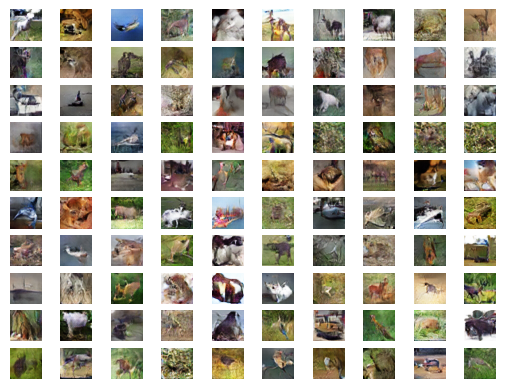

In [18]:
def save_plot(examples, n):
    # scale from [-1,1] to [0,1]
    # plot images
    for i in range(n * n):
        # define subplot
        plt.subplot(n, n, 1 + i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(examples[i])
    # save plot to file
    filename = 'final_generated_plot'
    plt.savefig(filename)
    plt.show()

## load model
model = load_model('generator_model_200.h5')
## generate images
latent_points = generate_latent_points(100, 100)
## generate images
gen = model.predict(latent_points)
## scale from [-1,1] to [0,1]
gen = (gen + 1) / 2.0
## plot the result
save_plot(gen, 10)

### D and G Loss

Upon plotting the discriminator and generator loss, we can see that the fake loss has an extremely sharp spike in loss at around the 15 thousandth step. This however, is not vastly unnatural behavior, and is likely due to the model being unstable throughout the course of its training. <br><br>

Excluding this single anomaly, we can see that the loss function performs relatively similarly throughout the rest of the model training.

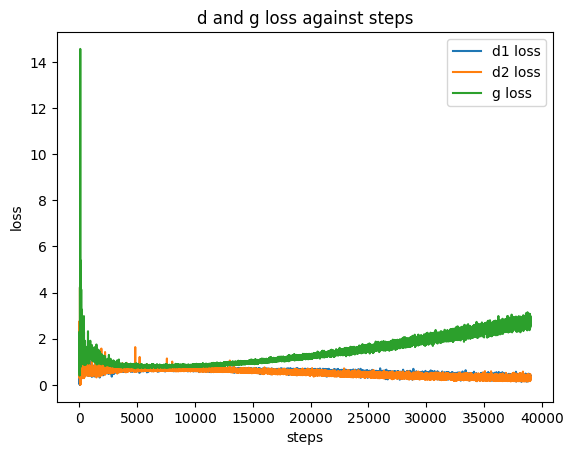

In [19]:
plt.plot(d1_loss_history, label='d1 loss')
plt.plot(d2_loss_history, label='d2 loss')
plt.plot(g_loss_history, label='g loss')
plt.title('d and g loss against steps')
plt.xlabel('steps')
plt.ylabel('loss')
plt.legend()
plt.show()

## Real & Fake Accuracy

By plotting the real and fake classification accuracies from the discriminator model, we can see that the real accuracy increases across epochs, while the fake decreases. Towards the end, they are about the converge. <br><br>

In an ideal scenario, the accuracies should be 50/50. Although in this case, the accuries are high, the images are still up to standard and these metrics should not be taken too seriously.

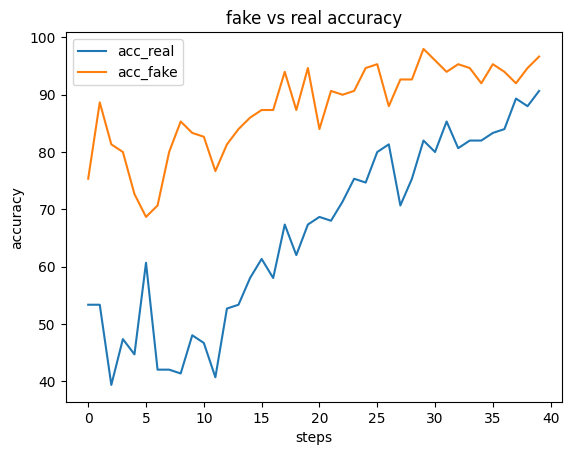

In [20]:
plt.plot(acc_real_array, label='acc_real')
plt.plot(acc_fake_array, label='acc_fake')
plt.title('fake vs real accuracy')
plt.xlabel('steps')
plt.ylabel('accuracy')
plt.legend()
plt.show()

## FID

Lastly, by plotting FID scores, we can see that although the FID scores seem very volatile, the y axis scal only ranges from 1 to 3 and hence only has an amplitude of 2. Furthermore, depite its volatility, still shows a slight decreasing trend, and managed to achive a good FID score at the end of its training cycle.

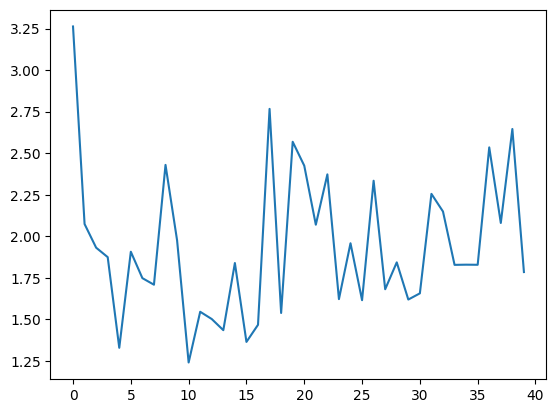

In [21]:
plt.plot(fid_array)

## Image Generation

4/4 [==============================] - 0s 64ms/step


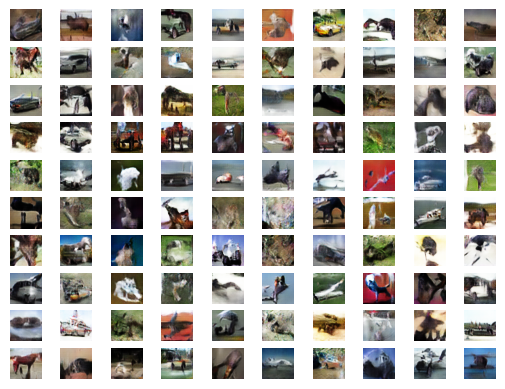

In [15]:
def save_plot(examples, n, imageGen):
    ## scale from [-1,1] to [0,1]
    ## plot images
    for i in range(n * n):
        ## define subplot
        plt.subplot(n, n, 1 + i)
        ## turn off axis
        plt.axis('off')
        ## plot raw pixel data
        plt.imshow(examples[i])
    ## save plot to file
    filename = f'final_generated_plot_{imageGen+1}'
    plt.savefig(filename)

## load model
model = load_model('GAN 3 RUN 6/generator_model_200.h5')
for imageGen in range(0, 10):
    ## generate images
    latent_points = generate_latent_points(100, 100)
    ## generate images
    gen = model.predict(latent_points)
    ## scale from [-1,1] to [0,1]
    gen = (gen + 1) / 2.0
    ## plot the result
    save_plot(gen, 10, imageGen)

## REFERENCES
##### https://machinelearningmastery.com/practical-guide-to-gan-failure-modes/
##### https://github.com/mit-han-lab/data-efficient-gans/blob/master/DiffAugment_tf.py
##### https://towardsdatascience.com/using-gans-to-generate-realistic-images-using-keras-and-the-cifar10-dataset-7dc6d23de994
##### https://www.kaggle.com/code/laszlofazekas/cifar10-dcgan-example
##### https://pyimagesearch.com/2021/11/11/get-started-dcgan-for-fashion-mnist/
##### https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/
##### https://github.com/JadeBlue96/DCGAN-Dog-Generator
##### https://towardsdatascience.com/gan-ways-to-improve-gan-performance-acf37f9f59b
##### https://medium.com/octavian-ai/a-simple-explanation-of-the-inception-score-372dff6a8c7a
##### https://machinelearningmastery.com/how-to-implement-the-inception-score-from-scratch-for-evaluating-generated-images/
##### https://machinelearningmastery.com/how-to-train-stable-generative-adversarial-networks/
##### https://github.com/JadeBlue96/DCGAN-Dog-Generator
##### https://towardsdatascience.com/dcgans-generating-dog-images-with-tensorflow-and-keras-fb51a1071432
##### https://www.kaggle.com/code/paulorzp/show-annotations-and-breeds/notebook
##### https://github.com/mafda/generative_adversarial_networks_101/blob/master/src/cifar10/03_CGAN_CIFAR10.ipynb¶
##### https://machinelearningmastery.com/practical-guide-to-gan-failure-modes/
##### https://github.com/jason71995/tf2_gan_library/tree/master/gan_lib
##### https://github.com/vineeths96/Generative-Adversarial-Networks-GANs#self-attention-gan
##### https://www.tensorflow.org/addons/api_docs/python/tfa/layers/SpectralNormalization
##### https://www.mathworks.com/help/deeplearning/ug/train-conditional-generative-adversarial-network.html
##### https://medium.datadriveninvestor.com/an-introduction-to-conditional-gans-cgans-727d1f5bb011
##### https://machinelearningmastery.com/how-to-develop-a-conditional-generative-adversarial-network-from-scratch/
##### https://machinelearningmastery.com/how-to-implement-wasserstein-loss-for-generative-adversarial-networks/#:~:text=Instead%20of%20using%20a%20discriminator,fakeness%20of%20a%20given%20image.
##### https://jonathan-hui.medium.com/gan-wasserstein-gan-wgan-gp-6a1a2aa1b490
##### https://towardsdatascience.com/demystified-wasserstein-gans-wgan-f835324899f4
##### https://machinelearningmastery.com/how-to-implement-wasserstein-loss-for-generative-adversarial-networks/
##### https://arxiv.org/abs/1506.05439
##### https://github.com/MarkPopovich/cifar-10/blob/master/00-CIFAR_EDA.ipynb
##### https://www.kaggle.com/code/adtysregita/pca-application-using-cifar10-dataset